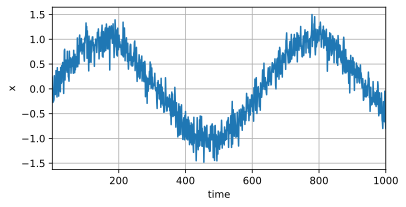

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))

for i in range(tau):
    features[:, i] = x[i: T - tau + i] # 一列一列填充
labels = x[tau:].reshape((-1, 1)) # 一个值对应一行的标签

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [3]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

In [4]:
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

In [5]:
# MSELoss 计算平方误差时不带系数 1/2
loss = nn.MSELoss(reduction='none')

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.062699
epoch 2, loss: 0.056671
epoch 3, loss: 0.054535
epoch 4, loss: 0.051573
epoch 5, loss: 0.051037


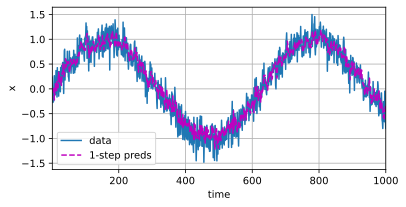

In [7]:
onestep_preds = net(features) # 用原始 feature 预测
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time', 'x', legend=['data', '1-step preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
# 第 600 行训练数据是 600 ~ 600 + tau
# tau + 1 ~ 600 + tau - 1 的采用原始数据；[600 + tau: ] 采用之前的预测数据进行预测
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau: i].reshape((1, -1)))

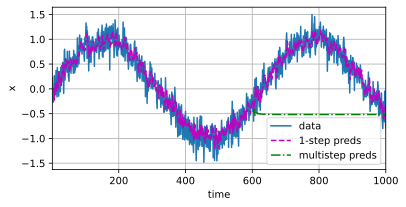

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()],
         'time', 'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

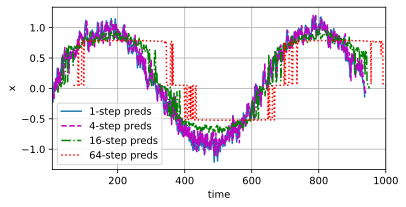

In [10]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 i (i < tau) 是来自 x 的观测
# 其时间步从 i + 1 到 i + T - tau - max_steps + 1（时间步从 1 开始）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
    
# 列 i (i >= tau) 是 (i - tau + 1) 步的预测
# 其时间步从 i + 1 到 i + T - tau - max_steps + 1（时间步从 1 开始）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau: i]).reshape(-1)
    
steps = (1, 4, 16, 64)

# 因为 features 的行是 0 ~ T - tau - max_steps，所以对于 k 步预测，x 轴范围是 tau - 1 + k ~ T - tau - max_steps + tau + k - 1
# => tau - 1 + k ~ T - max_steps + k - 1
d2l.plot([time[tau + k - 1: T - max_steps + k] for k in steps],
         [features[:, (tau + k - 1)].detach().numpy() for k in steps], # 选择对应的 tau + k - 1 列
         'time', 'x', legend=[f'{k}-step preds' for k in steps],
         xlim=[5, 1000], figsize=(6, 3))

In [11]:
import re
import collections

In [12]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    '''将时间机器数据集加载到文本行的列表中'''
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    # 忽略标点符号和大小写
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本行总数：{len(lines)}')
print(lines[0])
print(lines[10])

# 文本行总数：3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [13]:
def tokenize(lines, token='word'):
    '''将列表中的每个文本行拆分为单词或字符词元组成的列表'''
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)
        
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [14]:
class Vocab:
    '''文本词表'''
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        # 按出现的频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True) # 按频率倒序排
        
        self.idx_to_token, self.token_to_idx = [], dict()
        # 未知词元的索引为 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx['<unk>'] = 0
        
        
        for idx, token in enumerate(reserved_tokens):
            self.token_to_idx[token] = idx + 1

        
        
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk) # tokens 不在字典中时，默认返回 0
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property # 自动创建了 self.unk
    def unk(self): # 未知词元的索引为 0
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
    
def count_corpus(tokens):
    '''统计词元的频率'''
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
        # 不能 tokens = [token for token in line for line in tokens]
        # 因为要先定义 line
    return collections.Counter(tokens) # 返回一个 Counter 对象，保存的是键值对 词元：频率

In [15]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[: 10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [16]:
for i in [0, 10]:
    print('文本：', tokens[i])
    print('索引：', vocab[tokens[i]])

文本： ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引： [1, 19, 50, 40, 2183, 2184, 400]
文本： ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引： [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [17]:
def load_corpus_time_machine(max_tokens=-1):
    '''返回时光机器数据集的词元索引列表和词表'''
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line] # token 是一个字符
    # 在上面的 __getitem__ 函数中返回一个 id 值，而不是列表
    # 所以整个 corpus 是一个一维列表
    if max_tokens > 0:
        corpus = corpus[: max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [18]:
import random

tokens = tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[: 10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

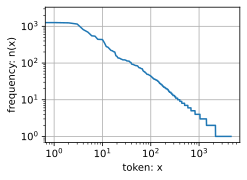

In [19]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log')

In [20]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [21]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

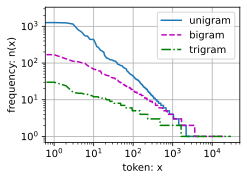

In [22]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [23]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    '''使用随机抽样生成一个小批量子序列'''
    # 从随即偏移量开始对序列进行分区，随机范围包括 num_steps - 1
    corpus = corpus[random.randint(0, num_steps - 1): ]
    # 计算子序列的个数，这里减去 1，是因为需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为 num_steps 的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中
    # 来自两个相邻的，随机的，小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)
    
    def data(pos):
        # 返回从 pos 位置开始的长度为 num_steps 的序列
        return corpus[pos: pos + num_steps]
    
    # 每个 batch 包含的子序列的个数
    num_batches = num_subseqs // batch_size 
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里 initial_indices 包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [24]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print("X: ", X, "\nY: ", Y)

X:  tensor([[23, 24, 25, 26, 27],
        [18, 19, 20, 21, 22]]) 
Y:  tensor([[24, 25, 26, 27, 28],
        [19, 20, 21, 22, 23]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [ 3,  4,  5,  6,  7]]) 
Y:  tensor([[ 9, 10, 11, 12, 13],
        [ 4,  5,  6,  7,  8]])


In [25]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    '''使用顺序分区生成一个小批量子序列'''
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size # 计算考虑的总序列的长度
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps # 相当于 Time
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [26]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print("X: ", X, "\nY: ", Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y:  tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y:  tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y:  tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [27]:
class SeqDataLoader:
    '''加载序列数据的迭代器'''
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
        
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [28]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    '''返回时光机器数据集的迭代器和词汇表'''
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [29]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-1.1595,  0.1682,  0.6384, -0.1703],
        [-4.5638, -2.5041, -1.1552, -2.3375],
        [ 1.7578,  0.3153, -2.7692,  0.9446]])

In [30]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-1.1595,  0.1682,  0.6384, -0.1703],
        [-4.5638, -2.5041, -1.1552, -2.3375],
        [ 1.7578,  0.3153, -2.7692,  0.9446]])

In [31]:
import math
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [32]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [33]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [34]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    # 输入是独热编码 len(vocab) 输出是概率
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [35]:
def init_rnn_state(batch_size, num_hiddens, device):
    # 设置初始的隐状态，就是输入给第一个时间步的 h
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [36]:
def rnn(inputs, state, params):
    # inputs 的形状：（时间步数量，批量大小，词表大小-独热编码）
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X 的形状：（批量大小，词表大小）
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, ) # 按时间步顺序将同一时间步的 Y 拼接在一起
    # 输出形状是（时间步数量 * 批量大小，词表大小）

In [37]:
class RNNModelScrath:
    '''从零开始实现的循环神经网络模型'''
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [38]:
num_hiddens = 512
net = RNNModelScrath(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                     init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [39]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    '''在 prefix 后面生成新字符'''
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    # 每次取本次时间步要输入进来的字符-时间步数量：1，批量大小：1
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]: # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for y in range(num_preds): # 预测 num_preds 步
        y, state = net(get_input(), state) # y 是 one-hot 编码
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [40]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller cmkodjxcsw'

In [41]:
def grad_clipping(net, theta):
    '''梯度裁剪'''
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 需要整合所有参数的梯度
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [42]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    '''训练网络一个迭代周期'''
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2) # 训练损失之和，词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化 state(h_0)
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 在处理任何一个小批量数据之前，控制梯度不流传到上一个时间步
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state 对于 nn.GRU 是个张量
                state.detach_()
            else:
                # state 对于 nn.LSTM 或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1) # 将 Y 中同一列（同一时间步）的元素按时间步顺序拼接
        '''
        [[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]
        =>
        y: [1, 4, 7, 2, 5, 8, 3, 6, 9]
        因为 net(X) 的结果是这样拼接的
        y_hat: [[..], [..], [..], [..], [..], [..], [..], [..], [..]]
        这样做交叉熵才没问题
        '''
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # 反向传播梯度之前，先进行梯度裁剪
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward(retain_graph=True)
            grad_clipping(net, 1)
            # 因为已经调用了 mean 函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    # 返回困惑度和训练效率
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [43]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    '''训练模型'''
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 61534.1 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


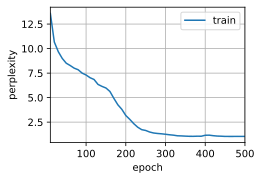

In [44]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.6, 56150.4 词元/秒 cuda:0
time traveller held in his hand was a glitteringmetallic framewo
traveller held in his hand was a glitteringmetallic framewo


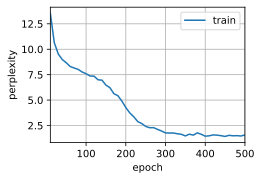

In [45]:
net = RNNModelScrath(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                     init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

In [46]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [47]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [48]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [49]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [50]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果 RNN 是双向的（之后将介绍），num_directions 应该是 2，否则应该是 1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    
    def forward(self, inputs, state):
        # inputs: (batch_size, time_steps)
        # X: (time_steps, batch_size, vocab_size) 所以需要 .T
        # state: (1, batch_size, hidden_nums)
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 这里输出的 Y 的形状和我们手写的不一样
        # 形状是（时间步数，批量大小，隐藏单元数）
        
        # 全连接层首先将 Y 的形状改为（时间步数 * 批量大小，隐藏单元数）
        # 它的输出形状是（时间步数 * 批量大小，词表大小）
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # 普通 RNN 和 nn.GRU 以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            # nn.LSTM 以元组作为隐状态
            # self.rnn.num_layers 是 RNN 的层数（深度方向上）
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device))

In [51]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=(len(vocab)))
net = net.to(device)
predict_ch8('time traveller', 10, net, vocab, device)

'time travelleriezezezeze'

困惑度 1.3, 256683.0 词元/秒 cuda:0
time traveller but now you begin to seethe object of my investig
travellerit isat space have nos hams onla s im that spand t


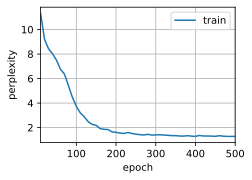

In [52]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=(len(vocab)))
net = net.to(device)
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

In [53]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [54]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xz, W_hz, b_z = three() # 更新门参数
    W_xr, W_hr, b_r = three() # 重置门参数
    W_xh, W_hh, b_h = three() # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [55]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [56]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

困惑度 1.1, 20558.3 词元/秒 cuda:0
time traveller whth a light of opatour cercainly it tracedsuch a
traveller held in his hand was a glitteringmetallic framewo


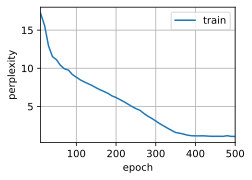

In [57]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScrath(len(vocab), num_hiddens, device, get_params,
                       init_gru_state, gru)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度 1.0, 195305.9 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


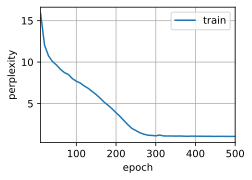

In [58]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [59]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [60]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xi, W_hi, b_i = three() # 输入门参数
    W_xf, W_hf, b_f = three() # 遗忘门参数
    W_xo, W_ho, b_o = three() # 输出门参数
    W_xc, W_hc, b_c = three() # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [61]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [62]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

困惑度 1.1, 17210.6 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller bucherar exporading three dimensions they could w


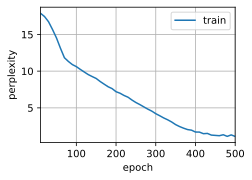

In [63]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScrath(len(vocab), num_hiddens, device, get_lstm_params,
                       init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度 1.1, 160516.7 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


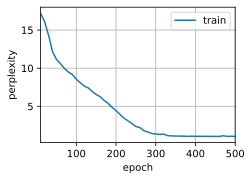

In [64]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [65]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [66]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

困惑度 1.0, 103264.5 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


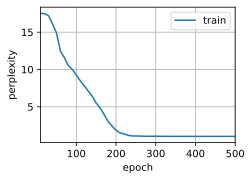

In [67]:
num_epochs, lr = 500, 2
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度 1.1, 54780.2 词元/秒 cuda:0
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


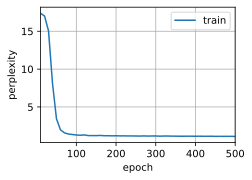

In [68]:
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [69]:
import os

d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')
def read_data_nmt():
    '''载入 英语-法语 数据集'''
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[: 75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [70]:
def preprocess_nmt(text):
    '''预处理 英语-法语 数据集'''
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[: 80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [71]:
def tokenize_nmt(text, num_examples=None):
    '''词元化 英语-法语 数据集'''
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[: 6], target[: 6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

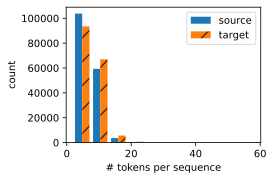

In [72]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    '''绘制列表长度对的直方图（每个文本序列所包含的词元数量）'''
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)
    
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target)

In [73]:
src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [74]:
src_vocab.to_tokens([i for i in range(10)])

['<unk>', '<pad>', '<bos>', '<eos>', '.', 'i', 'you', 'to', 'the', '?']

In [75]:
def truncate_pad(line, num_steps, padding_token):
    '''截断或填充文本序列'''
    if len(line) > num_steps:
        return line[: num_steps] # 截断
    return line + [padding_token] * (num_steps - len(line)) # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [76]:
def build_array_nmt(lines, vocab, num_steps):
    '''将机器翻译的文本序列转换成小批量'''
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    # dim=1 上求和
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1) 
    return array, valid_len

In [77]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    '''返回翻译数据集的迭代器和词表'''
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [78]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print(src_vocab.to_tokens(X[0].tolist()))
    print(tgt_vocab.to_tokens(Y[0].tolist()))
    print('X: ', X.type(torch.int32))
    print('X 的有效长度: ', X_valid_len)
    print('Y: ', Y.type(torch.int32))
    print('Y 的有效长度: ', Y_valid_len)
    break

['help', 'us', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>']
['<unk>', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
X:  tensor([[36, 23,  4,  3,  1,  1,  1,  1],
        [44, 56,  5,  3,  1,  1,  1,  1]], dtype=torch.int32)
X 的有效长度:  tensor([4, 4])
Y:  tensor([[  0,   5,   3,   1,   1,   1,   1,   1],
        [151,  15,  29,  74,   5,   3,   1,   1]], dtype=torch.int32)
Y 的有效长度:  tensor([3, 6])


In [79]:
class Encoder(nn.Module):
    '''编码器-解码器架构的基本编码器接口'''
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    
    def forward(self, X, *args):
        raise NotImplementedError

In [80]:
class Decoder(nn.Module):
    '''编码器-解码器架构的基本解码器接口'''
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
        
    def forward(self, X, state):
        raise NotImplementedError

In [93]:
class EncoderDecoder(nn.Module):
    '''编码器-解码器架构的基类'''
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state, dec_state)

In [82]:
class Seq2SeqEncoder(Encoder):
    '''用于序列到序列学习的循环神经网络编码器'''
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, 
                          dropout=dropout)
        
    def forward(self, X, *args):
        # 输入 X 的形状：(batch_size, num_steps)
        # 经过 embedding 层变为：(batch_size, num_steps, embed_size)
        X = self.embedding(X)
        # 在循环神经网络中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为 0
        output, state = self.rnn(X)
        # output 的形状：(num_steps, batch_size, num_hiddens)
        # state 的形状：(num_layers, batch_size, num_hiddens) (GRU)
        # output 代表最后一层所有时间步的隐状态
        # state 代表每一层最后一个时间步的隐状态
        return output, state

In [83]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [94]:
class Seq2SeqDecoder(Decoder):
    '''用于序列到序列学习的循环神经网络解码器'''
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1] # 即选择 encoder 输出的 state
    
    def forward(self, X, enc_state, dec_state):
        # X 的形状变换为：(num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态
        # 上下文变量（在这里是编码器最后一层最后一个时间步的隐状态）
        # 在所有的时间步与解码器的输入进行拼接
        # 即广播 context，使其具有与 X 相同的 num_steps
        # context 的形状从 (1, batch_size, num_hiddens) 变为
        # (num_steps, batch_size, num_hiddens)
        context = enc_state[-1].repeat(X.shape[0], 1, 1)
        # X_and_context 的形状为：
        # (num_steps, batch_size, (num_hiddens + embed_size))
        X_and_context = torch.cat((X, context), 2)
        output, dec_state = self.rnn(X_and_context, dec_state)
        output = self.dense(output).permute(1, 0, 2)
        # output 的形状：(batch_size, num_steps, vocab_size)
        # state 的形状：(num_layers, batch_size, num_hiddens)
        return output, dec_state

In [85]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [86]:
def sequence_mask(X, valid_len, value=0):
    '''在序列中屏蔽不相关的项'''
    maxlen = X.size(1) # 第一轴（列）的维度
    # maxlen = num_steps
    # mask 的形状是：(num_steps)
    # valid_len 的形状是：(batch_size)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    # [None, :] 的作用是：为原 Tensor 增加 None 所在的轴（增加一维）
    # mask 的形状变为：(1, num_steps)
    # valid_len 的形状变为：(batch_size, 1)
    # mask 和 valid_len 都广播为 (batch_size, num_steps) 进行比较运算
    # 最终 mask 是形状为 (batch_size, num_steps) 的逻辑矩阵
    # 每一行只有前 valid_len 个值是 True，保证序列有效长度之前的值都有效
    # 有效长度之后的值都被清零
    
    # X 的形状是：(batch_size, num_steps)
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [87]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    '''带遮蔽的 softmax 交叉熵损失函数'''
    # pred 的形状：(batch_size, num_steps, vocab_size)
    # label 的形状：(batch_size, num_steps)
    # valid_len 的形状：(batch_size, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        # pyTorch 要求预测必须放在 dim=1 维
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        # unweighted_loss 的形状：(batch_size, num_steps)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [88]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    '''训练序列到序列模型'''
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
                    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2) # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            # bos 的形状：(batch_size, 1)
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            # 将 bos 和正确的输出序列拼接在一起作为解码器的输入
            # 同时去掉正确的输出序列的最后一个词
            # Y[:, :-1] 的形状为：(batch_size, num_steps - 1)
            # dec_input 的形状为：(batch_size, num_steps)
            dec_input = torch.cat([bos, Y[:, :-1]], 1) # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1], ))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.018, 9991.0 tokens/sec on cuda:0


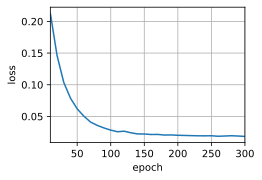

In [111]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [116]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    '''序列到序列模型的预测'''
    net.eval()
    # 将原始句子转换成词元列表
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴 batch_size = 1
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    # enc_X = torch.tensor(src_tokens, dtype=torch.long, device=device)[None, :]
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    enc_state = dec_state.clone().detach()
    # 添加批量轴 batch_size = 1, 第一次输入的只有词元 <bos>
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    # dec_X = torch.tensor(
        # [tgt_vocab['<bos>']], dtype=torch.long, device=device)[None, :]
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        # encoder 的输出隐状态是不变的
        # 与训练中保持一致，和每个时间步的 X 进行拼接
        # 而 decoder 每个时间步输出的隐状态是要改变的
        # 相当于 decoder 中 RNN 的隐状态 h，需要传给下一个时间步
        Y, dec_state = net.decoder(dec_X, enc_state, dec_state)
        # 我们使用具有最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        # dec_X 的维度是 (batch_size, 1) 即 (1, 1)
        # 需要变成标量
        pred = dec_X.squeeze(dim=0).type(torch.int32).item() # 降维
        # pred = dec_X.flatten().item()
        # 保存注意力权重
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就结束了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [1]:
def bleu(pred_seq, label_seq, k):
    '''计算 BLEU'''
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / (len_pred + 1e-6)))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1 + 1e-6), math.pow(0.5, n))
    return score

In [117]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


In [112]:
for line in text.split('\n'):
    idx = line.find('\t')
    eng, fra = line[: idx], line[idx + 1: ]
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'({eng}) => ({translation}), bleu {bleu(translation, fra, k=2):.3f},', 
          f' correct ({fra})')

(go .) => (va !), bleu 1.000,  correct (va !)
(hi .) => (salut !), bleu 1.000,  correct (salut !)
(run !) => (courez !), bleu 0.000,  correct (cours !)
(run !) => (courez !), bleu 1.000,  correct (courez !)
(who ?) => (qui ?), bleu 1.000,  correct (qui ?)
(wow !) => (fantastique !), bleu 0.000,  correct (ça alors !)
(fire !) => (au feu !), bleu 1.000,  correct (au feu !)
(help !) => (à la <unk> .), bleu 0.000,  correct (à l'aide !)
(jump .) => (<unk> !), bleu 0.000,  correct (saute .)
(stop !) => (<unk> !), bleu 0.000,  correct (ça suffit !)
(stop !) => (<unk> !), bleu 0.000,  correct (stop !)
(stop !) => (<unk> !), bleu 0.000,  correct (arrête-toi !)
(wait !) => (attends !), bleu 1.000,  correct (attends !)
(wait !) => (attends !), bleu 0.000,  correct (attendez !)
(go on .) => (<unk> .), bleu 0.000,  correct (poursuis .)
(go on .) => (<unk> .), bleu 0.000,  correct (continuez .)
(go on .) => (<unk> .), bleu 0.000,  correct (poursuivez .)
(hello !) => (<unk> !), bleu 0.000,  correct (

(i dozed .) => (je me suis <unk> .), bleu 0.752,  correct (je me suis assoupie .)
(i drive .) => (je <unk> .), bleu 0.000,  correct (je conduis .)
(i smoke .) => (j’ai <unk> .), bleu 0.000,  correct (je fume .)
(i snore .) => (j’ai <unk> .), bleu 0.000,  correct (je ronfle .)
(i stink .) => (j’ai <unk> .), bleu 0.000,  correct (je pue .)
(i stood .) => (je me suis <unk> debout .), bleu 0.803,  correct (je me suis tenu debout .)
(i stood .) => (je me suis <unk> debout .), bleu 0.803,  correct (je me suis tenue debout .)
(i swore .) => (j’ai <unk> .), bleu 0.000,  correct (j’ai promis .)
(i swore .) => (j’ai <unk> .), bleu 0.000,  correct (j’ai juré .)
(i tried .) => (j'ai <unk> .), bleu 0.000,  correct (j'essayai .)
(i tried .) => (j'ai <unk> .), bleu 0.000,  correct (j'ai essayé .)
(i tried .) => (j'ai <unk> .), bleu 0.000,  correct (j'ai tenté .)
(i waved .) => (j’ai <unk> .), bleu 0.000,  correct (j’ai fait signe .)
(i'll go .) => (<unk> .), bleu 0.000,  correct (j'irai .)
(i'm tom .

(i failed .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai échoué .)
(i forgot .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai oublié .)
(i get it .) => (j'ai compris .), bleu 1.000,  correct (j'ai compris .)
(i got it .) => (j'ai capté .), bleu 0.000,  correct (j'ai compris .)
(i got it .) => (j'ai capté .), bleu 1.000,  correct (j'ai capté .)
(i helped .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai aidé .)
(i jumped .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai sauté .)
(i looked .) => (j’ai <unk> .), bleu 0.000,  correct (j’ai regardé .)
(i moaned .) => (j’ai <unk> .), bleu 0.000,  correct (j’ai râlé .)
(i nodded .) => (j’ai <unk> .), bleu 0.000,  correct (j’ai fait signe de la tête .)
(i obeyed .) => (j’ai <unk> .), bleu 0.000,  correct (j’ai obéi .)
(i phoned .) => (je <unk> .), bleu 0.000,  correct (je téléphonai .)
(i phoned .) => (je <unk> .), bleu 0.000,  correct (j'ai téléphoné .)
(i refuse .) => (je le refuse .), bleu 0.658,  correct (je refuse .)
(i refuse .) => (je l

(terrific !) => (<unk> !), bleu 0.000,  correct (excellent !)
(terrific !) => (<unk> !), bleu 0.000,  correct (formidable !)
(they won .) => (elles ont gagné .), bleu 0.000,  correct (ils gagnèrent .)
(they won .) => (elles ont gagné .), bleu 0.000,  correct (elles gagnèrent .)
(they won .) => (elles ont gagné .), bleu 0.783,  correct (ils ont gagné .)
(they won .) => (elles ont gagné .), bleu 1.000,  correct (elles ont gagné .)
(tom came .) => (tom est venu .), bleu 1.000,  correct (tom est venu .)
(tom died .) => (tom <unk> .), bleu 0.000,  correct (tom est mort .)
(tom died .) => (tom <unk> .), bleu 0.000,  correct (tom muera .)
(tom knew .) => (tom <unk> .), bleu 0.000,  correct (tom savait .)
(tom left .) => (tom est parti .), bleu 1.000,  correct (tom est parti .)
(tom left .) => (tom est parti .), bleu 0.000,  correct (tom partit .)
(tom lied .) => (tom <unk> .), bleu 0.000,  correct (tom a menti .)
(tom lies .) => (tom <unk> .), bleu 0.000,  correct (tom ment .)
(tom lost .) =>

(he's rich .) => (il est riche .), bleu 1.000,  correct (il est riche .)
(he's sexy .) => (il est <unk> .), bleu 0.658,  correct (il est sexy .)
(here i am .) => (me <unk> .), bleu 0.000,  correct (me voici .)
(here's $5 .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (voilà cinq dollars .)
(hold fire .) => (<unk> au feu !), bleu 0.783,  correct (halte au feu !)
(hold fire .) => (<unk> au feu !), bleu 0.537,  correct (cessez le feu !)
(hold this .) => (tiens ceci !), bleu 0.000,  correct (tiens ça !)
(hold this .) => (tiens ceci !), bleu 0.000,  correct (tenez ça !)
(hold this .) => (tiens ceci !), bleu 0.687,  correct (tenez ceci !)
(hold this .) => (tiens ceci !), bleu 1.000,  correct (tiens ceci !)
(how awful !) => (comme c'est <unk> !), bleu 0.000,  correct (c'est affreux !)
(how weird !) => (comme c'est <unk> !), bleu 0.658,  correct (comme c'est bizarre !)
(how's tom ?) => (comment tom <unk> ?), bleu 0.658,  correct (comment tom va-t-il ?)
(how's tom ?) => (comment tom <unk> ?)

(i'll live .) => (je <unk> .), bleu 0.000,  correct (je vivrai .)
(i'll obey .) => (je <unk> .), bleu 0.000,  correct (j'obéirai .)
(i'll pack .) => (je <unk> .), bleu 0.000,  correct (je ferai mon sac .)
(i'll pack .) => (je <unk> .), bleu 0.000,  correct (je ferai ma valise .)
(i'll pack .) => (je <unk> .), bleu 0.000,  correct (je plierai mes gaules .)
(i'll pass .) => (je <unk> .), bleu 0.000,  correct (je passerai .)
(i'll quit .) => (je <unk> .), bleu 0.000,  correct (j'abandonnerai .)
(i'll sing .) => (je <unk> .), bleu 0.000,  correct (je chanterai .)
(i'll stop .) => (je <unk> .), bleu 0.000,  correct (j'arrêterai .)
(i'll swim .) => (je <unk> .), bleu 0.000,  correct (je nagerai .)
(i'll talk .) => (je <unk> .), bleu 0.000,  correct (je parlerai .)
(i'll talk .) => (je <unk> .), bleu 0.000,  correct (je vais parler .)
(i'll wait .) => (je suis .), bleu 0.000,  correct (j'attendrai .)
(i'll walk .) => (je <unk> .), bleu 0.000,  correct (je marcherai .)
(i'll work .) => (je <un

(it's easy .) => (il est <unk> .), bleu 0.000,  correct (c'est simple .)
(it's food .) => (il est <unk> .), bleu 0.000,  correct (c'est de la nourriture .)
(it's free .) => (c'est <unk> .), bleu 0.000,  correct (c'est gratuit .)
(it's here .) => (c'est le <unk> .), bleu 0.000,  correct (elle est ici .)
(it's here .) => (c'est le <unk> .), bleu 0.000,  correct (c'est ici .)
(it's hers .) => (il est <unk> .), bleu 0.000,  correct (c'est le sien .)
(it's hers .) => (il est <unk> .), bleu 0.000,  correct (c'est la sienne .)
(it's late .) => (c'est bizarre .), bleu 0.000,  correct (il est tard .)
(it's lost .) => (c'est <unk> .), bleu 0.000,  correct (c'est perdu .)
(it's mine .) => (il est <unk> .), bleu 0.000,  correct (c'est le mien .)
(it's mine .) => (il est <unk> .), bleu 0.000,  correct (c'est la mienne .)
(it's mine .) => (il est <unk> .), bleu 0.000,  correct (c'est à moi .)
(it's mine .) => (il est <unk> .), bleu 0.000,  correct (il s'agit du mien .)
(it's open .) => (<unk> !), bl

(take mine .) => (<unk> !), bleu 0.000,  correct (prenez les miennes .)
(take this .) => (<unk> ceci !), bleu 0.000,  correct (prends ça .)
(take this .) => (<unk> ceci !), bleu 0.000,  correct (prenez ça .)
(thank you .) => (<unk> vous .), bleu 0.000,  correct (merci !)
(that's ok .) => (<unk> .), bleu 0.000,  correct (il n'y a pas de problème .)
(that's ok .) => (<unk> .), bleu 0.000,  correct (pas de problème .)
(that's ok .) => (<unk> .), bleu 0.000,  correct (ce n'est pas grave .)
(that's ok .) => (<unk> .), bleu 0.000,  correct (ça va .)
(that's it .) => (dégage !), bleu 0.000,  correct (c'est ça .)
(they fell .) => (assieds-toi .), bleu 0.000,  correct (ils sont tombés .)
(they fell .) => (assieds-toi .), bleu 0.000,  correct (elles sont tombées .)
(they left .) => (nous <unk> maintenant .), bleu 0.000,  correct (ils sont partis .)
(they left .) => (nous <unk> maintenant .), bleu 0.000,  correct (elles sont parties .)
(they lied .) => (assieds-toi .), bleu 0.000,  correct (ils o

(be careful .) => (sois gentil .), bleu 0.000,  correct (sois prudent !)
(be careful .) => (sois gentil .), bleu 0.000,  correct (sois prudente !)
(be careful .) => (sois gentil .), bleu 0.000,  correct (soyez prudent !)
(be careful .) => (sois gentil .), bleu 0.000,  correct (soyez prudente !)
(be careful .) => (sois gentil .), bleu 0.000,  correct (soyez prudents !)
(be careful .) => (sois gentil .), bleu 0.000,  correct (soyez prudentes !)
(be content .) => (sois gentil .), bleu 0.000,  correct (sois satisfait !)
(be content .) => (sois gentil .), bleu 0.000,  correct (sois satisfaite !)
(be content .) => (sois gentil .), bleu 0.000,  correct (soyez satisfait !)
(be content .) => (sois gentil .), bleu 0.000,  correct (soyez satisfaite !)
(be content .) => (sois gentil .), bleu 0.000,  correct (soyez satisfaits !)
(be content .) => (sois gentil .), bleu 0.000,  correct (soyez satisfaites !)
(be on time .) => (calmez-vous !), bleu 0.000,  correct (soyez à l'heure .)
(be on time .) => 

(i am a man .) => (je suis certain .), bleu 0.512,  correct (je suis un homme .)
(i am going .) => (je suis <unk> .), bleu 0.000,  correct (j’y vais .)
(i am human .) => (je suis <unk> .), bleu 0.658,  correct (je suis humain .)
(i am ready .) => (je sais .), bleu 0.000,  correct (je suis prêt .)
(i am right .) => (je suis <unk> .), bleu 0.000,  correct (j'ai raison .)
(i am sorry .) => (je suis <unk> .), bleu 0.658,  correct (je suis désolé .)
(i am sorry .) => (je suis <unk> .), bleu 0.658,  correct (je suis désolée .)
(i am tired .) => (je suis <unk> .), bleu 0.537,  correct (je suis fatigué !)
(i am tired .) => (je suis <unk> .), bleu 0.658,  correct (je suis crevé .)
(i broke it .) => (je suis <unk> .), bleu 0.000,  correct (je l'ai cassé .)
(i broke it .) => (je suis <unk> .), bleu 0.000,  correct (je l'ai cassée .)
(i built it .) => (je suis <unk> .), bleu 0.000,  correct (je l'ai construit .)
(i built it .) => (je suis <unk> .), bleu 0.000,  correct (je l'ai construite .)
(i ca

(i was busy .) => (je suis <unk> .), bleu 0.000,  correct (j'étais occupée .)
(i was good .) => (je suis juste .), bleu 0.000,  correct (je fus bon .)
(i was good .) => (je suis juste .), bleu 0.000,  correct (j'ai été bon .)
(i was good .) => (je suis juste .), bleu 0.000,  correct (j'ai été bonne .)
(i was good .) => (je suis juste .), bleu 0.000,  correct (je fus bonne .)
(i was hurt .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été blessé .)
(i was last .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été dernier .)
(i was last .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais dernier .)
(i was last .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été dernière .)
(i was last .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais dernière .)
(i was late .) => (j’ai <unk> .), bleu 0.000,  correct (j'étais en retard .)
(i was late .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai été en retard .)
(i was lost .) => (je <unk> .), bleu 0.000,  cor

(it's awful .) => (il est <unk> .), bleu 0.000,  correct (c'est affreux .)
(it's bogus .) => (il est <unk> .), bleu 0.000,  correct (c'est du pipeau tout ça .)
(it's bulky .) => (il est <unk> .), bleu 0.000,  correct (c'est encombrant .)
(it's cheap .) => (il est <unk> .), bleu 0.000,  correct (c'est bon marché .)
(it's clean .) => (il est <unk> .), bleu 0.000,  correct (c'est propre .)
(it's close .) => (il est <unk> .), bleu 0.000,  correct (c'est proche .)
(it's early .) => (il est <unk> .), bleu 0.658,  correct (il est tôt .)
(it's funny .) => (il est <unk> .), bleu 0.000,  correct (c'est marrant .)
(it's funny .) => (il est <unk> .), bleu 0.000,  correct (c'est drôle .)
(it's funny .) => (il est <unk> .), bleu 0.000,  correct (c'est rigolo .)
(it's green .) => (il est <unk> .), bleu 0.000,  correct (c'est vert .)
(it's my cd .) => (il est <unk> .), bleu 0.000,  correct (c'est mon cd .)
(it's night .) => (il est <unk> .), bleu 0.000,  correct (il fait nuit .)
(it's on me .) => (c'e

(that a boy !) => (en ça !), bleu 0.000,  correct (t'es un bon garçon !)
(that hurts .) => (<unk> !), bleu 0.000,  correct (ça fait mal .)
(that works .) => (<unk> !), bleu 0.000,  correct (ça fonctionne .)
(that's all .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est tout .)
(that's fun .) => (<unk> !), bleu 0.000,  correct (c'est amusant .)
(that's fun .) => (<unk> !), bleu 0.000,  correct (c'est marrant .)
(that's her .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est elle .)
(that's his .) => (<unk> !), bleu 0.000,  correct (ce sont les siens .)
(that's his .) => (<unk> !), bleu 0.000,  correct (c'est le sien .)
(that's his .) => (<unk> !), bleu 0.000,  correct (c'est la sienne .)
(that's odd .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est bizarre .)
(they agree .) => (ils gagnèrent .), bleu 0.000,  correct (ils sont d'accord .)
(they agree .) => (ils gagnèrent .), bleu 0.000,  correct (elles sont d'accord .)
(they cheat .) => (assieds-toi .), bleu 0.000,  cor

(who are we ?) => (qui est tombé ?), bleu 0.000,  correct (qui sommes-nous ?)
(who did it ?) => (qui <unk> ?), bleu 0.000,  correct (qui l'a fait ?)
(who did it ?) => (qui <unk> ?), bleu 0.000,  correct (qui a fait ça ?)
(who has it ?) => (qui est venu ?), bleu 0.000,  correct (qui l'a ?)
(who is tom ?) => (comment va tom ?), bleu 0.418,  correct (c’est qui , tom ?)
(who phoned ?) => (qui <unk> ?), bleu 0.000,  correct (qui a téléphoné ?)
(who phoned ?) => (qui <unk> ?), bleu 0.000,  correct (qui est-ce qui a téléphoné ?)
(who saw me ?) => (qui bon .), bleu 0.000,  correct (qui m'a vu ?)
(who stayed ?) => (qui est venu ?), bleu 0.658,  correct (qui est resté ?)
(who talked ?) => (qui <unk> ?), bleu 0.000,  correct (qui a parlé ?)
(who yelled ?) => (qui <unk> ?), bleu 0.000,  correct (qui a hurlé ?)
(who's here ?) => (qui est tombé ?), bleu 0.658,  correct (qui est là ?)
(who's that ?) => (<unk> <unk> ?), bleu 0.000,  correct (qui est-ce ?)
(who's that ?) => (<unk> <unk> ?), bleu 0.000,

(can you try ?) => (<unk> quoi faire ?), bleu 0.000,  correct (pouvez-vous essayer ?)
(clean it up .) => (<unk> !), bleu 0.000,  correct (nettoyez-le .)
(clean it up .) => (<unk> !), bleu 0.000,  correct (nettoie-le .)
(come get it .) => (allez !), bleu 0.000,  correct (viens le chercher .)
(come get me .) => (<unk> !), bleu 0.000,  correct (venez me chercher .)
(come inside .) => (<unk> !), bleu 0.000,  correct (entre .)
(come off it !) => (reculez .), bleu 0.000,  correct (arrête ça !)
(come off it !) => (reculez .), bleu 0.000,  correct (arrête de te la péter !)
(come off it !) => (reculez .), bleu 0.000,  correct (arrête ton char !)
(come off it !) => (reculez .), bleu 0.000,  correct (décroche de ça !)
(come off it !) => (reculez .), bleu 0.000,  correct (change de disque !)
(come off it !) => (reculez .), bleu 0.000,  correct (laisse tomber !)
(come off it .) => (recule  !), bleu 0.000,  correct (laisse tomber .)
(come off it .) => (recule  !), bleu 0.000,  correct (arrête ton ch

(he's coming .) => (il est <unk> .), bleu 0.000,  correct (il arrive .)
(he's coming .) => (il est <unk> .), bleu 0.399,  correct (il est en train d'arriver .)
(he's crying .) => (il est <unk> .), bleu 0.311,  correct (il est en train de pleurer .)
(he's faking .) => (il est <unk> .), bleu 0.000,  correct (il simule .)
(he's loaded .) => (il est <unk> .), bleu 0.658,  correct (il est blindé .)
(he's loaded .) => (il est <unk> .), bleu 0.399,  correct (il est pété de thune .)
(he's loaded .) => (il est <unk> .), bleu 0.399,  correct (il est plein aux as .)
(he's my age .) => (il est <unk> .), bleu 0.000,  correct (il a mon âge .)
(he's not in .) => (elles ont gagné .), bleu 0.000,  correct (il n'est pas chez lui .)
(he's not in .) => (elles ont gagné .), bleu 0.000,  correct (il n'est pas à l'intérieur .)
(he's not in .) => (elles ont gagné .), bleu 0.000,  correct (il n'est pas là .)
(help me out .) => (<unk> .), bleu 0.000,  correct (aide-moi à sortir .)
(help me out .) => (<unk> .), 

(i hate golf .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste le golf .)
(i hate milk .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste le lait .)
(i hate sand .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste le sable .)
(i hate sand .) => (je m'en suis <unk> .), bleu 0.000,  correct (je hais le sable .)
(i hate that .) => (tom <unk> .), bleu 0.000,  correct (je déteste ça .)
(i hate them .) => (j’ai <unk> .), bleu 0.000,  correct (je les déteste .)
(i hate this .) => (je <unk> .), bleu 0.000,  correct (je déteste ça .)
(i hate work .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste le travail .)
(i have cash .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai du liquide .)
(i have cash .) => (j’ai <unk> .), bleu 0.000,  correct (je dispose de liquide .)
(i have eyes .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai des yeux .)
(i have food .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai de la nourriture .)
(i have food .) => (j’ai <unk

(i was alone .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me trouvais seule .)
(i was bored .) => (je m'en suis <unk> .), bleu 0.000,  correct (je m'ennuyais .)
(i was broke .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais sans le sou .)
(i was dizzy .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'avais la tête qui tournait .)
(i was dizzy .) => (je m'en suis <unk> .), bleu 0.000,  correct (la tête me tournait .)
(i was drunk .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais ivre .)
(i was fired .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été licencié .)
(i was fired .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été viré .)
(i was fired .) => (je m'en suis <unk> .), bleu 0.000,  correct (on m'a saqué .)
(i was hired .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été engagé .)
(i was lucky .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai eu de la chance .)
(i was moved .) => (je m'en suis <unk> .), bleu 0.000

(i'm neutral .) => (je suis <unk> .), bleu 0.658,  correct (je suis neutre .)
(i'm no fool .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas une idiote .)
(i'm no hero .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas un héros .)
(i'm no liar .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas un menteur .)
(i'm not tom .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas tom .)
(i'm not fat .) => (je suis gros .), bleu 0.461,  correct (je ne suis pas gros .)
(i'm not mad .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas fou .)
(i'm not mad .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas folle .)
(i'm not old .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas vieux .)
(i'm not old .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas vieille .)
(i'm not sad .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas triste .)
(i'm not shy .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis p

(it's ironic .) => (il est <unk> .), bleu 0.000,  correct (c'est ironique .)
(it's locked .) => (il est <unk> .), bleu 0.000,  correct (c'est verrouillé .)
(it's my job .) => (c'est au la la de question !), bleu 0.000,  correct (c'est mon métier .)
(it's my job .) => (c'est au la la de question !), bleu 0.000,  correct (c'est mon emploi .)
(it's no use .) => (<unk> <unk> !), bleu 0.000,  correct (ça ne sert à rien .)
(it's not us .) => (c'est bizarre .), bleu 0.000,  correct (ce n'est pas nous .)
(it's poison .) => (il est <unk> .), bleu 0.000,  correct (c'est du poison .)
(it's secret .) => (il est <unk> .), bleu 0.000,  correct (c'est secret .)
(it's silent .) => (il est <unk> .), bleu 0.000,  correct (c'est silencieux .)
(it's stupid .) => (il est <unk> .), bleu 0.000,  correct (c'est bête .)
(it's urgent .) => (il est <unk> .), bleu 0.000,  correct (c'est urgent .)
(it's warmer .) => (il est <unk> .), bleu 0.000,  correct (c'est plus chaud .)
(it's warmer .) => (il est <unk> .), bl

(stay in bed .) => (<unk> !), bleu 0.000,  correct (restez alitées !)
(stay inside .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (reste à l'intérieur !)
(step inside .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (avance à l'intérieur .)
(step inside .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (avancez à l'intérieur .)
(stop crying .) => (<unk> !), bleu 0.000,  correct (arrête de pleurer !)
(stop crying .) => (<unk> !), bleu 0.000,  correct (arrêtez de pleurer !)
(stop trying .) => (<unk> !), bleu 0.000,  correct (arrête d'essayer .)
(take a bath .) => (<unk> au feu !), bleu 0.000,  correct (prends un bain !)
(take a bite .) => (<unk> au feu !), bleu 0.000,  correct (croque !)
(take a bite .) => (<unk> au feu !), bleu 0.000,  correct (prends une bouchée !)
(take a bite .) => (<unk> au feu !), bleu 0.000,  correct (prenez une bouchée !)
(take a bite .) => (<unk> au feu !), bleu 0.000,  correct (croquez !)
(take a card .) => (<unk> au feu !), bleu 0.000,  correct (prends une

(wait for us .) => (<unk> !), bleu 0.000,  correct (attendez-nous !)
(wake tom up .) => (au feu !), bleu 0.000,  correct (réveille tom !)
(walk slowly .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (marche lentement .)
(walk slowly .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (marchez lentement .)
(war is evil .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la guerre est mauvaise .)
(war is hell .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la guerre , c'est l'enfer .)
(was i wrong ?) => (ça <unk> <unk> .), bleu 0.000,  correct (est-ce que j'avais tort ?)
(was i wrong ?) => (ça <unk> <unk> .), bleu 0.000,  correct (avais-je tort ?)
(was i wrong ?) => (ça <unk> <unk> .), bleu 0.000,  correct (ai-je eu tort ?)
(was it good ?) => (<unk> quoi faire ?), bleu 0.000,  correct (était-ce bon ?)
(was it good ?) => (<unk> quoi faire ?), bleu 0.000,  correct (c'était bon ?)
(we all know .) => (nous <unk> .), bleu 0.000,  correct (nous le savons tous .)
(we all know .) => (nous <unk

(where was i ?) => (qui est tombé ?), bleu 0.000,  correct (où en étais-je ?)
(where was i ?) => (qui est tombé ?), bleu 0.000,  correct (où étais-je ?)
(where's tom ?) => (comment tom <unk> ?), bleu 0.000,  correct (où est tom ?)
(who are you ?) => (qui a gagné ?), bleu 0.000,  correct (qui es-tu ?)
(who are you ?) => (qui a gagné ?), bleu 0.000,  correct (qui êtes-vous ?)
(who are you ?) => (qui a gagné ?), bleu 0.000,  correct (t'es qui toi ?)
(who cheated ?) => (qui <unk> ?), bleu 0.000,  correct (qui a triché ?)
(who drew it ?) => (qui est venu ?), bleu 0.000,  correct (qui l'a dessiné ?)
(who escaped ?) => (qui <unk> ?), bleu 0.000,  correct (qui s'est échappé ?)
(who is next ?) => (qui est tombé ?), bleu 0.000,  correct (à qui le tour ?)
(who's going ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui va y aller ?)
(who's there ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est là ?)
(whose is it ?) => (dégage !), bleu 0.000,  correct (à qui est-ce ?)
(whose is it ?) => (

(are we broke ?) => (qui est mort ?), bleu 0.000,  correct (sommes-nous fauchés ?)
(are we broke ?) => (qui est mort ?), bleu 0.000,  correct (sommes-nous fauchées ?)
(are we ready ?) => (qui <unk> emporté ?), bleu 0.000,  correct (sommes-nous prêts ?)
(are we ready ?) => (qui <unk> emporté ?), bleu 0.000,  correct (sommes-nous prêtes ?)
(are you bald ?) => (qui <unk> <unk> .), bleu 0.000,  correct (es-tu chauve ?)
(are you bald ?) => (qui <unk> <unk> .), bleu 0.000,  correct (êtes-vous chauves ?)
(are you bald ?) => (qui <unk> <unk> .), bleu 0.000,  correct (êtes-vous chauve ?)
(are you busy ?) => (suis-je ?), bleu 0.000,  correct (es-tu occupé ?)
(are you busy ?) => (suis-je ?), bleu 0.000,  correct (êtes-vous occupé ?)
(are you busy ?) => (suis-je ?), bleu 0.000,  correct (êtes-vous occupée ?)
(are you busy ?) => (suis-je ?), bleu 0.000,  correct (es-tu occupé ?)
(are you busy ?) => (suis-je ?), bleu 0.000,  correct (es-tu occupée ?)
(are you busy ?) => (suis-je ?), bleu 0.000,  cor

(do your best !) => (<unk> <unk> !), bleu 0.000,  correct (fais de ton mieux !)
(do your best .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (faites de votre mieux .)
(do your best .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (faites au mieux .)
(do your duty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (faites votre devoir .)
(does it hurt ?) => (<unk> au lit !), bleu 0.000,  correct (cela fait-il mal ?)
(does it hurt ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce que ça fait mal ?)
(does it work ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce que ça marche ?)
(does it work ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce que ça fonctionne ?)
(don't ask me .) => (ne <unk> pas !), bleu 0.000,  correct (ce n'est pas à moi qu'il faut le demander .)
(don't be mad .) => (il a <unk> tomber .), bleu 0.000,  correct (ne fais pas la tête .)
(don't be sad .) => (il court .), bleu 0.000,  correct (ne sois pas malheureux .)
(don't be sad .) => (il court .), bleu 0.000,

(i always win .) => (je suis <unk> .), bleu 0.000,  correct (je gagne toujours .)
(i am ashamed .) => (je suis <unk> .), bleu 0.000,  correct (j'ai honte .)
(i am at home .) => (je suis ici .), bleu 0.399,  correct (je suis à la maison .)
(i am curious .) => (je suis <unk> .), bleu 0.658,  correct (je suis curieux .)
(i am married .) => (je suis <unk> .), bleu 0.658,  correct (je suis mariée .)
(i am so sick .) => (je suis malade .), bleu 0.704,  correct (je suis tellement malade .)
(i am so sick .) => (je suis malade .), bleu 0.704,  correct (je suis si malade .)
(i am so sick .) => (je suis malade .), bleu 0.311,  correct (c'est moi qui suis tellement malade .)
(i am so sick .) => (je suis malade .), bleu 0.311,  correct (c'est moi qui suis si malade .)
(i am thirsty .) => (je suis <unk> .), bleu 0.000,  correct (j'ai soif .)
(i am working .) => (je suis <unk> .), bleu 0.311,  correct (je suis en train de travailler .)
(i apologized .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai pr

(i handled it .) => (je suis <unk> .), bleu 0.000,  correct (j'ai géré .)
(i hate beans .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste les haricots .)
(i hate flies .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste les mouches .)
(i hate liars .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste les menteurs .)
(i have a car .) => (je suis <unk> .), bleu 0.000,  correct (j'ai une voiture .)
(i have a car .) => (je suis <unk> .), bleu 0.000,  correct (je dispose d'une voiture .)
(i have a cat .) => (je suis <unk> .), bleu 0.000,  correct (j'ai un chat .)
(i have a cat .) => (je suis <unk> .), bleu 0.000,  correct (j'ai une chatte .)
(i have a dog .) => (je suis <unk> .), bleu 0.000,  correct (j'ai un chien .)
(i have a gun .) => (je suis <unk> .), bleu 0.000,  correct (je dispose d'une arme .)
(i have a gun .) => (je suis <unk> .), bleu 0.000,  correct (j'ai une arme à feu .)
(i have a job .) => (compris un bien .), bleu 0.000,  correct (je dispose

(i started it .) => (je suis <unk> .), bleu 0.000,  correct (je l'ai démarré .)
(i started it .) => (je suis <unk> .), bleu 0.000,  correct (je l'ai démarrée .)
(i started it .) => (je suis <unk> .), bleu 0.000,  correct (je l'ai initié .)
(i started it .) => (je suis <unk> .), bleu 0.000,  correct (je l'ai initiée .)
(i still care .) => (j'ai <unk> .), bleu 0.000,  correct (je m'en soucie encore .)
(i suppose so .) => (je m'en suis <unk> .), bleu 0.000,  correct (je le suppose .)
(i swim a lot .) => (je suis <unk> debout .), bleu 0.000,  correct (je nage beaucoup .)
(i sympathize .) => (j’ai <unk> .), bleu 0.000,  correct (je compatis .)
(i teach here .) => (je suis de la partie .), bleu 0.000,  correct (j'enseigne ici .)
(i thought so .) => (je m'en suis <unk> .), bleu 0.752,  correct (je m'en suis douté .)
(i took a nap .) => (je suis <unk> debout .), bleu 0.000,  correct (je fis une sieste .)
(i took risks .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai pris des risques .)

(i'm bluffing .) => (je suis <unk> .), bleu 0.000,  correct (j’y vais au flan .)
(i'm confused .) => (je suis <unk> .), bleu 0.000,  correct (je me mélange les pinceaux .)
(i'm creative .) => (je suis <unk> .), bleu 0.658,  correct (je suis créatif .)
(i'm creative .) => (je suis <unk> .), bleu 0.658,  correct (je suis créative .)
(i'm cultured .) => (je suis <unk> .), bleu 0.658,  correct (je suis cultivé .)
(i'm cultured .) => (je suis <unk> .), bleu 0.658,  correct (je suis cultivée .)
(i'm divorced .) => (je suis <unk> .), bleu 0.658,  correct (je suis divorcé .)
(i'm divorced .) => (je suis <unk> .), bleu 0.658,  correct (je suis divorcée .)
(i'm drowning .) => (je suis <unk> .), bleu 0.242,  correct (je suis en train de me noyer .)
(i'm eighteen .) => (je suis <unk> .), bleu 0.000,  correct (j'ai dix-huit ans .)
(i'm faithful .) => (je suis <unk> .), bleu 0.658,  correct (je suis fidèle .)
(i'm famished .) => (je suis <unk> .), bleu 0.537,  correct (je suis affamé !)
(i'm fearles

(i'm very shy .) => (je suis <unk> .), bleu 0.512,  correct (je suis très timide .)
(i'm worn out .) => (je suis <unk> .), bleu 0.658,  correct (je suis épuisé .)
(i've checked .) => (je l'ai emporté .), bleu 0.000,  correct (j'ai vérifié .)
(i've decided .) => (je l'ai emporté .), bleu 0.000,  correct (j'ai décidé .)
(i've done it .) => (j'ai gagné !), bleu 0.000,  correct (je l'ai fait .)
(i've got you .) => (j’ai gagné .), bleu 0.000,  correct (je t'ai eu .)
(i've got you .) => (j’ai gagné .), bleu 0.000,  correct (je t'ai eue .)
(i've got you .) => (j’ai gagné .), bleu 0.000,  correct (je vous ai eu .)
(i've got you .) => (j’ai gagné .), bleu 0.000,  correct (je vous ai eue .)
(i've got you .) => (j’ai gagné .), bleu 0.000,  correct (je vous ai eus .)
(i've got you .) => (j’ai gagné .), bleu 0.000,  correct (je vous ai eues .)
(i've lost it .) => (je <unk> .), bleu 0.000,  correct (je l’ai perdu .)
(i've no idea .) => (je <unk> <unk> .), bleu 0.000,  correct (je n'ai aucune idée .)

(keep singing .) => (<unk> !), bleu 0.000,  correct (continuez de chanter .)
(keep talking .) => (<unk> !), bleu 0.000,  correct (continue à parler .)
(keep talking .) => (<unk> !), bleu 0.000,  correct (continuez de parler .)
(keep working .) => (<unk> !), bleu 0.000,  correct (continue à travailler !)
(keep working .) => (<unk> !), bleu 0.000,  correct (continuez à travailler !)
(keep writing .) => (<unk> !), bleu 0.000,  correct (continue à écrire .)
(keep writing .) => (<unk> !), bleu 0.000,  correct (continuez d'écrire .)
(ladies first .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les femmes d'abord .)
(lead the way .) => (pas <unk> <unk> !), bleu 0.000,  correct (montre le chemin .)
(lead the way .) => (pas <unk> <unk> !), bleu 0.000,  correct (montrez le chemin .)
(let go of it .) => (dégage !), bleu 0.000,  correct (oublie ça .)
(let go of me .) => (les <unk> !), bleu 0.000,  correct (lâche-moi !)
(let go of me .) => (les <unk> !), bleu 0.000,  correct (lâchez-moi !)
(let 

(she is wrong .) => (c'est <unk> !), bleu 0.000,  correct (elle a tort .)
(she is young .) => (c'est <unk> !), bleu 0.000,  correct (elle est jeune .)
(she knows me .) => (elle est <unk> .), bleu 0.000,  correct (elle me connaît .)
(she liked it .) => (elle est <unk> .), bleu 0.000,  correct (elle l'apprécia .)
(she liked it .) => (elle est <unk> .), bleu 0.000,  correct (elle l'a apprécié .)
(she liked it .) => (elle est <unk> .), bleu 0.000,  correct (elle a aimé ça .)
(she loves me .) => (elle est <unk> .), bleu 0.000,  correct (elle m'aime .)
(she may come .) => (pouvons-nous au lit !), bleu 0.000,  correct (peut-être viendra-t-elle .)
(she shot him .) => (il a <unk> .), bleu 0.000,  correct (elle lui tira dessus .)
(she shot him .) => (il a <unk> .), bleu 0.000,  correct (elle le descendit .)
(she shrieked .) => (elle est <unk> .), bleu 0.000,  correct (elle a crié .)
(she shrieked .) => (elle est <unk> .), bleu 0.000,  correct (elle cria .)
(she stood up .) => (<unk> <unk> !), bl

(this is cool .) => (ne demande !), bleu 0.000,  correct (c'est cool .)
(this is cool .) => (ne demande !), bleu 0.000,  correct (c'est sympa .)
(this is easy .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est simple .)
(this is fine .) => (<unk> ceci !), bleu 0.000,  correct (c'est parfait .)
(this is food .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est de la nourriture .)
(this is free .) => (<unk> <unk> bon !), bleu 0.000,  correct (c'est gratuit .)
(this is gold .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est de l'or .)
(this is hers .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (ce sont les siens .)
(this is hers .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (ce sont les siennes .)
(this is huge .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est énorme .)
(this is lame .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est mauvais .)
(this is life !) => (sortez !), bleu 0.000,  correct (c'est la vie !)
(thi

(we love them .) => (<unk> .), bleu 0.000,  correct (nous les aimons .)
(we loved you .) => (il a <unk> tomber .), bleu 0.000,  correct (nous t'aimions .)
(we loved you .) => (il a <unk> tomber .), bleu 0.000,  correct (nous vous aimions .)
(we met today .) => (ils gagnèrent .), bleu 0.000,  correct (nous nous sommes rencontrés aujourd'hui .)
(we met today .) => (ils gagnèrent .), bleu 0.000,  correct (nous nous sommes rencontrées aujourd'hui .)
(we might die .) => (va est mort ?), bleu 0.000,  correct (il se pourrait que nous mourions .)
(we must obey .) => (ils gagnèrent .), bleu 0.000,  correct (il nous faut obéir .)
(we must talk .) => (ils gagnèrent .), bleu 0.000,  correct (il nous faut discuter .)
(we must talk .) => (ils gagnèrent .), bleu 0.000,  correct (il faut que nous discutions .)
(we must wait .) => (entrez !), bleu 0.000,  correct (il nous faut attendre .)
(we need both .) => (ils gagnèrent .), bleu 0.000,  correct (nous avons besoin des deux .)
(we need help .) => (il 

(you amuse me .) => (<unk> .), bleu 0.000,  correct (tu m'amuses .)
(you are good .) => (il est bon !), bleu 0.000,  correct (vous êtes bon .)
(you are good .) => (il est bon !), bleu 0.000,  correct (vous êtes bonne .)
(you are good .) => (il est bon !), bleu 0.000,  correct (vous êtes bons .)
(you are good .) => (il est bon !), bleu 0.000,  correct (vous êtes bonnes .)
(you are good .) => (il est bon !), bleu 0.000,  correct (tu es bon .)
(you are good .) => (il est bon !), bleu 0.000,  correct (tu es bonne .)
(you are late .) => (<unk> <unk> .), bleu 0.000,  correct (tu es en retard .)
(you are late .) => (<unk> <unk> .), bleu 0.000,  correct (vous êtes en retard .)
(you are rich .) => (il est riche .), bleu 0.000,  correct (vous êtes riches .)
(you can come .) => (qui <unk> emporté ?), bleu 0.000,  correct (tu peux te joindre .)
(you can come .) => (qui <unk> emporté ?), bleu 0.000,  correct (vous pouvez venir .)
(you can help .) => (j’ai gagné .), bleu 0.000,  correct (tu peux aid

(you're weird .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes bizarre .)
(you're weird .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes bizarres .)
(you're wrong .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es dans l'erreur .)
(you're wrong .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu as tort .)
(you're young .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es jeune .)
(you're young .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes jeune .)
(you're young .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes jeunes .)
(you've tried .) => (<unk> !), bleu 0.000,  correct (tu as essayé .)
(you've tried .) => (<unk> !), bleu 0.000,  correct (vous avez essayé .)
(a car hit tom .) => (demande à tom .), bleu 0.000,  correct (tom a été heurté par une voiture .)
(a car hit tom .) => (demande à tom .), bleu 0.000,  correct (tom a été renversé par une voiture .)
(a car went by .) => (c'est est <unk> .), bleu 0.000,  correct (une voi

(did tom drown ?) => (suis-je gros ?), bleu 0.000,  correct (tom s'est-il noyé ?)
(did tom fight ?) => (suis-je gros ?), bleu 0.000,  correct (tom s'est-il battu ?)
(did that work ?) => (<unk> <unk> ?), bleu 0.000,  correct (ça a marché ?)
(did that work ?) => (<unk> <unk> ?), bleu 0.000,  correct (est-ce que ça a marché ?)
(did that work ?) => (<unk> <unk> ?), bleu 0.000,  correct (ça a fonctionné ?)
(did you do it ?) => (<unk> <unk> ?), bleu 0.000,  correct (l'as-tu fait ?)
(did you do it ?) => (<unk> <unk> ?), bleu 0.000,  correct (l'avez-vous fait ?)
(do i know tom ?) => (puis-je <unk> <unk> ?), bleu 0.000,  correct (est-ce que je connais tom ?)
(do i know him ?) => (nous avons perdu .), bleu 0.000,  correct (je le connais ?)
(do i know you ?) => (suis-je <unk> ?), bleu 0.000,  correct (est-ce que je te connais ?)
(do i know you ?) => (suis-je <unk> ?), bleu 0.000,  correct (est-ce que je vous connais ?)
(do i look fat ?) => (<unk> capté ?), bleu 0.000,  correct (ai-je l'air gros ?

(he can't sing .) => (il essaye .), bleu 0.000,  correct (il est incapable de chanter .)
(he can't sing .) => (il essaye .), bleu 0.000,  correct (il ne sait pas chanter .)
(he can't swim .) => (il essaye .), bleu 0.000,  correct (il ne sait pas nager .)
(he cheated me .) => (il essaye .), bleu 0.000,  correct (il m'a trompé .)
(he cracked up .) => (il essaye .), bleu 0.000,  correct (il a pété les plombs .)
(he cracked up .) => (il essaye .), bleu 0.000,  correct (il a disjoncté .)
(he drank beer .) => (il essaye .), bleu 0.000,  correct (il but de la bière .)
(he drank beer .) => (il essaye .), bleu 0.000,  correct (il a bu de la bière .)
(he dropped it .) => (elle court .), bleu 0.000,  correct (il laissa tomber .)
(he dug a hole .) => (il est <unk> .), bleu 0.000,  correct (il a creusé un trou .)
(he eats a lot .) => (il est <unk> .), bleu 0.000,  correct (il mange beaucoup .)
(he feels hurt .) => (il essaye .), bleu 0.000,  correct (il se sent blessé .)
(he fooled her .) => (il es

(how thrilling !) => (comme c'est <unk> !), bleu 0.658,  correct (comme c'est palpitant !)
(how was class ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (comment était l'école ?)
(how's the dog ?) => (qui est <unk> ?), bleu 0.000,  correct (comment va le chien ?)
(i acquired it .) => (je suis <unk> .), bleu 0.000,  correct (j’en ai fait l’acquisition .)
(i almost died .) => (je suis <unk> .), bleu 0.512,  correct (je suis presque mort .)
(i already ate .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai déjà mangé .)
(i always lose .) => (je m'en suis <unk> .), bleu 0.000,  correct (je perds toujours .)
(i always walk .) => (je m'en suis <unk> .), bleu 0.000,  correct (je vais toujours à pied .)
(i always walk .) => (je m'en suis <unk> .), bleu 0.000,  correct (je marche toujours .)
(i am american .) => (je suis <unk> .), bleu 0.658,  correct (je suis américain .)
(i am american .) => (je suis <unk> .), bleu 0.658,  correct (je suis américaine .)
(i am japanese .) => (je suis <un

(i feel so bad .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me sens tellement mal .)
(i feel stupid .) => (je me bien <unk> .), bleu 0.548,  correct (je me sens stupide .)
(i feel unwell .) => (je me bien <unk> .), bleu 0.000,  correct (je ne me sens pas bien .)
(i fell asleep .) => (j’ai <unk> .), bleu 0.000,  correct (je me suis endormie .)
(i fell for it .) => (je l'ai fait .), bleu 0.000,  correct (je me suis fait avoir .)
(i fell for it .) => (je l'ai fait .), bleu 0.000,  correct (je me suis fait prendre .)
(i felt guilty .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me sentis coupable .)
(i felt guilty .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me suis sentie coupable .)
(i felt guilty .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me suis senti coupable .)
(i felt lonely .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me sentais seul .)
(i felt reborn .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me suis senti renaître .)
(

(i like yellow .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime le jaune .)
(i live nearby .) => (je m'en suis <unk> .), bleu 0.000,  correct (je vis à proximité .)
(i live nearby .) => (je m'en suis <unk> .), bleu 0.000,  correct (je vis dans le coin .)
(i looked away .) => (je m'en <unk> .), bleu 0.000,  correct (j'ai regardé ailleurs .)
(i looked down .) => (j'ai <unk> .), bleu 0.000,  correct (je baissai les yeux .)
(i looked down .) => (j'ai <unk> .), bleu 0.000,  correct (j'ai baissé les yeux .)
(i lost my dog .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai perdu mon chien .)
(i lost my dog .) => (j’ai <unk> .), bleu 0.000,  correct (je perdis mon chien .)
(i lost my key .) => (j’ai <unk> .), bleu 0.000,  correct (je perdis la clé .)
(i lost my key .) => (j’ai <unk> .), bleu 0.000,  correct (je perdis la clef .)
(i lost my key .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai perdu ma clef .)
(i love arabic .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore l'a

(i slept a lot .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai beaucoup dormi .)
(i smell bacon .) => (je m'en suis <unk> .), bleu 0.000,  correct (il doit y avoir des poulets dans le coin .)
(i smell blood .) => (je m'en suis <unk> .), bleu 0.000,  correct (je flaire le sang .)
(i smell smoke .) => (je m'en suis <unk> .), bleu 0.000,  correct (je sens l'odeur de la fumée .)
(i stole a gun .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai volé un flingue .)
(i stole a gun .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai volé une arme .)
(i stole a gun .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai volé une arme à feu .)
(i support him .) => (<unk> .), bleu 0.000,  correct (je le soutiens .)
(i surrendered .) => (j’ai <unk> .), bleu 0.000,  correct (je me suis rendu .)
(i surrendered .) => (j’ai <unk> .), bleu 0.000,  correct (je me suis rendue .)
(i surrendered .) => (j’ai <unk> .), bleu 0.000,  correct (j’ai rendu les armes .)
(i think i can .

(i'll go ahead .) => (<unk> ?), bleu 0.000,  correct (je continuerai .)
(i'll go check .) => (<unk> .), bleu 0.000,  correct (j'irai vérifier .)
(i'll go first .) => (<unk> .), bleu 0.000,  correct (j'irai en premier .)
(i'll go first .) => (<unk> .), bleu 0.000,  correct (je vais y aller en premier .)
(i'll go first .) => (<unk> .), bleu 0.000,  correct (je passerai en premier .)
(i'll help you .) => (je vous en <unk> .), bleu 0.000,  correct (je t'aiderai .)
(i'll help you .) => (je vous en <unk> .), bleu 0.548,  correct (je vous aiderai .)
(i'll join you .) => (je vous en perdu .), bleu 0.000,  correct (je me joindrai à toi .)
(i'll join you .) => (je vous en perdu .), bleu 0.000,  correct (je me joindrai à vous .)
(i'll kill him .) => (<unk> .), bleu 0.000,  correct (je le tuerai .)
(i'll kill you .) => (j’ai payé .), bleu 0.000,  correct (je vais te tuer .)
(i'll miss you .) => (j’ai payé .), bleu 0.000,  correct (tu vas me manquer .)
(i'll prove it .) => (j'ai <unk> !), bleu 0.00

(i'm not happy .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas contente .)
(i'm not lying .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas en train de mentir .)
(i'm not naive .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas naïf .)
(i'm not naive .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas naïve .)
(i'm not obese .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas obèse .)
(i'm not ready .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas prêt .)
(i'm not ready .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas prête .)
(i'm not short .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas petite .)
(i'm not tired .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas fatigué .)
(i'm not tired .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas fatiguée .)
(i'm not weird .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas bizarre .)
(i'm not young .) => (je suis <u

(it was a hoax .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (c'était un canular .)
(it was a joke .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (c'était une blague .)
(it was a mess .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (c'était la pagaille .)
(it was a mess .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (c'était le bordel .)
(it was a test .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (c'était un test .)
(it was a test .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (c'était un examen .)
(it was boring .) => (sois <unk> !), bleu 0.000,  correct (c'était barbant .)
(it was broken .) => (sois <unk> !), bleu 0.000,  correct (c'était cassé .)
(it was broken .) => (sois <unk> !), bleu 0.000,  correct (il était cassé .)
(it was locked .) => (sois <unk> !), bleu 0.000,  correct (c'était verrouillé .)
(it was simple .) => (sois <unk> !), bleu 0.000,  correct (c'était simple .)
(it was superb .) => (sois <unk> !), bleu 0.000,  correct (ce fut magnifiqu

(let's proceed .) => (<unk> !), bleu 0.000,  correct (commençons .)
(let's proceed .) => (<unk> !), bleu 0.000,  correct (poursuivons .)
(life is crazy .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la vie est dingue .)
(life is short .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la vie est courte .)
(life is short .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la vie est brève .)
(life is sweet .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la vie est douce .)
(lock the door !) => (<unk> <unk> !), bleu 0.000,  correct (verrouille la porte !)
(lock the door !) => (<unk> <unk> !), bleu 0.000,  correct (verrouillez la porte !)
(lock the door .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (verrouille la porte .)
(lock the door .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (verrouille la porte !)
(lock the door .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (verrouillez la porte !)
(look up there .) => (<unk> .), bleu 0.000,  correct (regarde là-haut .)
(look up 

(she came last .) => (elle est <unk> .), bleu 0.512,  correct (elle est arrivée dernière .)
(she can skate .) => (elle court .), bleu 0.000,  correct (elle sait patiner .)
(she can't ski .) => (c'est <unk> !), bleu 0.000,  correct (elle ne sait pas skier .)
(she could die .) => (elle est <unk> .), bleu 0.000,  correct (il se pourrait qu'elle meure .)
(she dumped me .) => (elle est <unk> .), bleu 0.000,  correct (elle m'a plaqué .)
(she dumped me .) => (elle est <unk> .), bleu 0.000,  correct (elle m'a laissé tomber .)
(she got angry .) => (elle <unk> .), bleu 0.000,  correct (elle s'est mise en colère .)
(she had twins .) => (c'est <unk> !), bleu 0.000,  correct (elle eut des jumeaux .)
(she had twins .) => (c'est <unk> !), bleu 0.000,  correct (elle a eu des jumeaux .)
(she hated him .) => (il a <unk> .), bleu 0.000,  correct (elle le haïssait .)
(she hates him .) => (il a <unk> .), bleu 0.000,  correct (elle le hait .)
(she hates him .) => (il a <unk> .), bleu 0.000,  correct (elle l

(sweep my room .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (va balayer ma chambre .)
(sweep my room .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (va nettoyer ma chambre .)
(take a breath .) => (<unk> au feu !), bleu 0.000,  correct (inspire !)
(take a breath .) => (<unk> au feu !), bleu 0.000,  correct (inspirez !)
(take a chance .) => (<unk> au feu !), bleu 0.000,  correct (essaie !)
(take a chance .) => (<unk> au feu !), bleu 0.000,  correct (essayez !)
(take a cookie .) => (<unk> au feu !), bleu 0.000,  correct (prends un biscuit !)
(take a number .) => (<unk> au feu !), bleu 0.000,  correct (prends un numéro !)
(take a number .) => (<unk> au feu !), bleu 0.000,  correct (prenez un numéro !)
(take a shower .) => (<unk> au feu !), bleu 0.000,  correct (prends une douche !)
(take a shower .) => (<unk> au feu !), bleu 0.000,  correct (prenez une douche !)
(tastes differ .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les goûts varient .)
(thanks a heap .) => (<unk> <unk> 

(they're early .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elles sont en avance .)
(they're happy .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elles sont heureuses .)
(they're lying .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils mentent .)
(they're lying .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elles mentent .)
(they're small .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils sont petits .)
(they're small .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elles sont petites .)
(they're spies .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ce sont des espions .)
(they're spies .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ce sont des espionnes .)
(they're there .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils sont là .)
(they're tired .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils sont fatigués .)
(they're tired .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elles sont fatiguées .)
(they're twins .) => (<unk> <unk> <unk> .), b

(tom's married .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tom est marié .)
(tom's packing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tom fait ses bagages .)
(tom's packing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tom fait ses valises .)
(tom's unarmed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tom n’est pas armé .)
(tom's violent .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tom est violent .)
(tom's working .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tom est en train de travailler .)
(tom's wounded .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tom est blessé .)
(try this cake .) => (va au lit !), bleu 0.000,  correct (essaye ce gâteau .)
(try this cake .) => (va au lit !), bleu 0.000,  correct (essayez ce gâteau .)
(try to resist .) => (demande à tom .), bleu 0.000,  correct (essaye de résister .)
(try to resist .) => (demande à tom .), bleu 0.000,  correct (essayez de résister .)
(try to resist .) => (demande à tom .), bleu 0.000,  c

(we're dieting .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes au régime .)
(we're doctors .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes médecins .)
(we're enemies .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes ennemis .)
(we're enemies .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes ennemies .)
(we're engaged .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes fiancés .)
(we're fasting .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous faisons la diète .)
(we're friends .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes amis .)
(we're friends .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes amies .)
(we're in love .) => (<unk> !), bleu 0.000,  correct (nous nous aimons .)
(we're in love .) => (<unk> !), bleu 0.000,  correct (nous sommes amoureux .)
(we're in love .) => (<unk> !), bleu 0.000,  correct (nous sommes amoureuses .)
(we're in luck .) => (<unk> !), bleu 0.000,  correct (n

(who's at home ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est à la maison ?)
(who's dieting ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est au régime ?)
(who's driving ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est au volant ?)
(who's talking ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui parle ?)
(who's winning ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui gagne ?)
(who's winning ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui l'emporte ?)
(who's with me ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est avec moi ?)
(whose is this ?) => (qui est tombé ?), bleu 0.000,  correct (à qui est-ce ?)
(will she come ?) => (qui est venu .), bleu 0.000,  correct (viendra-t-elle ?)
(you all right ?) => (soyez <unk> !), bleu 0.000,  correct (ça va ?)
(you all right ?) => (soyez <unk> !), bleu 0.000,  correct (ça va bien ?)
(you all right ?) => (soyez <unk> !), bleu 0.000,  correct (tu vas bien ?)
(you are crazy .) => (je suis <unk> !), bleu 0.00

(you're loaded .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (t'es bourré .)
(you're loaded .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (t'es bourrée .)
(you're loaded .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (t'es plein de fric .)
(you're loaded .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (t'es pleine de fric .)
(you're losing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es en train de perdre .)
(you're losing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes en train de perdre .)
(you're no fun .) => (<unk> <unk> !), bleu 0.000,  correct (tu n'es pas drôle .)
(you're no fun .) => (<unk> <unk> !), bleu 0.000,  correct (vous n'êtes pas drôle .)
(you're pretty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es jolie .)
(you're pretty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes jolie .)
(you're single .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es célibataire .)
(you're single .) => (<unk> <unk> <unk> .), bleu 

(can you cancel ?) => (<unk> <unk> ?), bleu 0.000,  correct (pouvez-vous annuler ?)
(can you juggle ?) => (<unk> <unk> ?), bleu 0.000,  correct (sais-tu jongler ?)
(can you juggle ?) => (<unk> <unk> ?), bleu 0.000,  correct (savez-vous jongler ?)
(can you see it ?) => (<unk> emporté ?), bleu 0.000,  correct (peux-tu le voir ?)
(can you see it ?) => (<unk> emporté ?), bleu 0.000,  correct (pouvez-vous le voir ?)
(cash is better .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (de l'argent liquide , c'est mieux .)
(catch the ball .) => (<unk> <unk> !), bleu 0.000,  correct (attrape le ballon .)
(catch the ball .) => (<unk> <unk> !), bleu 0.000,  correct (attrape la balle .)
(cats are smart .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les chats sont malins .)
(change is good .) => (les <unk> <unk> .), bleu 0.000,  correct (le changement est bénéfique .)
(check that out .) => (<unk> !), bleu 0.000,  correct (regardez ça .)
(check this out .) => (<unk> .), bleu 0.000,  correct (règle

(does tom drink ?) => (tom <unk> ?), bleu 0.000,  correct (est-ce que tom boit ?)
(does tom smoke ?) => (tom <unk> ?), bleu 0.000,  correct (tom fume-t-il ?)
(does it matter ?) => (<unk> au lit !), bleu 0.000,  correct (cela a-t-il de l'importance ?)
(does this hurt ?) => (qui est tombé ?), bleu 0.000,  correct (est-ce que ça fait mal ?)
(dogs are smart .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (les chiens sont malins .)
(don't be angry .) => (il a <unk> tomber .), bleu 0.000,  correct (ne sois pas fâché .)
(don't be angry .) => (il a <unk> tomber .), bleu 0.000,  correct (ne soyez pas en colère .)
(don't be crazy .) => (il a <unk> tomber .), bleu 0.000,  correct (ne sois pas fou !)
(don't be crazy .) => (il a <unk> tomber .), bleu 0.000,  correct (ne sois pas folle !)
(don't be crazy .) => (il a <unk> tomber .), bleu 0.000,  correct (ne soyez pas fou !)
(don't be crazy .) => (il a <unk> tomber .), bleu 0.000,  correct (ne soyez pas folle !)
(don't be crude .) => (il a <unk> tom

(get the camera .) => (je suis <unk> !), bleu 0.000,  correct (prends l'appareil photo .)
(give him a hug .) => (ne <unk> <unk> !), bleu 0.000,  correct (fais-lui un câlin !)
(give him a hug .) => (ne <unk> <unk> !), bleu 0.000,  correct (faites-lui un câlin !)
(give it a shot .) => (dégage !), bleu 0.000,  correct (tente-le !)
(give it a shot .) => (dégage !), bleu 0.000,  correct (tentez-le !)
(give it to her .) => (<unk> <unk> !), bleu 0.000,  correct (donne-le-lui .)
(give it to him .) => (<unk> .), bleu 0.000,  correct (donne-le-lui .)
(give me a beer .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (donne-moi une bière .)
(give me a beer .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (donnez-moi une bière .)
(give me a hand .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (prête-moi main forte !)
(give me a hand .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (prêtez-moi main forte !)
(give me a hint .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (donne-moi un indice .)

(he trusted you .) => (il essaye .), bleu 0.000,  correct (il s'est fié à toi .)
(he walked away .) => (il a <unk> .), bleu 0.000,  correct (il est parti .)
(he walked away .) => (il a <unk> .), bleu 0.000,  correct (il partit .)
(he walked away .) => (il a <unk> .), bleu 0.000,  correct (il s'en alla .)
(he wants to go .) => (assieds-toi essaye .), bleu 0.000,  correct (il veut partir .)
(he wants to go .) => (assieds-toi essaye .), bleu 0.000,  correct (il veut y aller .)
(he wants to go .) => (assieds-toi essaye .), bleu 0.000,  correct (il veut s'en aller .)
(he was english .) => (il essaye .), bleu 0.000,  correct (il était anglais .)
(he was in pain .) => (elles ont gagné .), bleu 0.000,  correct (il souffrait .)
(he was invited .) => (il essaye .), bleu 0.000,  correct (il était invité .)
(he was invited .) => (il essaye .), bleu 0.000,  correct (il fut invité .)
(he was invited .) => (il essaye .), bleu 0.000,  correct (il a été invité .)
(he was panting .) => (il essaye .), bl

(i bike to work .) => (je suis <unk> debout .), bleu 0.000,  correct (je me rends au travail en vélo .)
(i borrow money .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'emprunte de l'argent .)
(i bought a hat .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai fait l'acquisition d'un chapeau .)
(i broke a nail .) => (je suis <unk> debout .), bleu 0.000,  correct (je me suis cassé un ongle .)
(i broke my arm .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me suis cassé le bras .)
(i broke my leg .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me suis cassé la jambe .)
(i brought mine .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai apporté le mien .)
(i brought mine .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai apporté la mienne .)
(i brought wine .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai apporté du vin .)
(i called ahead .) => (<unk> a perdu .), bleu 0.000,  correct (j'ai appelé auparavant .)
(i came for you .) => (je vous en 

(i got divorced .) => (je suis <unk> .), bleu 0.000,  correct (j'ai divorcé .)
(i got expelled .) => (je suis <unk> .), bleu 0.000,  correct (j'ai été expulsé .)
(i got expelled .) => (je suis <unk> .), bleu 0.000,  correct (j'ai été expulsée .)
(i got nauseous .) => (je suis <unk> .), bleu 0.000,  correct (je me suis mise à avoir la nausée .)
(i got nauseous .) => (je suis <unk> .), bleu 0.000,  correct (je me suis mis à avoir la nausée .)
(i grew up here .) => (je vais bien .), bleu 0.000,  correct (j'ai grandi ici .)
(i guarantee it .) => (je suis <unk> .), bleu 0.000,  correct (je le garantis .)
(i had a mishap .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai eu une mésaventure .)
(i had a stroke .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai fait un accident vasculaire cérébral .)
(i had a stroke .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai fait un avc .)
(i had a vision .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai eu une vision .)

(i like oysters .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime les huîtres .)
(i like picnics .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'apprécie les pique-niques .)
(i like picnics .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime bien les pique-niques .)
(i like puzzles .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime les énigmes .)
(i like reading .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime lire .)
(i like running .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime courir .)
(i like running .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime faire du jogging .)
(i like sashimi .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime le sashimi .)
(i like seafood .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime les fruits de mer .)
(i like singing .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime chanter .)
(i like stories .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime les histoire

(i needed money .) => (je m'en suis <unk> .), bleu 0.000,  correct (il me fallut de l'argent .)
(i needed money .) => (je m'en suis <unk> .), bleu 0.000,  correct (il m'a fallu de l'argent .)
(i needed money .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai eu besoin d'argent .)
(i never go out .) => (puis-je <unk> .), bleu 0.000,  correct (je ne sors jamais .)
(i noticed that .) => (tom <unk> .), bleu 0.000,  correct (j'ai remarqué cela .)
(i often hiccup .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai souvent le hoquet .)
(i often travel .) => (je m'en suis <unk> .), bleu 0.000,  correct (je voyage souvent .)
(i often travel .) => (je m'en suis <unk> .), bleu 0.000,  correct (je voyage fréquemment .)
(i owe him $100 .) => (<unk> .), bleu 0.000,  correct (je lui dois $100 .)
(i own this car .) => (je suis <unk> .), bleu 0.000,  correct (je possède cette voiture .)
(i paid in cash .) => (elle court .), bleu 0.000,  correct (j'ai payé en espèce .)
(i paid nothing .) => (

(i was pardoned .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été graciée .)
(i was so happy .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais tellement heureux .)
(i was so happy .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais tellement heureuse .)
(i was speaking .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais en train de parler .)
(i was starving .) => (je m'en suis <unk> .), bleu 0.000,  correct (je crevais de faim .)
(i was studying .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais en train d'étudier .)
(i was thinking .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais en train de réfléchir .)
(i was too fast .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai été trop rapide .)
(i was unharmed .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais indemne .)
(i was upstairs .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais en haut .)
(i was upstairs .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ét

(i'm dehydrated .) => (je suis <unk> .), bleu 0.658,  correct (je suis déshydratée .)
(i'm dependable .) => (je suis <unk> .), bleu 0.658,  correct (je suis fiable .)
(i'm dependable .) => (je suis <unk> .), bleu 0.000,  correct (on peut compter sur moi .)
(i'm devastated .) => (je suis <unk> .), bleu 0.658,  correct (je suis anéanti .)
(i'm devastated .) => (je suis <unk> .), bleu 0.658,  correct (je suis anéantie .)
(i'm doing fine .) => (je suis <unk> .), bleu 0.000,  correct (je vais bien .)
(i'm doing well .) => (je suis <unk> .), bleu 0.000,  correct (je vais bien .)
(i'm downstairs .) => (je suis <unk> .), bleu 0.512,  correct (je suis en bas .)
(i'm eating now .) => (je suis ici .), bleu 0.311,  correct (je suis en train de manger .)
(i'm exercising .) => (je suis <unk> .), bleu 0.311,  correct (je suis en train de m'entraîner .)
(i'm farsighted .) => (je suis <unk> .), bleu 0.000,  correct (je vois loin .)
(i'm fascinated .) => (je suis <unk> .), bleu 0.658,  correct (je suis 

(i'm very tired .) => (je suis <unk> .), bleu 0.658,  correct (je suis fourbu .)
(i'm very upset .) => (je suis <unk> .), bleu 0.512,  correct (je suis fort contrarié .)
(i'm very upset .) => (je suis <unk> .), bleu 0.512,  correct (je suis fort contrariée .)
(i'm very upset .) => (je suis <unk> .), bleu 0.512,  correct (je suis très contrarié .)
(i'm very upset .) => (je suis <unk> .), bleu 0.512,  correct (je suis très contrariée .)
(i'm wide awake .) => (je suis <unk> .), bleu 0.311,  correct (je suis tout à fait éveillé .)
(i'm wide awake .) => (je suis <unk> .), bleu 0.311,  correct (je suis tout à fait éveillée .)
(i've been busy .) => (je suis <unk> .), bleu 0.000,  correct (j'étais occupée .)
(i've done that .) => (<unk> au <unk> !), bleu 0.000,  correct (j'ai fait cela .)
(i've done that .) => (<unk> au <unk> !), bleu 0.000,  correct (j'ai fait ça .)
(i've forgotten .) => (je l'ai emporté .), bleu 0.000,  correct (j'ai oublié .)
(i've got plans .) => (j'ai gagné .), bleu 0.000

(it's all yours .) => (il est <unk> .), bleu 0.399,  correct (il est tout à vous .)
(it's all yours .) => (il est <unk> .), bleu 0.000,  correct (c'est tout à toi .)
(it's all yours .) => (il est <unk> .), bleu 0.399,  correct (il est tout à toi .)
(it's all yours .) => (il est <unk> .), bleu 0.000,  correct (c'est tout à vous .)
(it's an ambush !) => (c'est <unk> !), bleu 0.000,  correct (c'est une embuscade !)
(it's an excuse .) => (c'est au <unk> !), bleu 0.000,  correct (c'est une excuse .)
(it's beautiful .) => (il est <unk> .), bleu 0.000,  correct (c'est beau .)
(it's beyond me .) => (il est <unk> .), bleu 0.000,  correct (ça me dépasse .)
(it's brand new .) => (il est <unk> .), bleu 0.512,  correct (il est tout neuf .)
(it's brand new .) => (il est <unk> .), bleu 0.000,  correct (c'est tout nouveau .)
(it's brand new .) => (il est <unk> .), bleu 0.000,  correct (c'est flambant neuf .)
(it's dangerous !) => (sois <unk> !), bleu 0.000,  correct (c'est dangereux !)
(it's dangerous

(look after tom .) => (va chercher tom .), bleu 0.418,  correct (prenez soin de tom .)
(look after tom .) => (va chercher tom .), bleu 0.418,  correct (prends soin de tom .)
(look at my arm .) => (sois <unk> .), bleu 0.000,  correct (regarde mon bras .)
(look at my arm .) => (sois <unk> .), bleu 0.000,  correct (regardez mon bras .)
(look for clues .) => (<unk> la <unk> .), bleu 0.000,  correct (cherchez des indices .)
(lunch is ready .) => (<unk> .), bleu 0.000,  correct (le repas est prêt .)
(make an effort .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (fais un effort .)
(make it larger .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (agrandissez-le .)
(make it larger .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (agrandis-le .)
(make it larger .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (élargissez-le .)
(make it larger .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (élargis-le .)
(make your move .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (fais ton mouvemen

(pull over here .) => (<unk> .), bleu 0.000,  correct (arrête ici !)
(pull over here .) => (<unk> .), bleu 0.000,  correct (arrêtez ici !)
(pull over here .) => (<unk> .), bleu 0.000,  correct (arrête-toi ici !)
(pull over here .) => (<unk> .), bleu 0.000,  correct (arrêtez-vous ici !)
(put on the hat .) => (dégage !), bleu 0.000,  correct (mets le chapeau .)
(put on the hat .) => (dégage !), bleu 0.000,  correct (mettez le chapeau .)
(read this book .) => (je suis tom .), bleu 0.000,  correct (lis ce livre .)
(read your book .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (lis ton livre !)
(relax a moment .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (détendez-vous un instant !)
(relax a moment .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (détends-toi un instant !)
(save me a seat .) => (<unk> au feu !), bleu 0.000,  correct (réserve-moi un siège .)
(save me a seat .) => (<unk> au feu !), bleu 0.000,  correct (réserve-moi un fauteuil .)
(save me a seat .) => (<unk> au feu !

(tell the truth .) => (<unk> !), bleu 0.000,  correct (dis la vérité .)
(tell us a joke .) => (<unk> ceci !), bleu 0.000,  correct (raconte-nous une blague .)
(thanks a bunch .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (merci bien .)
(thanks a bunch .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mille mercis .)
(thanks so much .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (merci bien .)
(thanks so much .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mille mercis .)
(that is a boat .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (c'est un bateau .)
(that took guts .) => (<unk> <unk> .), bleu 0.000,  correct (il fallait avoir les tripes .)
(that was a lie .) => (dégage !), bleu 0.000,  correct (c'était un mensonge .)
(that was close .) => (<unk> <unk> .), bleu 0.000,  correct (c'était moins une .)
(that was great .) => (<unk> <unk> .), bleu 0.000,  correct (c'tait super .)
(that was quick .) => (<unk> <unk> .), bleu 0.000,  correct (c'était rapide .)
(that was quick .) 

(they just left .) => (assieds-toi essaye .), bleu 0.000,  correct (elles viennent de partir .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (ils me laissèrent partir .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (elles me laissèrent partir .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (ils m'ont laissé partir .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (ils m'ont laissée partir .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (elles m'ont laissé partir .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (elles m'ont laissée partir .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (elles m'ont laissé m'en aller .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (elles m'ont laissée m'en aller .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (ils m'ont laissé m'en aller .)
(they let me go .) => (assieds-toi .), bleu 0.000,  correct (ils m'ont laissée m'en a

(tom is outside .) => (tom <unk> .), bleu 0.000,  correct (tom est dehors .)
(tom is packing .) => (tom <unk> .), bleu 0.000,  correct (tom fait ses bagages .)
(tom is packing .) => (tom <unk> .), bleu 0.000,  correct (tom fait ses valises .)
(tom is playing .) => (tom <unk> .), bleu 0.000,  correct (tom est en train de jouer .)
(tom is sincere .) => (tom <unk> .), bleu 0.000,  correct (tom est sincère .)
(tom is smashed .) => (tom <unk> .), bleu 0.000,  correct (tom est saoul .)
(tom is special .) => (tom <unk> .), bleu 0.000,  correct (tom est spécial .)
(tom is starved .) => (tom <unk> .), bleu 0.000,  correct (tom est affamé .)
(tom is starved .) => (tom <unk> .), bleu 0.000,  correct (tom meurt de faim .)
(tom is staying .) => (tom <unk> .), bleu 0.000,  correct (tom reste .)
(tom is talking .) => (tom <unk> .), bleu 0.000,  correct (tom est en train de parler .)
(tom is thirsty .) => (tom <unk> .), bleu 0.000,  correct (tom est assoiffé .)
(tom is working .) => (tom <unk> .), ble

(we all knew it .) => (elle court .), bleu 0.000,  correct (nous le savions toutes .)
(we all know it .) => (sois calme .), bleu 0.000,  correct (nous le savons tous .)
(we all know it .) => (sois calme .), bleu 0.000,  correct (nous le savons toutes .)
(we all laughed .) => (ils gagnèrent .), bleu 0.000,  correct (nous avons tous ri .)
(we all laughed .) => (ils gagnèrent .), bleu 0.000,  correct (nous avons toutes ri .)
(we all laughed .) => (ils gagnèrent .), bleu 0.000,  correct (nous rîmes tous .)
(we all laughed .) => (ils gagnèrent .), bleu 0.000,  correct (nous rîmes toutes .)
(we almost left .) => (entrez !), bleu 0.000,  correct (on a failli partir .)
(we are all set .) => (il est <unk> .), bleu 0.000,  correct (nous sommes tous prêts .)
(we are all set .) => (il est <unk> .), bleu 0.000,  correct (nous sommes toutes prêtes .)
(we are doctors .) => (ils gagnèrent .), bleu 0.000,  correct (nous sommes médecins .)
(we can do that .) => (<unk> <unk> .), bleu 0.000,  correct (nou

(we're all here .) => (les <unk> <unk> .), bleu 0.000,  correct (nous sommes tous là .)
(we're all here .) => (les <unk> <unk> .), bleu 0.000,  correct (nous sommes tous ici .)
(we're all here .) => (les <unk> <unk> .), bleu 0.000,  correct (nous sommes toutes là .)
(we're all here .) => (les <unk> <unk> .), bleu 0.000,  correct (nous sommes toutes ici .)
(we're all safe .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes tous en sécurité .)
(we're all safe .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes toutes en sécurité .)
(we're brothers .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes frères .)
(we're confused .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes perplexes .)
(we're divorced .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes divorcés .)
(we're escaping .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes en train de nous échapper .)
(we're escaping .) => (<unk> <unk> <unk> .), bleu 0.000,  corr

(what a miracle !) => (elle est <unk> .), bleu 0.000,  correct (quel miracle !)
(what a thought !) => (elle est <unk> .), bleu 0.000,  correct (quelle idée !)
(what a tragedy !) => (elle est <unk> .), bleu 0.000,  correct (quelle tragédie !)
(what about you ?) => (nous <unk> <unk> ?), bleu 0.000,  correct (et vous ?)
(what are those ?) => (nous <unk> <unk> .), bleu 0.000,  correct (que sont ceux-ci ?)
(what causes it ?) => (bonne chance !), bleu 0.000,  correct (quelles en sont les causes ?)
(what did i get ?) => (<unk> quoi bon ?), bleu 0.000,  correct (qu'ai-je obtenu ?)
(what did i win ?) => (<unk> ?), bleu 0.000,  correct (qu'est-ce que j'ai gagné ?)
(what do i care ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'en ai-je à faire ?)
(what do i care ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'est-ce que j'en ai à faire ?)
(what do i have ?) => (je <unk> tombé ?), bleu 0.000,  correct (qu'ai-je ?)
(what do you do ?) => (il gagné bon ?), bleu 0.000,  correct (que fais-tu ?)
(what 

(you were happy .) => (je suis <unk> !), bleu 0.000,  correct (tu étais heureux .)
(you were happy .) => (je suis <unk> !), bleu 0.000,  correct (tu étais heureuse .)
(you were happy .) => (je suis <unk> !), bleu 0.000,  correct (vous étiez heureux .)
(you were happy .) => (je suis <unk> !), bleu 0.000,  correct (vous étiez heureuses .)
(you write well .) => (<unk> !), bleu 0.000,  correct (tu écris bien .)
(you write well .) => (<unk> !), bleu 0.000,  correct (vous écrivez bien .)
(you'd like tom .) => (à tom a <unk> .), bleu 0.000,  correct (tu aimerais tom .)
(you'd like tom .) => (à tom a <unk> .), bleu 0.000,  correct (vous aimeriez tom .)
(you'll all die .) => (les <unk> <unk> .), bleu 0.000,  correct (vous allez tous mourir .)
(you'll be fine .) => (<unk> <unk> !), bleu 0.000,  correct (ça se passera bien pour toi .)
(you'll be fine .) => (<unk> <unk> !), bleu 0.000,  correct (ça se passera bien pour vous .)
(you'll be safe .) => (à la <unk> .), bleu 0.000,  correct (tu seras en

(a boat capsized .) => (il est <unk> .), bleu 0.000,  correct (un bateau a chaviré .)
(a fish can swim .) => (elle <unk> .), bleu 0.000,  correct (un poisson peut nager .)
(a man must work .) => (dégage !), bleu 0.000,  correct (un homme doit travailler .)
(about what time ?) => (qui est <unk> ?), bleu 0.000,  correct (vers quelle heure ?)
(adjust your tie .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ajuste ta cravate !)
(adjust your tie .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ajustez votre cravate !)
(ain't that cute ?) => (<unk> le <unk> <unk> !), bleu 0.000,  correct (n'est-ce pas mignon ?)
(all are present .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tous sont présents .)
(all are present .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (toutes sont présentes .)
(am i alone here ?) => (puis-je <unk> <unk> ?), bleu 0.000,  correct (est-ce que je suis seul ici ?)
(am i boring you ?) => (suis-je <unk> ?), bleu 0.000,  correct (est-ce que je t'ennuie ?)
(am i bo

(are you winning ?) => (qui <unk> <unk> .), bleu 0.000,  correct (êtes-vous en train de gagner ?)
(are you working ?) => (qui <unk> <unk> .), bleu 0.000,  correct (travaillez-vous ?)
(are you working ?) => (qui <unk> <unk> .), bleu 0.000,  correct (es-tu en train de travailler ?)
(are you working ?) => (qui <unk> <unk> .), bleu 0.000,  correct (êtes-vous en train de travailler ?)
(aren't we lucky ?) => (qui est mort ?), bleu 0.000,  correct (n'avons-nous pas de chance ?)
(aren't we lucky ?) => (qui est mort ?), bleu 0.000,  correct (ne sommes-nous pas chanceux ?)
(aren't we lucky ?) => (qui est mort ?), bleu 0.000,  correct (ne sommes-nous pas chanceuses ?)
(aren't you cold ?) => (<unk> <unk> ?), bleu 0.000,  correct (n'avez-vous pas froid ?)
(aren't you late ?) => (<unk> <unk> bon ?), bleu 0.000,  correct (n'es-tu pas en retard ?)
(aren't you late ?) => (<unk> <unk> bon ?), bleu 0.000,  correct (n'êtes-vous pas en retard ?)
(ask me anything !) => (lâche-toi !), bleu 0.000,  correct (d

(did i miss much ?) => (j'ai <unk> <unk> !), bleu 0.000,  correct (ai-je beaucoup loupé ?)
(did tom find it ?) => (puis-je <unk> <unk> ?), bleu 0.000,  correct (tom l'a-t-il trouvé ?)
(did tom find it ?) => (puis-je <unk> <unk> ?), bleu 0.000,  correct (tom l'a-t-il trouvée ?)
(did anyone care ?) => (qui <unk> ?), bleu 0.000,  correct (quiconque s'en est-il soucié ?)
(did he go there ?) => (puis-je y aller ?), bleu 0.000,  correct (est-il allé là-bas ?)
(did he go there ?) => (puis-je y aller ?), bleu 0.000,  correct (est-il allé là ?)
(did he go there ?) => (puis-je y aller ?), bleu 0.000,  correct (s'y est-il rendu ?)
(did he go there ?) => (puis-je y aller ?), bleu 0.000,  correct (y est-il allé ?)
(did he say that ?) => (<unk> <unk> !), bleu 0.000,  correct (est-ce qu'il a dit ça ?)
(did she like it ?) => (bonne chance !), bleu 0.000,  correct (est-ce qu'elle a aimé ?)
(did she like it ?) => (bonne chance !), bleu 0.000,  correct (elle a aimé ?)
(did someone die ?) => (viens chez m

(don't resist us .) => (ne <unk> pas .), bleu 0.000,  correct (ne nous résistez pas !)
(don't rub it in .) => (joignez-vous .), bleu 0.000,  correct (ne le serine pas !)
(don't rub it in .) => (joignez-vous .), bleu 0.000,  correct (ne le serinez pas !)
(don't run risks .) => (ne cours pas .), bleu 0.548,  correct (ne cours pas de risques .)
(don't run risks .) => (ne cours pas .), bleu 0.000,  correct (ne courez pas de risques .)
(don't stay here .) => (ne <unk> pas .), bleu 0.000,  correct (ne reste pas ici !)
(don't stay here .) => (ne <unk> pas .), bleu 0.000,  correct (ne restez pas ici !)
(don't trust him .) => (<unk> .), bleu 0.000,  correct (ne lui faites pas confiance .)
(don't trust him .) => (<unk> .), bleu 0.000,  correct (ne lui fais pas confiance .)
(don't you agree ?) => (qui <unk> ?), bleu 0.000,  correct (n'êtes-vous pas d'accord ?)
(draw me a sheep .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (dessine-moi un mouton . . .)
(drink something .) => (<unk> <unk> <unk>

(he betrayed you .) => (il essaye .), bleu 0.000,  correct (il t'a trahi .)
(he betrayed you .) => (il essaye .), bleu 0.000,  correct (il t'a trahie .)
(he betrayed you .) => (il essaye .), bleu 0.000,  correct (il vous a trahi .)
(he bought a car .) => (il est <unk> .), bleu 0.000,  correct (il acheta une voiture .)
(he bought a hat .) => (il est <unk> .), bleu 0.000,  correct (il a acheté un chapeau .)
(he came running .) => (ne <unk> pas !), bleu 0.000,  correct (il vint en courant .)
(he came running .) => (ne <unk> pas !), bleu 0.000,  correct (il est venu en courant .)
(he can run fast .) => (à gagné .), bleu 0.000,  correct (il est capable de courir vite .)
(he can't be ill .) => (soyez <unk> !), bleu 0.000,  correct (il ne se peut pas qu'il soit malade .)
(he did his best .) => (viens bientôt .), bleu 0.000,  correct (il a fait de son mieux .)
(he did it again .) => (il court .), bleu 0.000,  correct (il l'a fait à nouveau .)
(he did it again .) => (il court .), bleu 0.000,  c

(he's my partner .) => (il est <unk> .), bleu 0.000,  correct (c'est mon associé .)
(he's my partner .) => (il est <unk> .), bleu 0.000,  correct (c'est mon compagnon .)
(he's my partner .) => (il est <unk> .), bleu 0.000,  correct (c'est mon partenaire .)
(he's not a hero .) => (il est <unk> .), bleu 0.000,  correct (ce n'est pas un héros .)
(he's not a liar .) => (il est <unk> .), bleu 0.000,  correct (ce n'est pas un menteur .)
(he's not in yet .) => (il un s'est <unk> .), bleu 0.000,  correct (il n'est pas encore là .)
(he's not stupid .) => (il est <unk> .), bleu 0.000,  correct (il n'est pas idiot .)
(he's on his way .) => (attends un la maison !), bleu 0.000,  correct (il est en route .)
(he's on his way .) => (attends un la maison !), bleu 0.000,  correct (il est en chemin .)
(he's photogenic .) => (il est <unk> .), bleu 0.658,  correct (il est photogénique .)
(he's right here .) => (assieds-toi ici .), bleu 0.000,  correct (il est juste là .)
(he's wide awake .) => (il est <un

(i believed that .) => (tom <unk> .), bleu 0.000,  correct (j'y ai cru .)
(i bit my tongue .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me suis mordu la langue .)
(i booked a seat .) => (je suis <unk> debout .), bleu 0.000,  correct (j’ai réservé une place .)
(i bought a book .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai acheté un livre .)
(i broke a glass .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai cassé un verre .)
(i broke the law .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai enfreint la loi .)
(i called tom up .) => (tom a gagné .), bleu 0.000,  correct (j'ai passé un coup de fil à tom .)
(i called her up .) => (je m'en suis <unk> .), bleu 0.000,  correct (je l'ai appelée .)
(i called him up .) => (<unk> .), bleu 0.000,  correct (je lui ai téléphoné .)
(i came by train .) => (je suis <unk> .), bleu 0.399,  correct (je suis venu en train .)
(i can do it now .) => (j'ai <unk> .), bleu 0.000,  correct (je peux le faire maintenant .)
(i 

(i got a bargain .) => (je suis <unk> .), bleu 0.000,  correct (j'ai fait une affaire .)
(i got no answer .) => (je <unk> .), bleu 0.000,  correct (je n'ai pas obtenu de réponse .)
(i got over that .) => (<unk> <unk> .), bleu 0.000,  correct (j'ai surmonté ça .)
(i got remarried .) => (je suis <unk> .), bleu 0.000,  correct (je me suis remarié .)
(i got remarried .) => (je suis <unk> .), bleu 0.000,  correct (je me suis remariée .)
(i got rid of it .) => (j'ai compris .), bleu 0.000,  correct (je m'en suis débarrassé .)
(i got rid of it .) => (j'ai compris .), bleu 0.000,  correct (je m'en suis débarrassée .)
(i got rid of it .) => (j'ai compris .), bleu 0.000,  correct (je m'en débarrassai .)
(i got sunburned .) => (je suis <unk> .), bleu 0.000,  correct (j'ai pris un coup de soleil .)
(i grow tomatoes .) => (je m'en suis <unk> .), bleu 0.000,  correct (je cultive des tomates .)
(i guess it's ok .) => (je m'en <unk> .), bleu 0.000,  correct (j'imagine que ça va .)
(i guess it's ok .) 

(i know the girl .) => (je m'en suis <unk> .), bleu 0.000,  correct (je connais cette fille .)
(i know the song .) => (je m'en suis <unk> .), bleu 0.000,  correct (je connais la chanson .)
(i know them all .) => (<unk> .), bleu 0.000,  correct (je les connais tous .)
(i know your son .) => (je m'en suis <unk> .), bleu 0.000,  correct (je connais votre fils .)
(i know your son .) => (je m'en suis <unk> .), bleu 0.000,  correct (je connais ton fils .)
(i laughed a lot .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai beaucoup ri .)
(i lay on my bed .) => (aucune <unk> .), bleu 0.000,  correct (je me suis allongé sur mon lit .)
(i lay on my bed .) => (aucune <unk> .), bleu 0.000,  correct (j'étais étendu sur mon lit .)
(i lay on my bed .) => (aucune <unk> .), bleu 0.000,  correct (j'étais étendue sur mon lit .)
(i learned a lot .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai beaucoup appris .)
(i left the room .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai qu

(i need a hammer .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai besoin d'un marteau .)
(i need a helmet .) => (je suis <unk> debout .), bleu 0.000,  correct (il me faut un casque .)
(i need a laptop .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai besoin d'un ordinateur portable .)
(i need a lawyer .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai besoin d'un avocat .)
(i need a minute .) => (je suis <unk> debout .), bleu 0.000,  correct (il me faut une minute .)
(i need a pencil .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai besoin d'un crayon .)
(i need a shower .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai besoin de prendre une douche .)
(i need a tissue .) => (je suis <unk> debout .), bleu 0.000,  correct (il me faut un mouchoir .)
(i need a weapon .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai besoin d'une arme .)
(i need caffeine .) => (je m'en suis <unk> .), bleu 0.000,  correct (il me faut de la caféine .)
(i n

(i think so , too .) => (je m'en suis bien <unk> .), bleu 0.000,  correct (oui , je le pense aussi .)
(i totally agree .) => (je <unk> <unk> .), bleu 0.000,  correct (je suis totalement d'accord .)
(i turned it off .) => (<unk> <unk> .), bleu 0.000,  correct (je l'ai éteint .)
(i turned it off .) => (<unk> <unk> .), bleu 0.000,  correct (je l'ai éteinte .)
(i understand it .) => (je suis <unk> .), bleu 0.000,  correct (je le comprends .)
(i use this desk .) => (je suis <unk> .), bleu 0.000,  correct (j'emploie ce bureau-ci .)
(i walked my dog .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai promené mon chien .)
(i want a doctor .) => (je suis <unk> debout .), bleu 0.000,  correct (je veux un médecin .)
(i want a family .) => (je suis <unk> debout .), bleu 0.000,  correct (je veux une famille .)
(i want a lawyer .) => (je suis <unk> debout .), bleu 0.000,  correct (je veux un avocat .)
(i want a parrot .) => (je suis <unk> debout .), bleu 0.000,  correct (je veux un perroquet .)

(i work in milan .) => (j'ai <unk> .), bleu 0.000,  correct (je travaille à milan .)
(i work too much .) => (j’ai <unk> .), bleu 0.000,  correct (je travaille trop .)
(i work two jobs .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'effectue deux boulots .)
(i work with him .) => (j’ai <unk> .), bleu 0.000,  correct (je travaille avec lui .)
(i wouldn't care .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'en aurais rien à faire .)
(i wouldn't care .) => (je m'en suis <unk> .), bleu 0.548,  correct (je m'en ficherais .)
(i wouldn't care .) => (je m'en suis <unk> .), bleu 0.000,  correct (ça me serait égal .)
(i wouldn't care .) => (je m'en suis <unk> .), bleu 0.000,  correct (je ne m'en préoccuperais pas .)
(i yelled at tom .) => (je suis tom .), bleu 0.418,  correct (j'ai crié sur tom .)
(i'd be grateful .) => (à la <unk> .), bleu 0.000,  correct (je serais reconnaissant .)
(i'd be grateful .) => (à la <unk> .), bleu 0.000,  correct (je serais reconnaissante .)
(i'd do it

(i'm introverted .) => (je suis <unk> .), bleu 0.658,  correct (je suis introverti .)
(i'm introverted .) => (je suis <unk> .), bleu 0.658,  correct (je suis introvertie .)
(i'm leaving now .) => (je suis ici .), bleu 0.000,  correct (je pars maintenant .)
(i'm left-handed .) => (je suis <unk> .), bleu 0.658,  correct (je suis gaucher .)
(i'm lucky today .) => (je suis <unk> .), bleu 0.512,  correct (je suis chanceux aujourd'hui .)
(i'm married now .) => (je suis ici .), bleu 0.512,  correct (je suis marié maintenant .)
(i'm nearsighted .) => (je suis <unk> .), bleu 0.658,  correct (je suis myope .)
(i'm needed here .) => (je suis <unk> .), bleu 0.000,  correct (on a besoin de moi ici .)
(i'm new to this .) => (tom a payé .), bleu 0.000,  correct (c'est nouveau pour moi .)
(i'm not english .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas anglais .)
(i'm not english .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas anglaise .)
(i'm not a child .) => (je suis <un

(i've got a cold .) => (j'ai froid .), bleu 0.000,  correct (je suis enrhumé .)
(i've got a plan .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je dispose d'un plan .)
(i've got a plan .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (j'ai un plan .)
(i've got it all .) => (j'ai gagné .), bleu 0.000,  correct (j'ai tout pigé .)
(i've had enough .) => (je l'ai emporté .), bleu 0.000,  correct (j'en ai ras le bol .)
(i've had enough .) => (je l'ai emporté .), bleu 0.000,  correct (ça suffit .)
(i've had enough .) => (je l'ai emporté .), bleu 0.000,  correct (j'en ai assez entendu .)
(i've had enough .) => (je l'ai emporté .), bleu 0.000,  correct (j'en ai assez vu .)
(i've had enough .) => (je l'ai emporté .), bleu 0.000,  correct (j'en ai assez avalé .)
(i've had enough .) => (je l'ai emporté .), bleu 0.000,  correct (j'en ai assez gobé .)
(i've had enough .) => (je l'ai emporté .), bleu 0.000,  correct (j'en ai assez supporté .)
(i've had enough .) => (je l'ai emporté .), bleu 0.000

(it was worth it .) => (pas <unk> !), bleu 0.000,  correct (ça valait le coup .)
(it wasn't funny .) => (sois <unk> !), bleu 0.000,  correct (ce n'était pas drôle .)
(it'll be better .) => (à la <unk> .), bleu 0.000,  correct (ça s'améliorera .)
(it'll be tricky .) => (à la <unk> .), bleu 0.000,  correct (ça sera délicat .)
(it'll rain soon .) => (les <unk> <unk> .), bleu 0.000,  correct (il va pleuvoir bientôt .)
(it's ok with me .) => (c'est bizarre .), bleu 0.000,  correct (c'est bon pour moi .)
(it's a bad time .) => (c'est <unk> !), bleu 0.000,  correct (c'est une mauvaise heure .)
(it's a big city .) => (c'est <unk> !), bleu 0.000,  correct (c'est une grande ville .)
(it's a dead end .) => (c'est <unk> !), bleu 0.000,  correct (c'est un cul-de-sac .)
(it's a dead end .) => (c'est <unk> !), bleu 0.000,  correct (c'est une impasse .)
(it's a disgrace .) => (c'est <unk> !), bleu 0.000,  correct (c'est une honte .)
(it's a fine day .) => (c'est <unk> !), bleu 0.000,  correct (c'est u

(it's really big .) => (c'est bizarre .), bleu 0.000,  correct (c'est vraiment balaise .)
(it's really fun .) => (<unk> <unk> !), bleu 0.000,  correct (c'est vraiment marrant .)
(it's really sad .) => (<unk> .), bleu 0.000,  correct (c'est vraiment triste .)
(it's refreshing .) => (il est <unk> .), bleu 0.000,  correct (c'est rafraîchissant .)
(it's ridiculous .) => (il est <unk> .), bleu 0.000,  correct (c'est ridicule .)
(it's so obvious .) => (il est <unk> .), bleu 0.000,  correct (c'est si évident .)
(it's so strange .) => (il est <unk> .), bleu 0.000,  correct (c'est tellement bizarre .)
(it's so typical .) => (il est <unk> .), bleu 0.000,  correct (c'est tellement stéréotypé !)
(it's still dark .) => (il a <unk> <unk> .), bleu 0.000,  correct (il fait encore nuit .)
(it's still mine .) => (il a <unk> <unk> .), bleu 0.000,  correct (c'est néanmoins le mien .)
(it's still mine .) => (il a <unk> <unk> .), bleu 0.000,  correct (c'est néanmoins la mienne .)
(it's still warm .) => (il 

(make it smaller .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (faites-le plus petit .)
(make it smaller .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (rends-le plus petit .)
(make it smaller .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (rendez-le plus petit .)
(make it smaller .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (fais-la plus petite .)
(make it smaller .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (faites-la plus petite .)
(make it smaller .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (rends-la plus petite .)
(make it smaller .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (rendez-la plus petite .)
(make some noise !) => (<unk> !), bleu 0.000,  correct (fais du bruit !)
(make some noise !) => (<unk> !), bleu 0.000,  correct (faites du bruit !)
(mary helped tom .) => (à tom a <unk> .), bleu 0.000,  correct (mary a aidé tom .)
(mary is a widow .) => (elle <unk> <unk> .), bleu 0.000,  correct (mary est veuve .)
(mary's my niece .) => (<unk> <unk> <unk

(put a lid on it !) => (elle <unk> !), bleu 0.000,  correct (ferme-la !)
(put on your hat .) => (dégage !), bleu 0.000,  correct (mettez votre chapeau !)
(put on your hat .) => (dégage !), bleu 0.000,  correct (mets ton chapeau !)
(put your hat on .) => (les <unk> <unk> .), bleu 0.000,  correct (mettez votre chapeau !)
(raise your hand .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (levez la main .)
(raise your hand .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (lève la main .)
(read this first .) => (je suis tom .), bleu 0.000,  correct (lis ça d'abord .)
(read this first .) => (je suis tom .), bleu 0.000,  correct (lisez ceci en premier .)
(read this first .) => (je suis tom .), bleu 0.000,  correct (lisez ceci d'abord .)
(remove your hat .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (enlève ton chapeau .)
(remove your hat .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ôte ton chapeau !)
(remove your hat .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (retire ton cha

(she's my friend .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elle est mon amie .)
(she's my sister .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est ma sœur .)
(she's no singer .) => (<unk> <unk> !), bleu 0.000,  correct (elle n'est pas chanteuse .)
(she's on a roll .) => (ne <unk> <unk> .), bleu 0.000,  correct (elle est dans une bonne passe .)
(she's on a roll .) => (ne <unk> <unk> .), bleu 0.000,  correct (elle a la baraka .)
(she's very tall .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elle est très grande .)
(sheep eat grass .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les moutons mangent de l'herbe .)
(should we start ?) => (qui est mort ?), bleu 0.000,  correct (devrions-nous commencer ?)
(should we worry ?) => (qui est mort ?), bleu 0.000,  correct (devrions-nous nous en faire ?)
(show them to me .) => (<unk> !), bleu 0.000,  correct (montre-les-moi .)
(show us the way .) => (courez !), bleu 0.000,  correct (montre-nous le chemin !)
(show us the way .)

(that's very odd .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est très bizarre .)
(the air is damp .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (l'air est humide .)
(the answer's no .) => (<unk> !), bleu 0.000,  correct (la réponse est « non » .)
(the baby's fine .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (l’enfant va bien .)
(the bag is full .) => (<unk> <unk> !), bleu 0.000,  correct (le sac est plein .)
(the bike's mine .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le vélo est à moi .)
(the book is red .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le livre est rouge .)
(the bus is full .) => (<unk> <unk> !), bleu 0.000,  correct (le bus est plein .)
(the bus is slow .) => (à la <unk> .), bleu 0.000,  correct (le bus est lent .)
(the car is blue .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (l'auto est bleue .)
(the car stopped .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la voiture s'est arrêtée .)
(the cat is lazy .) => (les <unk> <unk> .), b

(they held hands .) => (assieds-toi ici .), bleu 0.000,  correct (ils se tenaient les mains .)
(they held hands .) => (assieds-toi ici .), bleu 0.000,  correct (elles se tenaient les mains .)
(they helped tom .) => (ne cours pas .), bleu 0.000,  correct (ils ont aidé tom .)
(they left early .) => (rentrez à la maison .), bleu 0.000,  correct (ils sont partis tôt .)
(they left early .) => (rentrez à la maison .), bleu 0.000,  correct (ils partirent tôt .)
(they live apart .) => (assieds-toi ici .), bleu 0.000,  correct (ils vivent séparés .)
(they live apart .) => (assieds-toi ici .), bleu 0.000,  correct (elles vivent séparées .)
(they look bored .) => (elle court .), bleu 0.000,  correct (ils ont l'air de s'ennuyer .)
(they look bored .) => (elle court .), bleu 0.000,  correct (elles ont l'air de s'ennuyer .)
(they look happy .) => (elle court .), bleu 0.000,  correct (elles semblent heureuses .)
(they look happy .) => (elle court .), bleu 0.000,  correct (elles ont l'air heureux .)
(

(this is awesome .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est super !)
(this is awesome .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est génial !)
(this is awesome .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est fantastique !)
(this is correct .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est exact .)
(this is curious .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est curieux .)
(this is foolish .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est idiot .)
(this is for you .) => (tu <unk> <unk> .), bleu 0.000,  correct (c'est pour ton bien .)
(this is for you .) => (tu <unk> <unk> .), bleu 0.000,  correct (c'est pour toi .)
(this is for you .) => (tu <unk> <unk> .), bleu 0.000,  correct (c'est pour vous .)
(this is for you .) => (tu <unk> <unk> .), bleu 0.000,  correct (ceci est pour toi .)
(this is for you .) => (tu <unk> <unk> .), bleu 0.000,  correct (ceci est pour vous .)
(this is hogwash .) => (qui <unk> f

(tom is watching .) => (tom <unk> .), bleu 0.000,  correct (tom regarde .)
(tom is your age .) => (je suis <unk> .), bleu 0.000,  correct (tom a ton âge .)
(tom is your age .) => (je suis <unk> .), bleu 0.000,  correct (tom a votre âge .)
(tom isn't alone .) => (tom <unk> .), bleu 0.000,  correct (tom n'est pas seul .)
(tom kicked mary .) => (tom <unk> .), bleu 0.000,  correct (tom donna un coup de pied à mary .)
(tom killed mary .) => (tom <unk> .), bleu 0.000,  correct (tom tua mary .)
(tom killed mary .) => (tom <unk> .), bleu 0.000,  correct (tom a tué mary .)
(tom kissed mary .) => (tom <unk> .), bleu 0.000,  correct (tom embrassa mary .)
(tom kissed mary .) => (tom <unk> .), bleu 0.000,  correct (tom a embrassé mary .)
(tom learns fast .) => (tom <unk> .), bleu 0.000,  correct (tom apprend vite .)
(tom likes chess .) => (tom <unk> .), bleu 0.000,  correct (tom aime les échecs .)
(tom likes games .) => (tom <unk> .), bleu 0.000,  correct (tom aime les jeux .)
(tom looked back .) =

(we have to stop .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (nous devons nous arrêter .)
(we have to stop .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (nous devons arrêter .)
(we lack nothing .) => (ils gagnèrent .), bleu 0.000,  correct (nous ne manquons de rien .)
(we like to talk .) => (il est <unk> .), bleu 0.000,  correct (nous aimons parler .)
(we like to talk .) => (il est <unk> .), bleu 0.000,  correct (nous apprécions de converser .)
(we love our dog .) => (il est <unk> .), bleu 0.000,  correct (nous adorons notre chien .)
(we love our dog .) => (il est <unk> .), bleu 0.000,  correct (nous adorons notre chienne .)
(we love picnics .) => (ils gagnèrent .), bleu 0.000,  correct (nous adorons les pique-niques .)
(we made him cry .) => (<unk> .), bleu 0.000,  correct (nous l'avons fait pleurer .)
(we made waffles .) => (ils gagnèrent .), bleu 0.000,  correct (nous avons confectionné des gaufres .)
(we must retreat .) => (ils gagnèrent .), bleu 0.000,  correct (il nous fa

(we're contented .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes satisfaits .)
(we're contented .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes satisfaites .)
(we're dedicated .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes dévoués .)
(we're dedicated .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes dévouées .)
(we're depressed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes déprimés .)
(we're different .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes différents .)
(we're different .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes différentes .)
(we're done here .) => (les <unk> <unk> .), bleu 0.000,  correct (nous en avons fini , ici .)
(we're expecting .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous attendons .)
(we're fixing it .) => (dégage !), bleu 0.000,  correct (nous sommes en train de le réparer .)
(we're flattered .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous

(what can you do ?) => (nous <unk> <unk> ?), bleu 0.000,  correct (que peut-on faire ?)
(what can you do ?) => (nous <unk> <unk> ?), bleu 0.000,  correct (que peut-on y faire ?)
(what could i do ?) => (<unk> <unk> ?), bleu 0.000,  correct (que pouvais-je faire ?)
(what could i do ?) => (<unk> <unk> ?), bleu 0.000,  correct (que pourrais-je faire ?)
(what did i miss ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'ai-je manqué ?)
(what did i miss ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'ai-je loupé ?)
(what did tom do ?) => (suis-je <unk> ?), bleu 0.000,  correct (qu'est-ce que tom a fait ?)
(what did he say ?) => (nous <unk> <unk> ?), bleu 0.000,  correct (qu'a-t-il dit  ?)
(what did you do ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'est-ce que tu as fait ?)
(what did you do ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'as-tu fais ?)
(what did you do ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'avez-vous fait ?)
(what do you say ?) => (il gagné bon ?), bleu 0.000,  corre

(write something .) => (<unk> !), bleu 0.000,  correct (écris quelque chose .)
(write something .) => (<unk> !), bleu 0.000,  correct (écrivez quelque chose .)
(you almost died .) => (c'est un <unk> .), bleu 0.000,  correct (tu es presque mort .)
(you almost died .) => (c'est un <unk> .), bleu 0.000,  correct (vous êtes presque mort .)
(you almost died .) => (c'est un <unk> .), bleu 0.000,  correct (vous êtes presque morte .)
(you almost died .) => (c'est un <unk> .), bleu 0.000,  correct (vous êtes presque morts .)
(you almost died .) => (c'est un <unk> .), bleu 0.000,  correct (vous êtes presque mortes .)
(you almost died .) => (c'est un <unk> .), bleu 0.000,  correct (tu es presque morte .)
(you always sing .) => (je suis <unk> !), bleu 0.000,  correct (tu chantes tout le temps .)
(you always sing .) => (je suis <unk> !), bleu 0.000,  correct (vous chantez tout le temps .)
(you always sing .) => (je suis <unk> !), bleu 0.000,  correct (tu es tout le temps en train de chanter .)
(you

(you're confused .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es confus .)
(you're confused .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu t'embrouilles .)
(you're creative .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es créatif .)
(you're creative .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es créative .)
(you're creative .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes créatif .)
(you're creative .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes créative .)
(you're creative .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes créatifs .)
(you're creative .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes créatives .)
(you're demented .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es fou .)
(you're demented .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes fous .)
(you're demented .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes dément .)
(you're disloyal .) => (<unk> <unk> <unk> 

(your cat is fat .) => (les <unk> <unk> .), bleu 0.000,  correct (ton chat est gras .)
(your cat is fat .) => (les <unk> <unk> .), bleu 0.000,  correct (ta chatte est grosse .)
(your cat is fat .) => (les <unk> <unk> .), bleu 0.000,  correct (ta chatte est grasse .)
(your cat is fat .) => (les <unk> <unk> .), bleu 0.000,  correct (votre chatte est grosse .)
(your cat is fat .) => (les <unk> <unk> .), bleu 0.000,  correct (votre chatte est grasse .)
(your time is up .) => (à plus tard !), bleu 0.000,  correct (votre temps est écoulé .)
(your time is up .) => (à plus tard !), bleu 0.000,  correct (ton temps est écoulé .)
(yours is better .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le vôtre est meilleur .)
(yours is better .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la vôtre est meilleure .)
(yours is better .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le tien est meilleur .)
(yours is better .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la tienne est meilleure .)

(are you finished ?) => (qui <unk> <unk> .), bleu 0.000,  correct (avez-vous terminé ?)
(are you finished ?) => (qui <unk> <unk> .), bleu 0.000,  correct (en avez-vous fini ?)
(are you finished ?) => (qui <unk> <unk> .), bleu 0.000,  correct (en avez-vous terminé ?)
(are you for real ?) => (<unk> <unk> ?), bleu 0.000,  correct (existes-tu vraiment ?)
(are you for real ?) => (<unk> <unk> ?), bleu 0.000,  correct (existez-vous vraiment ?)
(are you free now ?) => (qui <unk> <unk> .), bleu 0.000,  correct (as-tu du temps , maintenant ?)
(are you homeless ?) => (qui <unk> <unk> .), bleu 0.000,  correct (êtes-vous sans abri ?)
(are you homeless ?) => (qui <unk> <unk> .), bleu 0.000,  correct (es-tu un sans-abri ?)
(are you in paris ?) => (les <unk> <unk> .), bleu 0.000,  correct (t'es à paname ?)
(are you in paris ?) => (les <unk> <unk> .), bleu 0.000,  correct (es-tu à paris ?)
(are you new here ?) => (qui <unk> .), bleu 0.000,  correct (êtes-vous nouveau ici ?)
(are you new here ?) => (qui

(control yourself !) => (<unk> <unk> !), bleu 0.000,  correct (maîtrise-toi !)
(control yourself !) => (<unk> <unk> !), bleu 0.000,  correct (maîtrisez-vous !)
(control yourself .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (maîtrisez-vous .)
(control yourself .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (contrôle-toi .)
(cookie is my dog .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (biscuit est mon chien .)
(could i help you ?) => (<unk> quoi perdu .), bleu 0.000,  correct (puis-je t'aider ?)
(cows supply milk .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les vaches produisent du lait .)
(cows supply milk .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les vaches donnent du lait .)
(cross the bridge .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (traverse le pont .)
(cross the street .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (traverse la rue .)
(cross the street .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (traversez la rue .)
(crying is normal .)

(don't be so lazy .) => (il est bon .), bleu 0.000,  correct (ne soyez pas si paresseux !)
(don't be so lazy .) => (il est bon .), bleu 0.000,  correct (ne soyez pas si paresseuse !)
(don't be so lazy .) => (il est bon .), bleu 0.000,  correct (ne sois pas si paresseuse !)
(don't be so lazy .) => (il est bon .), bleu 0.000,  correct (ne soyez pas si paresseuses !)
(don't be so slow .) => (c'est de <unk> !), bleu 0.000,  correct (ne sois pas si lent .)
(don't come again .) => (ne <unk> pas !), bleu 0.000,  correct (ne reviens pas .)
(don't deceive me .) => (ne <unk> pas .), bleu 0.512,  correct (ne me trompe pas .)
(don't deceive me .) => (ne <unk> pas .), bleu 0.512,  correct (ne me trompez pas .)
(don't disturb me .) => (ne <unk> pas .), bleu 0.000,  correct (ne me dérangez pas !)
(don't drink that .) => (ne <unk> plus !), bleu 0.000,  correct (ne bois pas ça !)
(don't drink that .) => (ne <unk> plus !), bleu 0.000,  correct (ne buvez pas ça !)
(don't leave town .) => (ne <unk> pas !)

(give me a second .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (donne-moi une seconde !)
(give me a second .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (donnez-moi une seconde !)
(give me my drink .) => (<unk> <unk> .), bleu 0.000,  correct (donne-moi mon verre !)
(give me my drink .) => (<unk> <unk> .), bleu 0.000,  correct (donnez-moi mon verre !)
(give me the ball .) => (<unk> <unk> .), bleu 0.000,  correct (donne-moi la balle !)
(give me the ball .) => (<unk> <unk> .), bleu 0.000,  correct (donnez-moi la balle !)
(give me the book .) => (<unk> <unk> .), bleu 0.000,  correct (donne-moi ce livre .)
(give me the wine .) => (<unk> <unk> .), bleu 0.000,  correct (donne-moi le vin .)
(give me the wine .) => (<unk> <unk> .), bleu 0.000,  correct (donnez-moi le vin .)
(give me your arm .) => (<unk> <unk> .), bleu 0.000,  correct (donnez-moi votre bras .)
(give me your gun .) => (<unk> <unk> .), bleu 0.000,  correct (donne-moi ton arme !)
(give me your gun .) => (<unk> <unk> .), b

(he died suddenly .) => (il essaye .), bleu 0.000,  correct (il mourut soudainement .)
(he doesn't sleep .) => (il essaye .), bleu 0.000,  correct (il ne dort pas .)
(he eats too much .) => (il essaye .), bleu 0.000,  correct (il mange trop .)
(he fed the horse .) => (il est <unk> .), bleu 0.000,  correct (il a nourri le cheval .)
(he fell backward .) => (il essaye .), bleu 0.000,  correct (il tomba en arrière .)
(he fell backward .) => (il essaye .), bleu 0.000,  correct (il tomba à la renverse .)
(he fixed the net .) => (il est <unk> .), bleu 0.000,  correct (il répara le filet .)
(he flew to paris .) => (il est <unk> .), bleu 0.000,  correct (il s'est envolé pour paris .)
(he found my bike .) => (il est <unk> .), bleu 0.000,  correct (il a trouvé mon vélo .)
(he gave a speech .) => (il est <unk> .), bleu 0.000,  correct (il a donné un discours .)
(he gave it to me .) => (fais-moi <unk> .), bleu 0.000,  correct (il me le donna .)
(he gave it to me .) => (fais-moi <unk> .), bleu 0.000

(he wants to come .) => (bonne chance !), bleu 0.000,  correct (il veut venir .)
(he was acquitted .) => (il essaye .), bleu 0.000,  correct (il fut acquitté .)
(he was acquitted .) => (il essaye .), bleu 0.000,  correct (il a été acquitté .)
(he was all wrong .) => (il est <unk> .), bleu 0.000,  correct (il avait tout faux .)
(he was born rich .) => (il essaye .), bleu 0.000,  correct (il est né riche .)
(he was deaf , too .) => (il a <unk> .), bleu 0.000,  correct (il était aussi sourd .)
(he was impressed .) => (il essaye .), bleu 0.000,  correct (il fut impressionné .)
(he was impressed .) => (il essaye .), bleu 0.000,  correct (il a été impressionné .)
(he was in france .) => (elles ont gagné .), bleu 0.000,  correct (il était en france .)
(he was intrigued .) => (il essaye .), bleu 0.000,  correct (il fut intrigué .)
(he was intrigued .) => (il essaye .), bleu 0.000,  correct (il a été intrigué .)
(he was tenacious .) => (il essaye .), bleu 0.000,  correct (il était tenace .)
(he

(how does it work ?) => (<unk> <unk> ?), bleu 0.000,  correct (comment cela fonctionne-t-il ?)
(how embarrassing !) => (comme c'est <unk> !), bleu 0.658,  correct (comme c'est embarrassant !)
(how good are you ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (jusqu'à quel point es-tu bon ?)
(how good are you ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (jusqu'à quel point es-tu bonne ?)
(how good are you ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (jusqu'à quel point êtes-vous bon ?)
(how good are you ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (jusqu'à quel point êtes-vous bonne ?)
(how good are you ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (jusqu'à quel point êtes-vous bons ?)
(how good are you ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (jusqu'à quel point êtes-vous bonnes ?)
(how is the salad ?) => (qui est <unk> ?), bleu 0.000,  correct (comment est la salade ?)
(how is your cold ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (comment va votre rhume ?)
(how is

(i can't eat pork .) => (je m'en suis <unk> .), bleu 0.000,  correct (je ne peux pas manger de porc .)
(i can't eat pork .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'arrive pas à manger du porc .)
(i can't find tom .) => (trouve tom .), bleu 0.181,  correct (je n'arrive pas à trouver tom .)
(i can't fix this .) => (<unk> <unk> .), bleu 0.000,  correct (je n'arrive pas à réparer ceci .)
(i can't hear tom .) => (je suis tom .), bleu 0.512,  correct (je n'entends pas tom .)
(i can't hear tom .) => (je suis tom .), bleu 0.311,  correct (je n'arrive pas à entendre tom .)
(i can't join you .) => (assieds-toi essaye .), bleu 0.000,  correct (je ne peux me joindre à vous .)
(i can't reach it .) => (je suis <unk> .), bleu 0.000,  correct (je ne peux pas l'atteindre .)
(i can't remember .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'arrive pas à me souvenir .)
(i can't remember .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'arrive pas à m'en rappeler .)
(i can't s

(i feel good here .) => (je suis bon !), bleu 0.000,  correct (je me sens bien ici .)
(i feel powerless .) => (je me bien <unk> .), bleu 0.548,  correct (je me sens impuissant .)
(i feel powerless .) => (je me bien <unk> .), bleu 0.548,  correct (je me sens impuissante .)
(i feel protected .) => (je me bien <unk> .), bleu 0.548,  correct (je me sens protégé .)
(i feel protected .) => (je me bien <unk> .), bleu 0.548,  correct (je me sens protégée .)
(i feel refreshed .) => (je me bien <unk> .), bleu 0.548,  correct (je me sens revigoré .)
(i feel safe here .) => (je suis <unk> .), bleu 0.000,  correct (je me sens en sécurité , ici .)
(i feel safe here .) => (je suis <unk> .), bleu 0.000,  correct (je me sens ici en sécurité .)
(i feel so lonely .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me sens si seul .)
(i feel so lonely .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me sens si seule .)
(i feel so pretty .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me se

(i have to go now .) => (rentrez à la maison .), bleu 0.000,  correct (il faut que j'y aille , maintenant .)
(i have toothache .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai mal aux dents .)
(i have toothache .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai une rage de dent .)
(i have two books .) => (je me suis <unk> .), bleu 0.000,  correct (j'ai deux livres .)
(i hear he is ill .) => (je suis malade .), bleu 0.000,  correct (j'ai entendu qu'il était souffrant .)
(i hear something .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'entends quelque chose .)
(i hear the phone .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'entends le téléphone .)
(i hear the phone .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'entends le téléphone qui sonne .)
(i hear the phone .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'entends une sonnerie de téléphone .)
(i heard a scream .) => (je suis <unk> debout .), bleu 0.000,  correct (j'ai entendu un cri .)
(i heard about it .) => (

(i love this game .) => (<unk> ceci .), bleu 0.000,  correct (j'adore cette partie .)
(i love this game .) => (<unk> ceci .), bleu 0.000,  correct (j'adore cette manche .)
(i love this part .) => (je suis <unk> .), bleu 0.000,  correct (j'adore cette partie .)
(i love this part .) => (je suis <unk> .), bleu 0.000,  correct (j'adore ce rôle .)
(i love this show .) => (je suis tom .), bleu 0.000,  correct (j'adore ce spectacle .)
(i love this song .) => (je suis <unk> .), bleu 0.000,  correct (j'adore cette chanson .)
(i love this town .) => (je suis <unk> .), bleu 0.000,  correct (j'adore cette ville .)
(i love this view .) => (je suis <unk> .), bleu 0.000,  correct (j'adore cette vue .)
(i love to travel .) => (je suis <unk> debout .), bleu 0.000,  correct (j'aime voyager .)
(i love traveling .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore voyager .)
(i love what i do .) => (j’ai <unk> .), bleu 0.000,  correct (j'adore ce que je fais .)
(i love you a lot .) => (je suis sûr 

(i prefer to read .) => (je suis <unk> debout .), bleu 0.000,  correct (je préfère lire .)
(i prefer to walk .) => (je suis <unk> debout .), bleu 0.000,  correct (je préfère marcher .)
(i prefer walking .) => (je m'en suis <unk> .), bleu 0.000,  correct (je préfère marcher .)
(i ran downstairs .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me précipitai au bas des escaliers .)
(i ran downstairs .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me suis précipité en bas .)
(i ran downstairs .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me suis précipitée en bas .)
(i ran out of gas .) => (je suis <unk> .), bleu 0.000,  correct (je tombai en panne d'essence .)
(i ran out of gas .) => (je suis <unk> .), bleu 0.311,  correct (je suis tombé en panne d'essence .)
(i ran out of gas .) => (je suis <unk> .), bleu 0.311,  correct (je suis tombée en panne d'essence .)
(i ran out of ink .) => (je suis <unk> .), bleu 0.000,  correct (je n'avais plus d'encre .)
(i really am busy

(i was devastated .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais anéantie .)
(i was distracted .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été distrait .)
(i was distracted .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été distraite .)
(i was dumbstruck .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais sidéré .)
(i was frightened .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais apeurée .)
(i was frustrated .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais agacé .)
(i was frustrated .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais agacée .)
(i was happy then .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais heureux , alors .)
(i was happy then .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais heureuse , alors .)
(i was having fun .) => (je suis partie .), bleu 0.000,  correct (je m'amusais .)
(i was here first .) => (je suis <unk> .), bleu 0.000,  correct (j'étais là en premier .)
(i was h

(i'll protect you .) => (j’ai payé .), bleu 0.000,  correct (je te protègerai .)
(i'll say no more .) => (<unk> <unk> .), bleu 0.000,  correct (je n'en dirai pas plus .)
(i'll shut up now .) => (<unk> .), bleu 0.000,  correct (je me tairai , maintenant .)
(i'll sleep on it .) => (j'ai <unk> !), bleu 0.000,  correct (je dormirai dessus .)
(i'll support him .) => (<unk> .), bleu 0.000,  correct (je l'appuierai .)
(i'll support him .) => (<unk> .), bleu 0.000,  correct (je le soutiendrai .)
(i'll support him .) => (<unk> .), bleu 0.000,  correct (je l'épaulerai .)
(i'll take a beer .) => (je suis <unk> .), bleu 0.000,  correct (je prendrai une bière .)
(i'll take a beer .) => (je suis <unk> .), bleu 0.000,  correct (je vais prendre une bière .)
(i'll take it all .) => (ça fait <unk> .), bleu 0.000,  correct (je prendrai le tout .)
(i'll treasure it .) => (j'ai <unk> !), bleu 0.000,  correct (j'y serai très attaché .)
(i'll try my luck .) => (je vais bien .), bleu 0.399,  correct (je vais 

(i'm not dead yet .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas encore morte .)
(i'm not done yet .) => (je suis <unk> .), bleu 0.000,  correct (je n'en ai pas encore fini .)
(i'm not done yet .) => (je suis <unk> .), bleu 0.000,  correct (je n'en ai pas encore terminé .)
(i'm not dreaming .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas en train de rêver .)
(i'm not fighting .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas en train de me battre .)
(i'm not finished .) => (je suis <unk> .), bleu 0.000,  correct (je n'en ai pas terminé .)
(i'm not like you .) => (je suis gras .), bleu 0.000,  correct (je ne suis pas comme toi .)
(i'm not like you .) => (je suis gras .), bleu 0.000,  correct (je ne suis pas comme vous .)
(i'm not mistaken .) => (je suis <unk> .), bleu 0.000,  correct (je ne fais pas erreur .)
(i'm not offended .) => (je suis <unk> .), bleu 0.000,  correct (je ne me sens pas offensé .)
(i'm not offended .) => (je suis <unk> .), bl

(is that for sale ?) => (<unk> <unk> ?), bleu 0.000,  correct (est-ce en vente ?)
(is that too hard ?) => (<unk> !), bleu 0.000,  correct (est-ce trop difficile ?)
(is that too much ?) => (<unk> !), bleu 0.000,  correct (est-ce trop ?)
(is that your car ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce là votre voiture ?)
(is that your car ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce ta voiture ?)
(is that your car ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce là ta voiture ?)
(is that your cat ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce ton chat ?)
(is that your cat ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce votre chat ?)
(is that your cat ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce ta chatte ?)
(is that your cat ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce votre chatte ?)
(is that your dog ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce là votre chien ?)
(is that your dog ?) => (<unk> au lit !), bleu 0.000,  correct (est-ce l

(it was very ugly .) => (sois <unk> !), bleu 0.000,  correct (c'était fort laid .)
(it was very ugly .) => (sois <unk> !), bleu 0.000,  correct (c'était très laid .)
(it was very ugly .) => (sois <unk> !), bleu 0.000,  correct (ce n'était vraiment pas beau à voir .)
(it was your idea .) => (à la <unk> .), bleu 0.000,  correct (ce fut ton idée .)
(it was your idea .) => (à la <unk> .), bleu 0.000,  correct (c'était ton idée .)
(it was your idea .) => (à la <unk> .), bleu 0.000,  correct (c'était votre idée .)
(it was your idea .) => (à la <unk> .), bleu 0.000,  correct (ce fut votre idée .)
(it wasn't a race .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (ce n'était pas une course .)
(it wasn't enough .) => (sois <unk> !), bleu 0.000,  correct (ce n'était pas assez .)
(it wasn't enough .) => (sois <unk> !), bleu 0.000,  correct (ce n'était pas suffisant .)
(it will grow old .) => (à la <unk> .), bleu 0.000,  correct (il deviendra vieux .)
(it won't be easy .) => (sois gentil !), bl

(just do your job .) => (dégage !), bleu 0.000,  correct (contente-toi de faire ton boulot !)
(just do your job .) => (dégage !), bleu 0.000,  correct (contente-toi de faire ton travail !)
(just do your job .) => (dégage !), bleu 0.000,  correct (contentez-vous de faire votre travail !)
(just do your job .) => (dégage !), bleu 0.000,  correct (faites simplement votre travail !)
(just do your job .) => (dégage !), bleu 0.000,  correct (contentez-vous de faire votre boulot !)
(just follow them .) => (<unk> .), bleu 0.000,  correct (suis-les juste !)
(just follow them .) => (<unk> .), bleu 0.000,  correct (suivez-les juste !)
(just get to work .) => (je suis <unk> .), bleu 0.000,  correct (mets-toi simplement au travail !)
(just get to work .) => (je suis <unk> .), bleu 0.000,  correct (mettez-vous simplement au travail !)
(just keep moving .) => (<unk> <unk> !), bleu 0.000,  correct (continuez !)
(just keep moving .) => (<unk> <unk> !), bleu 0.000,  correct (continue !)
(just keep moving

(look at that dog .) => (ça <unk> .), bleu 0.000,  correct (vise ce chien !)
(look at that dog .) => (ça <unk> .), bleu 0.000,  correct (regardez ce chien !)
(look at that dog .) => (ça <unk> .), bleu 0.000,  correct (visez ce chien !)
(look at this one .) => (je suis <unk> !), bleu 0.000,  correct (regarde celui-ci .)
(look at your map .) => (sois <unk> .), bleu 0.000,  correct (regarde ta carte .)
(look at your map .) => (sois <unk> .), bleu 0.000,  correct (regardez votre carte .)
(look who's there .) => (<unk> <unk> .), bleu 0.000,  correct (regarde qui est là .)
(lower your voice .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (baisse la voix .)
(lower your voice .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (baissez la voix .)
(mail this letter .) => (je suis tom .), bleu 0.000,  correct (poste cette lettre .)
(mail this letter .) => (je suis tom .), bleu 0.000,  correct (postez cette lettre .)
(make way , please .) => (c'est <unk> !), bleu 0.000,  correct (faites place , s

(oh no , not again !) => (<unk> <unk> !), bleu 0.000,  correct (oh non , pas encore !)
(oh , i'm so sorry .) => (je suis <unk> .), bleu 0.399,  correct (oh , je suis désolé .)
(oil is expensive .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le pétrole est onéreux .)
(open the windows .) => (<unk> <unk> !), bleu 0.000,  correct (ouvre les fenêtres !)
(open the windows .) => (<unk> <unk> !), bleu 0.000,  correct (ouvrez les fenêtres !)
(open these doors .) => (<unk> <unk> !), bleu 0.000,  correct (ouvre ces portes !)
(open these doors .) => (<unk> <unk> !), bleu 0.000,  correct (ouvrez ces portes !)
(our kids are fat .) => (les <unk> <unk> .), bleu 0.000,  correct (nos enfants sont gros .)
(our team can win .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (notre équipe peut gagner .)
(our team may win .) => (les <unk> <unk> .), bleu 0.000,  correct (il se peut que notre équipe gagne .)
(pass me the salt .) => (<unk> <unk> .), bleu 0.000,  correct (passe-moi le sel .)
(pass me the wi

(she is obstinate .) => (c'est <unk> !), bleu 0.000,  correct (elle est obstinée .)
(she is on a diet .) => (elle court .), bleu 0.000,  correct (elle est au régime .)
(she is very busy .) => (les <unk> <unk> .), bleu 0.000,  correct (elle est très occupée .)
(she is very wise .) => (c'est <unk> !), bleu 0.000,  correct (elle est très sage .)
(she just told me .) => (elle est <unk> .), bleu 0.000,  correct (elle vient de me le dire .)
(she kept working .) => (c'est <unk> !), bleu 0.000,  correct (elle continua à travailler .)
(she kept working .) => (c'est <unk> !), bleu 0.000,  correct (elle a continué à travailler .)
(she lost her way .) => (elle suis !), bleu 0.000,  correct (elle perdit son chemin .)
(she made a scene .) => (elle est <unk> .), bleu 0.000,  correct (elle a fait une scène .)
(she made him cry .) => (<unk> en <unk> .), bleu 0.000,  correct (elle l'a fait pleurer .)
(she made him cry .) => (<unk> en <unk> .), bleu 0.000,  correct (elle le fit pleurer .)
(she may not co

(thanks very much .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (merci beaucoup !)
(thanks very much .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (merci bien .)
(thanks very much .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mille mercis .)
(that book is old .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (ce livre est vieux .)
(that car is hers .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (cette voiture est la sienne .)
(that didn't help .) => (<unk> un <unk> .), bleu 0.000,  correct (cela n'a pas aidé .)
(that didn't work .) => (<unk> <unk> .), bleu 0.000,  correct (ça n'a pas marché .)
(that didn't work .) => (<unk> <unk> .), bleu 0.000,  correct (ça n'a pas fonctionné .)
(that explains it .) => (<unk> <unk> !), bleu 0.000,  correct (ça l'explique .)
(that helps a bit .) => (dégage !), bleu 0.000,  correct (ça aide un peu .)
(that helps a lot .) => (dégage !), bleu 0.000,  correct (cela aide beaucoup .)
(that is a pencil .) => (j'ai <unk> <unk> .), bleu 0.000,  co

(that's very good .) => (les <unk> <unk> .), bleu 0.000,  correct (c’est très bon .)
(that's very hard .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est très dur .)
(that's very kind .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est très gentil .)
(that's very true .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est très vrai .)
(that's your duty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c’est ton devoir .)
(that's your duty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (il en va de votre devoir .)
(that's your half .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est ta moitié .)
(that's your half .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est votre moitié .)
(the tv is broken .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la télé est cassée .)
(the answer is no .) => (<unk> <unk> !), bleu 0.000,  correct (la réponse est : non .)
(the answer is no .) => (<unk> <unk> !), bleu 0.000,  correct (la réponse est non .)
(the answer's yes .) =

(there's no proof .) => (<unk> <unk> !), bleu 0.000,  correct (il n'y a pas de preuve .)
(there's no sugar .) => (<unk> <unk> !), bleu 0.000,  correct (il n'y a pas de sucre .)
(there's no water .) => (<unk> <unk> !), bleu 0.000,  correct (il n'y a pas d'eau .)
(these are my cds .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ce sont mes cds .)
(they all changed .) => (assieds-toi ici .), bleu 0.000,  correct (ils ont tous changé .)
(they all changed .) => (assieds-toi ici .), bleu 0.000,  correct (elles ont toutes changé .)
(they all cheated .) => (assieds-toi ici .), bleu 0.000,  correct (ils ont tous triché .)
(they all cheated .) => (assieds-toi ici .), bleu 0.000,  correct (elles ont toutes triché .)
(they all cheered .) => (assieds-toi ici .), bleu 0.000,  correct (ils acclamèrent tous .)
(they all cheered .) => (assieds-toi ici .), bleu 0.000,  correct (elles acclamèrent toutes .)
(they all drowned .) => (assieds-toi ici .), bleu 0.000,  correct (ils se sont tous noyés .)
(th

(they're all mine .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ce sont toutes les miennes .)
(they're all nuts .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils sont tous dingues .)
(they're all nuts .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elles sont toutes dingues .)
(they're all safe .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils sont tous en sécurité .)
(they're all safe .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elles sont toutes en sécurité .)
(they're brothers .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils sont frères .)
(they're fighting .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils se battent .)
(they're not dead .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils ne sont pas morts .)
(they're not dead .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (elles ne sont pas mortes .)
(they're not evil .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ils ne sont pas mauvais .)
(they're not evil .) => (<unk> <unk> <unk> .), 

(tom didn't laugh .) => (tom <unk> .), bleu 0.000,  correct (tom n'a pas ri .)
(tom died at home .) => (tom a <unk> .), bleu 0.000,  correct (tom est mort chez lui .)
(tom died at home .) => (tom a <unk> .), bleu 0.000,  correct (tom mourut chez lui .)
(tom died from tb .) => (tom <unk> .), bleu 0.000,  correct (tom est mort de la tuberculose .)
(tom died in 2003 .) => (<unk> .), bleu 0.000,  correct (tom est mort en 2003 .)
(tom doesn't know .) => (je suis mouillé .), bleu 0.000,  correct (tom ne sait pas .)
(tom doesn't know .) => (je suis mouillé .), bleu 0.000,  correct (tom n'est pas au courant .)
(tom doesn't read .) => (tom <unk> .), bleu 0.000,  correct (tom ne lit pas .)
(tom drinks a lot .) => (je suis certain .), bleu 0.000,  correct (tom boit beaucoup .)
(tom got the part .) => (je suis <unk> .), bleu 0.000,  correct (tom a obtenu le rôle .)
(tom got very mad .) => (je suis <unk> .), bleu 0.000,  correct (tom s'est très énervé .)
(tom had a vision .) => (je suis certain .),

(trust me on that .) => (<unk> à rouler !), bleu 0.000,  correct (crois-en moi !)
(trust me on that .) => (<unk> à rouler !), bleu 0.000,  correct (croyez-en moi !)
(trust me on that .) => (<unk> à rouler !), bleu 0.000,  correct (fie-toi à moi là-dessus !)
(trust me on that .) => (<unk> à rouler !), bleu 0.000,  correct (fiez-vous à moi en la matière !)
(trust me on this .) => (tiens ceci !), bleu 0.000,  correct (crois-moi en la matière .)
(trust me on this .) => (tiens ceci !), bleu 0.000,  correct (croyez-moi en la matière .)
(try another door .) => (fais un <unk> .), bleu 0.000,  correct (essaie une autre porte !)
(try another door .) => (fais un <unk> .), bleu 0.000,  correct (essayez une autre porte !)
(try it once more .) => (<unk> <unk> !), bleu 0.000,  correct (essaie encore une fois .)
(try not to laugh .) => (puis-je y le <unk> .), bleu 0.000,  correct (essaie de ne pas rire .)
(try not to laugh .) => (puis-je y le <unk> .), bleu 0.000,  correct (essayez de ne pas rire .)
(

(we meant no harm .) => (nous <unk> <unk> .), bleu 0.000,  correct (nous ne pensions pas à mal .)
(we met in boston .) => (elles ont gagné .), bleu 0.000,  correct (nous nous sommes rencontrés à boston .)
(we met in boston .) => (elles ont gagné .), bleu 0.000,  correct (nous nous sommes rencontrées à boston .)
(we met last week .) => (il est <unk> .), bleu 0.000,  correct (nous nous sommes rencontrés la semaine dernière .)
(we met last week .) => (il est <unk> .), bleu 0.000,  correct (nous nous sommes rencontrées la semaine dernière .)
(we met on sunday .) => (assieds-toi ici .), bleu 0.000,  correct (nous nous sommes rencontrés dimanche .)
(we must continue .) => (ils gagnèrent .), bleu 0.000,  correct (il nous faut continuer .)
(we must evacuate .) => (ils gagnèrent .), bleu 0.000,  correct (il nous faut évacuer .)
(we must fix this .) => (nous <unk> perdu .), bleu 0.000,  correct (nous devons y remédier .)
(we must fix this .) => (nous <unk> perdu .), bleu 0.000,  correct (nous de

(we're half right .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous avons à moitié raison .)
(we're having fun .) => (à plus tard !), bleu 0.000,  correct (nous nous amusons .)
(we're here alone .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes ici seuls .)
(we're here alone .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes ici seules .)
(we're here early .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes là tôt .)
(we're historians .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes historiens .)
(we're home early .) => (les <unk> <unk> .), bleu 0.000,  correct (nous sommes tôt à la maison .)
(we're in a hurry .) => (<unk> !), bleu 0.000,  correct (nous sommes pressés .)
(we're in college .) => (<unk> !), bleu 0.000,  correct (nous sommes à la fac .)
(we're in control .) => (<unk> !), bleu 0.000,  correct (nous contrôlons la situation .)
(we're in trouble .) => (<unk> !), bleu 0.000,  correct (nous sommes dans le pétrin .)
(we're 

(what did she say ?) => (qui est tombé ?), bleu 0.000,  correct (qu'est-ce qu'elle a dit ?)
(what did we miss ?) => (nous <unk> <unk> ?), bleu 0.000,  correct (qu'avons-nous manqué ?)
(what did you buy ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'as-tu acheté ?)
(what did you buy ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'avez-vous acheté ?)
(what did you eat ?) => (<unk> <unk> ?), bleu 0.000,  correct (tu as mangé quoi ?)
(what did you eat ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'as-tu mangé ?)
(what did you eat ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'avez-vous mangé ?)
(what did you eat ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'est-ce que tu as mangé ?)
(what did you get ?) => (<unk> quoi <unk> ?), bleu 0.000,  correct (qu'as-tu eu ?)
(what did you say ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'avez-vous dit ?)
(what did you say ?) => (<unk> <unk> ?), bleu 0.000,  correct (qu'as-tu dit ?)
(what did you say ?) => (<unk> <unk> ?), bleu 0.000,  correct 

(where do i sleep ?) => (<unk> le <unk> <unk> .), bleu 0.000,  correct (où est-ce que je dors ?)
(where do i sleep ?) => (<unk> le <unk> <unk> .), bleu 0.000,  correct (je dors où ?)
(where is my belt ?) => (les <unk> <unk> !), bleu 0.000,  correct (où est ma ceinture ?)
(where is my book ?) => (les <unk> <unk> !), bleu 0.000,  correct (où se trouve mon livre ?)
(where is my comb ?) => (les <unk> <unk> !), bleu 0.000,  correct (où est mon peigne ?)
(where is my seat ?) => (les <unk> <unk> !), bleu 0.000,  correct (où est mon siège ?)
(where is the boy ?) => (les <unk> <unk> !), bleu 0.000,  correct (où est le garçon ?)
(where is the boy ?) => (les <unk> <unk> !), bleu 0.000,  correct (où est le garçon ?)
(where is the cat ?) => (les <unk> <unk> !), bleu 0.000,  correct (où se trouve le chat ?)
(where is the cat ?) => (les <unk> <unk> !), bleu 0.000,  correct (où se trouve la chatte ?)
(where is the cat ?) => (les <unk> <unk> !), bleu 0.000,  correct (où est le chat ?)
(where is the dog

(you aren't wrong .) => (je suis <unk> !), bleu 0.000,  correct (t'as pas tort .)
(you better hurry .) => (<unk> .), bleu 0.000,  correct (tu ferais mieux de te grouiller !)
(you better hurry .) => (<unk> .), bleu 0.000,  correct (vous feriez mieux de vous activer !)
(you better hurry .) => (<unk> .), bleu 0.000,  correct (vous feriez mieux de vous dépêcher !)
(you better hurry .) => (<unk> .), bleu 0.000,  correct (tu ferais mieux de te magner !)
(you blew it , tom .) => (à tom <unk> .), bleu 0.000,  correct (tu as foiré , tom .)
(you came at five .) => (à la <unk> .), bleu 0.000,  correct (tu es venu à 5 heures .)
(you came in late .) => (<unk> .), bleu 0.000,  correct (vous êtes arrivé en retard .)
(you can all help .) => (je sais <unk> .), bleu 0.000,  correct (vous pouvez tous aider .)
(you can all help .) => (je sais <unk> .), bleu 0.000,  correct (vous pouvez toutes aider .)
(you can go there .) => (j'en suis <unk> .), bleu 0.000,  correct (tu peux y aller .)
(you can go there .

(you may meet him .) => (<unk> .), bleu 0.000,  correct (tu as l'autorisation de le rencontrer .)
(you may quote me .) => (<unk> .), bleu 0.000,  correct (vous pouvez me citer .)
(you missed a lot .) => (je suis chez <unk> .), bleu 0.000,  correct (tu as sacrement manqué .)
(you missed a lot .) => (je suis chez <unk> .), bleu 0.000,  correct (t'en as loupé .)
(you must tell me .) => (<unk> .), bleu 0.000,  correct (il te faut me le dire .)
(you must tell me .) => (<unk> .), bleu 0.000,  correct (il vous faut me le dire .)
(you must tell me .) => (<unk> .), bleu 0.000,  correct (tu dois me le dire .)
(you must tell me .) => (<unk> .), bleu 0.000,  correct (vous devez me le dire .)
(you must tell us .) => (<unk> !), bleu 0.000,  correct (vous devez nous le dire .)
(you need a drink .) => (je suis chez <unk> .), bleu 0.000,  correct (il te faut un verre .)
(you need a drink .) => (je suis chez <unk> .), bleu 0.000,  correct (il vous faut un verre .)
(you need a drink .) => (je suis chez <

(you're lying now .) => (il est <unk> .), bleu 0.000,  correct (tu es en train de mentir .)
(you're my friend .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es mon amie .)
(you're my guests .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes mes invités .)
(you're no doctor .) => (<unk> <unk> !), bleu 0.000,  correct (vous n'êtes pas médecin .)
(you're no doctor .) => (<unk> <unk> !), bleu 0.000,  correct (tu n'es pas médecin .)
(you're no singer .) => (<unk> <unk> !), bleu 0.000,  correct (vous n'êtes pas chanteur .)
(you're no singer .) => (<unk> <unk> !), bleu 0.000,  correct (vous n'êtes pas chanteuse .)
(you're no singer .) => (<unk> <unk> !), bleu 0.000,  correct (tu n'es pas chanteur .)
(you're no singer .) => (<unk> <unk> !), bleu 0.000,  correct (tu n'es pas chanteuse .)
(you're not alone .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu n'es pas seul .)
(you're not alone .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu n'es pas seule .)
(you're not al

(you're very nice .) => (à plus tard !), bleu 0.000,  correct (tu es très gentil .)
(you're very nice .) => (à plus tard !), bleu 0.000,  correct (tu es très gentille .)
(you're very nice .) => (à plus tard !), bleu 0.000,  correct (vous êtes très gentil .)
(you're very nice .) => (à plus tard !), bleu 0.000,  correct (vous êtes très gentils .)
(you're very nice .) => (à plus tard !), bleu 0.000,  correct (vous êtes très gentilles .)
(you're very nice .) => (à plus tard !), bleu 0.000,  correct (vous êtes très chouette .)
(you're very nice .) => (à plus tard !), bleu 0.000,  correct (vous êtes très chouettes .)
(you're very open .) => (<unk> .), bleu 0.000,  correct (tu es très ouvert .)
(you're very open .) => (<unk> .), bleu 0.000,  correct (tu es très ouverte .)
(you're very open .) => (<unk> .), bleu 0.000,  correct (vous êtes très ouvert .)
(you're very open .) => (<unk> .), bleu 0.000,  correct (vous êtes très ouverts .)
(you're very open .) => (<unk> .), bleu 0.000,  correct (vo

(any paper will do .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (n’importe quel papier conviendra parfaitement .)
(are they canadian ?) => (dégage !), bleu 0.000,  correct (sont-ils canadiens ?)
(are they canadian ?) => (dégage !), bleu 0.000,  correct (sont-elles canadiennes ?)
(are they japanese ?) => (dégage !), bleu 0.000,  correct (sont-elles japonaises ?)
(are they japanese ?) => (dégage !), bleu 0.000,  correct (sont-ils japonais ?)
(are they all nuts ?) => (dégage !), bleu 0.000,  correct (sont-ils tous dingues ?)
(are they all nuts ?) => (dégage !), bleu 0.000,  correct (sont-elles toutes dingues ?)
(are they brothers ?) => (dégage !), bleu 0.000,  correct (sont-ils frères ?)
(are they students ?) => (dégage !), bleu 0.000,  correct (sont-ils étudiants ?)
(are they worth it ?) => (dégage !), bleu 0.000,  correct (valent-ils le coup ?)
(are they worth it ?) => (dégage !), bleu 0.000,  correct (valent-elles le coup ?)
(are you a student ?) => (bonne chance !), bleu 0.000,  

(breathe in deeply .) => (<unk> !), bleu 0.000,  correct (inspirez profondément .)
(bring me my shoes .) => (<unk> <unk> .), bleu 0.000,  correct (apporte-moi mes chaussures !)
(bring me my shoes .) => (<unk> <unk> .), bleu 0.000,  correct (apportez-moi mes chaussures !)
(but i was careful .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (mais j'ai fait attention .)
(but i was careful .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (mais j'ai été prudent .)
(but i was careful .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (mais j'ai été prudente .)
(call an ambulance .) => (à la <unk> .), bleu 0.000,  correct (appelez une ambulance .)
(call an ambulance .) => (à la <unk> .), bleu 0.000,  correct (appelle une ambulance .)
(call her tomorrow .) => (à la <unk> .), bleu 0.000,  correct (appelle-la demain .)
(can i ask why not ?) => (qui est <unk> prie .), bleu 0.000,  correct (puis-je demander pourquoi pas ?)
(can i come in now ?) => (pouvons-nous nous en aller ?), bleu 0.000,  correct 

(deal us the cards .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (distribuez-nous les cartes .)
(did i do all that ?) => (qui <unk> ?), bleu 0.000,  correct (ai-je fait tout cela ?)
(did i fall asleep ?) => (j'ai <unk> <unk> !), bleu 0.000,  correct (est-ce que je me suis endormie ?)
(did i startle you ?) => (qui a prie ?), bleu 0.000,  correct (t'ai-je fait sursauter ?)
(did i startle you ?) => (qui a prie ?), bleu 0.000,  correct (vous ai-je fait sursauter ?)
(did i wake you up ?) => (<unk> ?), bleu 0.000,  correct (vous ai-je réveillé ?)
(did i wake you up ?) => (<unk> ?), bleu 0.000,  correct (vous ai-je réveillés ?)
(did i wake you up ?) => (<unk> ?), bleu 0.000,  correct (vous ai-je réveillée ?)
(did i wake you up ?) => (<unk> ?), bleu 0.000,  correct (vous ai-je réveillées ?)
(did i wake you up ?) => (<unk> ?), bleu 0.000,  correct (t'ai-je réveillé ?)
(did i wake you up ?) => (<unk> ?), bleu 0.000,  correct (t'ai-je réveillée ?)
(did tom seem busy ?) => (suis-je gros ?), bl

(do your very best .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (faites de votre mieux .)
(does tom eat eggs ?) => (comment tom <unk> ?), bleu 0.000,  correct (est-ce que tom mange des œufs ?)
(does tom know why ?) => (puis-je y aller ?), bleu 0.000,  correct (tom sait-il pourquoi ?)
(does he live here ?) => (qui est tombé ?), bleu 0.000,  correct (est-ce qu'il habite ici ?)
(does he live here ?) => (qui est tombé ?), bleu 0.000,  correct (est-ce qu'il vit ici ?)
(does he live here ?) => (qui est tombé ?), bleu 0.000,  correct (vit-il ici ?)
(does she know you ?) => (pouvons-nous nous en aller ?), bleu 0.000,  correct (te connaît-elle ?)
(does she know you ?) => (pouvons-nous nous en aller ?), bleu 0.000,  correct (est-ce qu'elle te connait ?)
(does truth matter ?) => (les <unk> <unk> .), bleu 0.000,  correct (la vérité importe-t-elle ?)
(does truth matter ?) => (les <unk> <unk> .), bleu 0.000,  correct (est-ce que la vérité importe ?)
(dogs are faithful .) => (j'ai <unk> <unk> .)

(everyone is going .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde s'en va .)
(everyone is happy .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde est heureux .)
(everyone is happy .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde est satisfait .)
(everyone is ready .) => (<unk> .), bleu 0.000,  correct (tout le monde est prêt .)
(everyone is tired .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde est fatigué .)
(everyone knows me .) => (<unk> <unk> .), bleu 0.000,  correct (tout le monde me connait .)
(everyone sat down .) => (à plus tard !), bleu 0.000,  correct (tout le monde s'assit .)
(everyone sat down .) => (à plus tard !), bleu 0.000,  correct (tout le monde s'est assis .)
(everyone screamed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde cria .)
(everyone screamed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde a crié .)
(everyone survived .) => (<unk> <unk> <unk> .), bleu 0.000,  c

(have you gone mad ?) => (sois <unk> <unk> !), bleu 0.000,  correct (êtes-vous devenu fou ?)
(have you gone mad ?) => (sois <unk> <unk> !), bleu 0.000,  correct (êtes-vous devenus fous ?)
(have you gone mad ?) => (sois <unk> <unk> !), bleu 0.000,  correct (êtes-vous devenue folle ?)
(have you gone mad ?) => (sois <unk> <unk> !), bleu 0.000,  correct (êtes-vous devenues folles ?)
(have you gone mad ?) => (sois <unk> <unk> !), bleu 0.000,  correct (es-tu devenu fou ?)
(have you gone mad ?) => (sois <unk> <unk> !), bleu 0.000,  correct (es-tu devenue folle ?)
(have you tried it ?) => (<unk> ?), bleu 0.000,  correct (avez-vous essayé ?)
(have you tried it ?) => (<unk> ?), bleu 0.000,  correct (as-tu essayé ?)
(hay is for horses .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le foin , c'est pour les chevaux .)
(hay is for horses .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le foin est pour les chevaux .)
(he agreed with me .) => (il essaye .), bleu 0.000,  correct (il était d'acco

(he is unrealistic .) => (il est <unk> .), bleu 0.658,  correct (il est irréaliste .)
(he is very honest .) => (il est <unk> .), bleu 0.512,  correct (il est très honnête .)
(he is walking now .) => (il est riche .), bleu 0.242,  correct (il est actuellement en train de marcher .)
(he is watching tv .) => (il est <unk> .), bleu 0.000,  correct (il regarde la tv .)
(he is watching tv .) => (il est <unk> .), bleu 0.000,  correct (il regarde la télévision .)
(he isn't here now .) => (assieds-toi .), bleu 0.000,  correct (il n'est pas là en ce moment .)
(he isn't here now .) => (assieds-toi .), bleu 0.000,  correct (il n'est pas là actuellement .)
(he just texted me .) => (il essaye .), bleu 0.000,  correct (il vient de me faire parvenir un texto .)
(he just texted me .) => (il essaye .), bleu 0.000,  correct (il vient de m'envoyer un texto .)
(he keeps his word .) => (il est <unk> .), bleu 0.000,  correct (il tient parole .)
(he keeps two cats .) => (il est <unk> .), bleu 0.000,  correct 

(he's kind of cute .) => (il est <unk> .), bleu 0.512,  correct (il est assez mignon .)
(he's kind of cute .) => (il est <unk> .), bleu 0.242,  correct (il est mignon , dans son genre .)
(he's looking good .) => (il est bon .), bleu 0.000,  correct (il a l'air bien .)
(he's not here yet .) => (il est <unk> .), bleu 0.000,  correct (il n'est pas encore là .)
(he's old and ugly .) => (il est <unk> .), bleu 0.399,  correct (il est vieux et laid .)
(he's raking it in .) => (<unk> .), bleu 0.000,  correct (il s'en met plein les poches .)
(he's raking it in .) => (<unk> .), bleu 0.000,  correct (il s'en fourre plein les fouilles .)
(he's raking it in .) => (<unk> .), bleu 0.000,  correct (il ramasse l'argent à la pelle .)
(he's raking it in .) => (<unk> .), bleu 0.000,  correct (il prend plein d'oseille .)
(he's raking it in .) => (<unk> .), bleu 0.000,  correct (il gagne plein de thune .)
(he's really quick .) => (il est <unk> .), bleu 0.512,  correct (il est vraiment rapide .)
(he's sound 

(i already said no .) => (je <unk> .), bleu 0.000,  correct (j'ai déjà dit non .)
(i also found this .) => (je suis <unk> .), bleu 0.000,  correct (j'ai également trouvé ceci .)
(i also found this .) => (je suis <unk> .), bleu 0.000,  correct (j'ai aussi trouvé ça .)
(i also went there .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'y suis également allé .)
(i also went there .) => (je m'en suis <unk> .), bleu 0.000,  correct (je m'y suis également rendu .)
(i also went there .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'y suis également allée .)
(i also went there .) => (je m'en suis <unk> .), bleu 0.000,  correct (je m'y suis également rendue .)
(i am 18 years old .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai dix-huit ans .)
(i am 19 years old .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai 19 ans .)
(i am 24 years old .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai 24 ans .)
(i am a bad person .) => (je suis <unk> <unk> .), bleu 0.448,  

(i can't stand him .) => (j’ai <unk> .), bleu 0.000,  correct (je ne peux pas le supporter .)
(i can't stand him .) => (j’ai <unk> .), bleu 0.000,  correct (je n'arrive pas à le supporter .)
(i can't swim well .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je ne sais pas bien nager .)
(i can't trust him .) => (j’ai gagné .), bleu 0.000,  correct (je ne peux pas lui faire confiance .)
(i changed clothes .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai changé de vêtements .)
(i changed my mind .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai changé d'avis .)
(i checked my bags .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai enregistré mes bagages .)
(i checked outside .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai vérifié à l'extérieur .)
(i closed the book .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai fermé le livre .)
(i come from japan .) => (je suis juste .), bleu 0.000,  correct (je viens du japon .)
(i considered that .) => 

(i finally gave up .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai fini par laisser tomber .)
(i find that funny .) => (je <unk> <unk> .), bleu 0.000,  correct (je trouve ça drôle .)
(i forgot my scarf .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai oublié mon cache-nez .)
(i forgot the book .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai oublié le livre .)
(i forgot the book .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'oubliai le livre .)
(i found a way out .) => (elle <unk> .), bleu 0.000,  correct (j'ai trouvé une issue .)
(i found him a job .) => (trouve un tom .), bleu 0.000,  correct (je lui ai trouvé un travail .)
(i found him a job .) => (trouve un tom .), bleu 0.000,  correct (je lui ai dégoté un emploi .)
(i found the money .) => (je m'en suis <unk> .), bleu 0.000,  correct (j’ai trouvé l’argent .)
(i gave him a book .) => (je suis <unk> .), bleu 0.000,  correct (je lui ai donné un livre .)
(i gave him a call .) => (<unk> en <unk> .), bleu 

(i hope this works .) => (je suis <unk> .), bleu 0.000,  correct (j'espère que ça fonctionne .)
(i hope this works .) => (je suis <unk> .), bleu 0.000,  correct (j'espère que ça marche .)
(i hope to see you .) => (je <unk> .), bleu 0.000,  correct (j'espère vous voir .)
(i hope we survive .) => (je te <unk> .), bleu 0.000,  correct (j'espère que nous survivrons .)
(i intend to do so .) => (je suis <unk> .), bleu 0.000,  correct (j'ai l'intention de le faire .)
(i itch everywhere .) => (je m'en suis <unk> .), bleu 0.000,  correct (ça me gratte de partout .)
(i joined the army .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai rejoint l'armée .)
(i joined the navy .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai rejoint la marine .)
(i just can't wait .) => (je suis <unk> .), bleu 0.512,  correct (je suis très impatient .)
(i just can't wait .) => (je suis <unk> .), bleu 0.512,  correct (je suis très impatiente .)
(i just can't wait .) => (je suis <unk> .), bleu 0.000,  cor

(i lost my glasses .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai perdu mes lunettes .)
(i love california .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime la californie .)
(i love all of you .) => (je suis <unk> .), bleu 0.000,  correct (je vous aime tous .)
(i love all of you .) => (je suis <unk> .), bleu 0.000,  correct (je vous adore tous .)
(i love all of you .) => (je suis <unk> .), bleu 0.000,  correct (je vous aime toutes .)
(i love all of you .) => (je suis <unk> .), bleu 0.000,  correct (je vous adore toutes .)
(i love doing this .) => (je suis <unk> .), bleu 0.000,  correct (j'adore faire ça .)
(i love hamburgers .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore les hamburgers .)
(i love music , too .) => (je m'en suis bien <unk> .), bleu 0.000,  correct (moi aussi , j'adore la musique .)
(i love my country .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime mon pays .)
(i love my new job .) => (je suis tom .), bleu 0.000,  correct (j'adore mon n

(i owe you a lunch .) => (je suis sûr .), bleu 0.000,  correct (je te dois un déjeuner .)
(i owe you my life .) => (je suis bien <unk> .), bleu 0.000,  correct (je vous dois la vie .)
(i owe you my life .) => (je suis bien <unk> .), bleu 0.000,  correct (je te dois la vie .)
(i owe you nothing .) => (je suis juste .), bleu 0.000,  correct (je ne te dois rien .)
(i owe you nothing .) => (je suis juste .), bleu 0.000,  correct (je ne vous dois rien .)
(i owe you so much .) => (je suis bien <unk> .), bleu 0.000,  correct (je vous dois tant .)
(i owe you so much .) => (je suis bien <unk> .), bleu 0.000,  correct (je te dois tant .)
(i paid in advance .) => (elle court .), bleu 0.000,  correct (j'ai payé d'avance .)
(i picked the lock .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai crocheté la serrure .)
(i plan on winning .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je prévois de gagner .)
(i plan on winning .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je prévois de l'em

(i shouldn't worry .) => (je m'en suis <unk> .), bleu 0.000,  correct (je ne devrais pas me faire de souci .)
(i shut the drawer .) => (je me suis <unk> .), bleu 0.000,  correct (j'ai fermé le tiroir .)
(i shut the window .) => (je me suis <unk> .), bleu 0.000,  correct (j'ai fermé la fenêtre .)
(i signed the form .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai signé le formulaire .)
(i slept very well .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (j'ai très bien dormi .)
(i slept very well .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je dormis fort bien .)
(i sometimes skate .) => (je m'en suis <unk> .), bleu 0.000,  correct (je fais parfois du patin .)
(i sometimes skate .) => (je m'en suis <unk> .), bleu 0.000,  correct (je fais parfois de la planche à roulettes .)
(i still have mine .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai toujours les miens .)
(i still have mine .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai toujours les miennes .)
(i s

(i was ready today .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais prête aujourd'hui .)
(i was sympathetic .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'éprouvais de la compassion .)
(i was tired today .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais fatigué aujourd'hui .)
(i was tired today .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais fatiguée aujourd'hui .)
(i was trespassing .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'avais dépassé les bornes .)
(i was unconscious .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais inconsciente .)
(i was very hungry .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'avais très faim .)
(i was very hungry .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais fort affamé .)
(i was very hungry .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais fort affamée .)
(i wasn't finished .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'en avais pas terminé .)
(i wasn't flirt

(i'm a salesperson .) => (je suis <unk> .), bleu 0.512,  correct (je suis un vendeur .)
(i'm a total wreck .) => (je suis <unk> .), bleu 0.399,  correct (je suis une vraie loque .)
(i'm able to speak .) => (je suis <unk> .), bleu 0.399,  correct (je suis capable de parler .)
(i'm all by myself .) => (je suis <unk> .), bleu 0.512,  correct (je suis tout seul .)
(i'm already bored .) => (je suis <unk> .), bleu 0.000,  correct (je m'ennuie déjà .)
(i'm already ready .) => (je suis <unk> .), bleu 0.512,  correct (je suis déjà prêt .)
(i'm already ready .) => (je suis <unk> .), bleu 0.512,  correct (je suis déjà prête .)
(i'm always hungry .) => (je suis <unk> .), bleu 0.000,  correct (j'ai toujours faim .)
(i'm as old as you .) => (je suis gras .), bleu 0.311,  correct (je suis aussi âgé que toi .)
(i'm as old as you .) => (je suis gras .), bleu 0.311,  correct (je suis aussi âgée que toi .)
(i'm as old as you .) => (je suis gras .), bleu 0.311,  correct (je suis aussi âgé que vous .)
(i'm

(i'm not giving up .) => (je suis <unk> .), bleu 0.000,  correct (je n'abandonne pas .)
(i'm not impressed .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas impressionné .)
(i'm not impressed .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas impressionnée .)
(i'm not in a rush .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je ne suis pas aux pièces .)
(i'm not like that .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas comme ça .)
(i'm not like them .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je ne suis pas comme eux .)
(i'm not like them .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je ne suis pas comme elles .)
(i'm not listening .) => (je suis <unk> .), bleu 0.000,  correct (je n'écoute pas .)
(i'm not lying now .) => (je suis ici .), bleu 0.000,  correct (je ne suis pas en train de mentir , à l'heure actuelle .)
(i'm not miserable .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas malheureux .)
(i'm not miserable .) => (je

(is everybody okay ?) => (les <unk> <unk> .), bleu 0.000,  correct (est-ce que ça va bien pour tout le monde ?)
(is he nice to her ?) => (qui est <unk> .), bleu 0.000,  correct (est-il sympa avec elle ?)
(is he still alive ?) => (qui a gagné ?), bleu 0.000,  correct (est-il encore en vie ?)
(is he still alive ?) => (qui a gagné ?), bleu 0.000,  correct (est-il toujours en vie ?)
(is her story true ?) => (les le <unk> <unk> .), bleu 0.000,  correct (son histoire est-elle vraie ?)
(is his story true ?) => (les <unk> <unk> .), bleu 0.000,  correct (son histoire est-elle vraie ?)
(is it complicated ?) => (<unk> <unk> ?), bleu 0.000,  correct (est-ce compliqué ?)
(is it raining now ?) => (allez est venu ?), bleu 0.000,  correct (pleut-il maintenant ?)
(is it that urgent ?) => (<unk> <unk> ?), bleu 0.000,  correct (est-ce si urgent ?)
(is life here hard ?) => (qui est tombé ?), bleu 0.000,  correct (la vie ici est-elle difficile ?)
(is one of you tom ?) => (comment tom <unk> ?), bleu 0.000, 

(it was a bad idea .) => (j'ai pigé !), bleu 0.000,  correct (ce fut une mauvaise idée .)
(it was a bad idea .) => (j'ai pigé !), bleu 0.000,  correct (c'était une mauvaise idée .)
(it was a busy day .) => (j'ai ça !), bleu 0.000,  correct (c'était une journée chargée .)
(it was a disaster .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (ce fut un désastre .)
(it was a good day .) => (elle est <unk> .), bleu 0.000,  correct (ça a été une bonne journée .)
(it was a good day .) => (elle est <unk> .), bleu 0.000,  correct (ce fut une bonne journée .)
(it was a massacre .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (ce fut un massacre .)
(it was a pleasure .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (ce fut un plaisir .)
(it was a warm day .) => (j'ai pigé !), bleu 0.000,  correct (c'était une chaude journée .)
(it was convenient .) => (sois <unk> !), bleu 0.000,  correct (c'était pratique .)
(it was deliberate .) => (sois <unk> !), bleu 0.000,  correct (c'était délibéré 

(it's quite strong .) => (il est <unk> .), bleu 0.512,  correct (il est plutôt fort .)
(it's raining hard .) => (il est <unk> .), bleu 0.000,  correct (il pleut fort .)
(it's raining hard .) => (il est <unk> .), bleu 0.000,  correct (il pleut fortement .)
(it's raining hard .) => (il est <unk> .), bleu 0.000,  correct (il pleut dru .)
(it's raining here .) => (les <unk> <unk> .), bleu 0.000,  correct (il pleut ici .)
(it's settled then .) => (il est <unk> .), bleu 0.000,  correct (c'est réglé , alors .)
(it's settled then .) => (il est <unk> .), bleu 0.000,  correct (c'est arrangé , alors .)
(it's snowing here .) => (les <unk> <unk> .), bleu 0.000,  correct (ici , il neige .)
(it's snowing here .) => (les <unk> <unk> .), bleu 0.000,  correct (il neige ici .)
(it's so beautiful .) => (il est <unk> .), bleu 0.000,  correct (c'est tellement beau !)
(it's so beautiful .) => (il est <unk> .), bleu 0.000,  correct (c'est si beau !)
(it's so different .) => (il est <unk> .), bleu 0.000,  corr

(let's pick up tom .) => (<unk> !), bleu 0.000,  correct (allons chercher tom .)
(let's play soccer .) => (à la <unk> .), bleu 0.000,  correct (jouons au football .)
(let's shake hands .) => (à la <unk> .), bleu 0.000,  correct (serrons-nous la main !)
(let's sing a song .) => (sois <unk> !), bleu 0.000,  correct (allez , chantons une chanson !)
(let's sit outside .) => (assieds-toi un la maison .), bleu 0.000,  correct (asseyons-nous dehors !)
(let's take a look .) => (attendez un peu !), bleu 0.000,  correct (jetons-y un coup d'œil .)
(let's take a rest .) => (<unk> à tom .), bleu 0.000,  correct (reposons-nous .)
(let's take a taxi .) => (<unk> à tom .), bleu 0.000,  correct (prenons un taxi .)
(let's take a trip .) => (<unk> à tom .), bleu 0.000,  correct (allons en voyage .)
(let's take a walk .) => (<unk> à tom .), bleu 0.000,  correct (allons marcher .)
(let's take a walk .) => (<unk> à tom .), bleu 0.000,  correct (faisons une promenade .)
(life is a mystery .) => (elle <unk> <

(my new car is red .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ma nouvelle voiture est rouge .)
(my room is a mess .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est le bordel dans ma chambre .)
(my shoulder hurts .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (j'ai mal à l'épaule .)
(my shoulder hurts .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mon épaule me fait mal .)
(my stomach's full .) => (<unk> <unk> !), bleu 0.000,  correct (j'ai l'estomac plein .)
(my tailor is rich .) => (les <unk> <unk> ?), bleu 0.000,  correct (mon tailleur est riche .)
(never tell anyone .) => (<unk> !), bleu 0.000,  correct (ne le dites jamais à quiconque !)
(never tell anyone .) => (<unk> !), bleu 0.000,  correct (ne le dis jamais à quiconque !)
(never tell anyone .) => (<unk> !), bleu 0.000,  correct (ne le dites jamais à qui que ce soit !)
(never tell anyone .) => (<unk> !), bleu 0.000,  correct (ne le dis jamais à qui que ce soit !)
(no minors allowed .) => (<unk> <unk> <unk> .

(search every room .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (inspecte chaque pièce .)
(she began to sing .) => (elle est <unk> .), bleu 0.000,  correct (elle commença à chanter .)
(she began to sing .) => (elle est <unk> .), bleu 0.000,  correct (elle se mit à chanter .)
(she began to sing .) => (elle est <unk> .), bleu 0.000,  correct (elle a commencé à chanter .)
(she began to sing .) => (elle est <unk> .), bleu 0.000,  correct (elle s'est mise à chanter .)
(she can handle it .) => (elle court .), bleu 0.000,  correct (elle sait s'y prendre .)
(she can handle it .) => (elle court .), bleu 0.000,  correct (elle sait y faire .)
(she can handle it .) => (elle court .), bleu 0.000,  correct (elle peut s'en sortir .)
(she can handle it .) => (elle court .), bleu 0.000,  correct (elle peut s'en occuper .)
(she can jump high .) => (je suis <unk> .), bleu 0.000,  correct (elle peut sauter haut .)
(she can't do that .) => (c'est <unk> !), bleu 0.000,  correct (elle n'arrive pas à fai

(she went shopping .) => (c'est <unk> !), bleu 0.000,  correct (elle est allée faire des emplettes .)
(she went shopping .) => (c'est <unk> !), bleu 0.000,  correct (elle alla faire des emplettes .)
(she went upstairs .) => (c'est <unk> !), bleu 0.000,  correct (elle est allée en haut .)
(she went with him .) => (il l'ai emporté !), bleu 0.000,  correct (elle est allée avec lui .)
(she wept bitterly .) => (c'est <unk> !), bleu 0.000,  correct (elle pleura amèrement .)
(she wept bitterly .) => (c'est <unk> !), bleu 0.000,  correct (elle pleurait amèrement .)
(she won't make it .) => (dégage !), bleu 0.000,  correct (elle n'y parviendra pas .)
(she won't make it .) => (dégage !), bleu 0.000,  correct (elle n'y arrivera pas .)
(she's a bit naive .) => (elle <unk> <unk> .), bleu 0.000,  correct (elle est un peu naïve .)
(she's a bit naive .) => (elle <unk> <unk> .), bleu 0.000,  correct (elle est un peu niaise .)
(she's a good liar .) => (elle est <unk> .), bleu 0.512,  correct (elle est b

(take no prisoners .) => (<unk> <unk> !), bleu 0.000,  correct (ne faites pas de prisonniers !)
(take off your cap .) => (<unk> !), bleu 0.000,  correct (ôte ta casquette .)
(take off your cap .) => (<unk> !), bleu 0.000,  correct (ôtez votre casquette .)
(take off your cap .) => (<unk> !), bleu 0.000,  correct (retire ta casquette .)
(take off your hat .) => (<unk> !), bleu 0.000,  correct (ôtez votre chapeau !)
(take one of these .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (prends l'un de ceux-ci !)
(take one of these .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (prends l'un de ceux-là !)
(take one of these .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (prenez l'un de ceux-ci !)
(take one of these .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (prenez l'un de ceux-là !)
(take one of these .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (prenez l'une de celles-ci !)
(take one of these .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (prenez l'une de celles-là !)
(

(that's all i said .) => (<unk> <unk> .), bleu 0.000,  correct (c'est tout ce que j'ai dit .)
(that's all i want .) => (<unk> <unk> .), bleu 0.000,  correct (c'est tout ce que je veux .)
(that's all we saw .) => (il a bon ?), bleu 0.000,  correct (c'est tout ce que nous avons vu .)
(that's classified .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est secret .)
(that's disgusting .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est dégueulasse .)
(that's disturbing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est dérangeant .)
(that's exactly it .) => (dégage !), bleu 0.000,  correct (c'est exactement ça .)
(that's how it was .) => (<unk> !), bleu 0.000,  correct (c'est ainsi que c'était .)
(that's how it was .) => (<unk> !), bleu 0.000,  correct (c'est ainsi qu'il en allait .)
(that's impossible .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est impossible .)
(that's impressive .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c’est impressionnant .)
(that's ju

(the fight is over .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le combat est terminé .)
(the fire went out .) => (sors .), bleu 0.000,  correct (le feu s'éteignit .)
(the fork is dirty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la fourchette est sale .)
(the fuse is blown .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le fusible a fondu .)
(the girls fainted .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les filles sont tombées dans les pommes .)
(the girls fainted .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les filles se sont évanouies .)
(the girls giggled .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les filles pouffèrent .)
(the girls giggled .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les filles ont pouffé .)
(the girls giggled .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les filles gloussèrent .)
(the girls giggled .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les filles ont gloussé .)
(the gun is jammed .) => (<unk> <unk> <unk

(they have company .) => (entrez !), bleu 0.000,  correct (ils ont de la visite .)
(they have company .) => (entrez !), bleu 0.000,  correct (elles ont de la visite .)
(they hunted foxes .) => (assieds-toi ici .), bleu 0.000,  correct (ils chassaient les renards .)
(they hunted foxes .) => (assieds-toi ici .), bleu 0.000,  correct (ils chassaient des renards .)
(they just beat us .) => (assieds-toi .), bleu 0.000,  correct (il nous ont simplement battus .)
(they keep calling .) => (entrez !), bleu 0.000,  correct (elles ne cessent d'appeler .)
(they keep calling .) => (entrez !), bleu 0.000,  correct (ils ne cessent d'appeler .)
(they kidnapped me .) => (assieds-toi essaye .), bleu 0.000,  correct (ils m'ont enlevé .)
(they kidnapped me .) => (assieds-toi essaye .), bleu 0.000,  correct (elles m'ont enlevé .)
(they kidnapped me .) => (assieds-toi essaye .), bleu 0.000,  correct (ils m'ont enlevée .)
(they kidnapped me .) => (assieds-toi essaye .), bleu 0.000,  correct (elles m'ont enle

(this gold is mine .) => (c'est au feu !), bleu 0.000,  correct (cet or est mien .)
(this gold is mine .) => (c'est au feu !), bleu 0.000,  correct (cet or est à moi .)
(this guy is great .) => (c'est au feu !), bleu 0.000,  correct (ce type est extra .)
(this guy is great .) => (c'est au feu !), bleu 0.000,  correct (ce type est célèbre .)
(this is tom's car .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est la voiture de tom .)
(this is a coconut .) => (ne cours pas .), bleu 0.000,  correct (c'est une noix de coco .)
(this is a miracle .) => (ne cours pas .), bleu 0.000,  correct (c'est un miracle .)
(this is a mistake .) => (ne cours pas .), bleu 0.000,  correct (il s'agit d'une erreur .)
(this is a mistake .) => (ne cours pas .), bleu 0.000,  correct (c'est une erreur .)
(this is a picture .) => (ne cours pas .), bleu 0.000,  correct (ceci est un tableau .)
(this is a tragedy .) => (ne cours pas .), bleu 0.000,  correct (c'est une tragédie .)
(this is appalling .) => (qui 

(tom began praying .) => (tom <unk> .), bleu 0.000,  correct (tom commença à prier .)
(tom began praying .) => (tom <unk> .), bleu 0.000,  correct (tom a commencé à prier .)
(tom behaved badly .) => (tom <unk> .), bleu 0.000,  correct (tom s'est mal comporté .)
(tom bought a book .) => (je suis certain .), bleu 0.000,  correct (tom a acheté un livre .)
(tom bought a book .) => (je suis certain .), bleu 0.000,  correct (tom acheta un livre .)
(tom broke his arm .) => (tom <unk> .), bleu 0.000,  correct (tom s'est cassé le bras .)
(tom broke his arm .) => (tom <unk> .), bleu 0.000,  correct (tom lui a cassé le bras .)
(tom called me fat .) => (tom est venu .), bleu 0.000,  correct (tom m'a décrit comme gros .)
(tom came too late .) => (<unk> a <unk> .), bleu 0.000,  correct (tom est arrivé trop tard .)
(tom can do better .) => (je suis <unk> .), bleu 0.000,  correct (tom peut mieux faire .)
(tom can't come in .) => (<unk> .), bleu 0.000,  correct (tom ne peut pas entrer .)
(tom can't do 

(tom isn't at home .) => (je suis <unk> .), bleu 0.000,  correct (tom n'est pas à la maison .)
(tom isn't invited .) => (tom <unk> .), bleu 0.000,  correct (tom n'est pas invité .)
(tom isn't like me .) => (tom .), bleu 0.000,  correct (tom n'est pas comme moi .)
(tom isn't like us .) => (tom a <unk> .), bleu 0.000,  correct (tom n'est pas comme nous .)
(tom isn't trained .) => (tom <unk> .), bleu 0.000,  correct (tom n'est pas formé .)
(tom isn't working .) => (tom <unk> .), bleu 0.000,  correct (tom ne travaille pas .)
(tom isn't worried .) => (tom <unk> .), bleu 0.000,  correct (tom n'est pas inquiet .)
(tom knew all that .) => (tom <unk> .), bleu 0.000,  correct (tom savait tout cela .)
(tom knew too much .) => (j’ai <unk> .), bleu 0.000,  correct (tom en savait trop .)
(tom knows nothing .) => (tom <unk> .), bleu 0.000,  correct (tom ne sait rien .)
(tom likes animals .) => (tom <unk> .), bleu 0.000,  correct (tom aime les animaux .)
(tom likes country .) => (tom <unk> .), bleu 0.

(use it or lose it .) => (dégage !), bleu 0.000,  correct (utilise-le ou perds-le .)
(visit us tomorrow .) => (<unk> <unk> .), bleu 0.000,  correct (rends-nous visite demain !)
(visit us tomorrow .) => (<unk> <unk> .), bleu 0.000,  correct (rendez-nous visite demain !)
(wait a bit longer .) => (ne cours pas .), bleu 0.000,  correct (attends encore un peu !)
(was he home alone ?) => (il est <unk> .), bleu 0.000,  correct (était-il tout seul à la maison ?)
(was that too hard ?) => (<unk> <unk> .), bleu 0.000,  correct (était-ce trop difficile ?)
(was that too much ?) => (<unk> <unk> .), bleu 0.000,  correct (était-ce trop ?)
(watch how i do it .) => (j'ai compris .), bleu 0.000,  correct (regarde comment je le fais !)
(watch how i do it .) => (j'ai compris .), bleu 0.000,  correct (regardez comment je le fais !)
(watch your tongue .) => (<unk> <unk> .), bleu 0.000,  correct (surveille ton langage .)
(water is a liquid .) => (elle <unk> <unk> .), bleu 0.000,  correct (l'eau est un liquide

(we saw everything .) => (à gagné .), bleu 0.000,  correct (nous avons tout vu .)
(we saw them leave .) => (<unk> !), bleu 0.000,  correct (nous les avons vus partir .)
(we saw them leave .) => (<unk> !), bleu 0.000,  correct (nous les avons vues partir .)
(we should ask tom .) => (puis-je <unk> tom .), bleu 0.326,  correct (nous devrions demander à tom .)
(we should do this .) => (nous avons perdu .), bleu 0.000,  correct (nous devrions faire ceci .)
(we should do this .) => (nous avons perdu .), bleu 0.000,  correct (on devrait faire ça .)
(we should go home .) => (rentrez à la maison .), bleu 0.000,  correct (nous devrions rentrer .)
(we should go home .) => (rentrez à la maison .), bleu 0.000,  correct (nous devrions rentrer chez nous .)
(we studied french .) => (ils gagnèrent .), bleu 0.000,  correct (nous avons étudié le français .)
(we train together .) => (ils gagnèrent .), bleu 0.000,  correct (nous nous entraînons ensemble .)
(we tried our best .) => (il est <unk> .), bleu 0.

(we're not smiling .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous ne sommes pas en train de sourire .)
(we're not so sure .) => (attrapez à <unk> !), bleu 0.000,  correct (nous n'en sommes pas si sûrs .)
(we're not so sure .) => (attrapez à <unk> !), bleu 0.000,  correct (nous n'en sommes pas si sûres .)
(we're not staying .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous ne restons pas .)
(we're not welcome .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous ne sommes pas les bienvenus .)
(we're not welcome .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous ne sommes pas les bienvenues .)
(we're old friends .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes de vieux amis .)
(we're old friends .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes vieux amis .)
(we're on schedule .) => (ne <unk> <unk> .), bleu 0.000,  correct (on est dans les clous .)
(we're on schedule .) => (ne <unk> <unk> .), bleu 0.000,  correct (nous sommes dans les temp

(what do they need ?) => (asseyez-vous ici .), bleu 0.000,  correct (de quoi ont-ils besoin ?)
(what do we do now ?) => (nous <unk> <unk> ?), bleu 0.000,  correct (que faisons-nous maintenant ?)
(what do we do now ?) => (nous <unk> <unk> ?), bleu 0.000,  correct (que faisons-nous désormais ?)
(what do you think ?) => (il gagné bon ?), bleu 0.000,  correct (qu'en penses-tu ?)
(what do you think ?) => (il gagné bon ?), bleu 0.000,  correct (qu'en penser ?)
(what does he want ?) => (il a bon ?), bleu 0.000,  correct (que veut-il ?)
(what does it cost ?) => (bonne chance !), bleu 0.000,  correct (combien est-ce que ça coûte ?)
(what does it mean ?) => (bonne chance !), bleu 0.000,  correct (qu'est-ce que ça veut dire ?)
(what does she say ?) => (bonne chance !), bleu 0.000,  correct (que dit-elle ?)
(what gave it away ?) => (j'ai <unk> ?), bleu 0.000,  correct (qu'est-ce qui l'a révélé ?)
(what gave it away ?) => (j'ai <unk> ?), bleu 0.000,  correct (comment ça s'est su ?)
(what gave me aw

(where did they go ?) => (viens bientôt !), bleu 0.000,  correct (où sont-ils passés ?)
(where did they go ?) => (viens bientôt !), bleu 0.000,  correct (où sont-ils allés ?)
(where did they go ?) => (viens bientôt !), bleu 0.000,  correct (où sont-ils partis ?)
(where do we start ?) => (qui est tombé ?), bleu 0.000,  correct (où commençons-nous ?)
(where do you live ?) => (qui est <unk> .), bleu 0.000,  correct (où habites-tu ?)
(where do you live ?) => (qui est <unk> .), bleu 0.000,  correct (où vis-tu ?)
(where do you live ?) => (qui est <unk> .), bleu 0.000,  correct (où vivez-vous ?)
(where do you live ?) => (qui est <unk> .), bleu 0.000,  correct (tu habites où ?)
(where do you live ?) => (qui est <unk> .), bleu 0.000,  correct (vous habitez où ?)
(where do you live ?) => (qui est <unk> .), bleu 0.000,  correct (t'as où les vaches ?)
(where do you park ?) => (qui est <unk> .), bleu 0.000,  correct (où te gares-tu ?)
(where do you park ?) => (qui est <unk> .), bleu 0.000,  correct

(why are you upset ?) => (qui est <unk> .), bleu 0.000,  correct (pourquoi es-tu énervé ?)
(why are you upset ?) => (qui est <unk> .), bleu 0.000,  correct (pourquoi es-tu fâchée ?)
(why are you upset ?) => (qui est <unk> .), bleu 0.000,  correct (pourquoi êtes-vous agacées ?)
(why are you upset ?) => (qui est <unk> .), bleu 0.000,  correct (pourquoi êtes-vous contrariés ?)
(why are you upset ?) => (qui est <unk> .), bleu 0.000,  correct (pourquoi êtes-vous agacé ?)
(why did i do that ?) => (à le <unk> <unk> ?), bleu 0.000,  correct (pourquoi ai-je fait cela ?)
(why did i do this ?) => (qui <unk> ?), bleu 0.000,  correct (pourquoi ai-je fait ça ?)
(why did i do this ?) => (qui <unk> ?), bleu 0.000,  correct (pourquoi l'ai-je fait ?)
(why did you do it ?) => (<unk> qui de recul !), bleu 0.000,  correct (pourquoi l'as-tu fait ?)
(why did you do it ?) => (<unk> qui de recul !), bleu 0.000,  correct (pourquoi l'avez-vous fait ?)
(why didn't tom go ?) => (comment tom <unk> ?), bleu 0.000,  

(you do a nice job .) => (sois du compris !), bleu 0.000,  correct (tu fais un bon travail .)
(you got here fast .) => (elle .), bleu 0.000,  correct (tu es arrivé vite .)
(you guessed right .) => (je suis <unk> !), bleu 0.000,  correct (tu as bien deviné .)
(you guessed right .) => (je suis <unk> !), bleu 0.000,  correct (vous avez bien deviné .)
(you had better go .) => (assieds-toi .), bleu 0.000,  correct (vous feriez mieux de partir .)
(you had better go .) => (assieds-toi .), bleu 0.000,  correct (tu ferais mieux d'y aller .)
(you had better go .) => (assieds-toi .), bleu 0.000,  correct (vous feriez mieux d'y aller .)
(you had better go .) => (assieds-toi .), bleu 0.000,  correct (tu ferais mieux de partir .)
(you had me fooled .) => (<unk> .), bleu 0.000,  correct (tu m'as eu .)
(you had no choice .) => (à pas <unk> !), bleu 0.000,  correct (tu n'avais pas le choix .)
(you had no choice .) => (à pas <unk> !), bleu 0.000,  correct (vous n'aviez pas le choix .)
(you have a future

(you won't succeed .) => (je suis <unk> !), bleu 0.000,  correct (vous ne réussirez pas .)
(you work too hard .) => (j’ai <unk> .), bleu 0.000,  correct (tu travailles trop dur .)
(you work too hard .) => (j’ai <unk> .), bleu 0.000,  correct (vous travaillez trop dur .)
(you work too much .) => (j’ai <unk> .), bleu 0.000,  correct (tu travailles trop .)
(you would like it .) => (sois <unk> !), bleu 0.000,  correct (tu aimerais ça .)
(you'd better come .) => (les <unk> <unk> .), bleu 0.000,  correct (tu ferais mieux de venir .)
(you'd better come .) => (les <unk> <unk> .), bleu 0.000,  correct (vous feriez mieux de venir .)
(you'll find a job .) => (trouve un emploi !), bleu 0.000,  correct (tu trouveras du travail .)
(you're a bad liar .) => (elle <unk> <unk> .), bleu 0.000,  correct (tu mens mal .)
(you're a bad liar .) => (elle <unk> <unk> .), bleu 0.000,  correct (vous mentez mal .)
(you're a bad liar .) => (elle <unk> <unk> .), bleu 0.000,  correct (tu es un piètre menteur .)
(you'

(you're productive .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes productives .)
(you're quite safe .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes en sécurité .)
(you're quite safe .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous ne risquez rien .)
(you're quite safe .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es en sûreté .)
(you're quite safe .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu ne risques rien .)
(you're remarkable .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es remarquable .)
(you're right , tom .) => (à tom .), bleu 0.253,  correct (vous avez raison , tom .)
(you're scaring me .) => (<unk> <unk> .), bleu 0.000,  correct (tu me fais peur .)
(you're surrounded .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es cerné .)
(you're surrounded .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes cernés .)
(you're surrounded .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes cernées .)
(you're su

(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es fort drôle .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes très drôle .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes très drôles .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes fort drôle .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes fort drôles .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes très marrant .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes très marrante .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes très marrants .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes très marrantes .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es très marrant .)
(you're very funny .) => (<unk> <unk> <unk> .), bleu

(anyone can do that .) => (<unk> de ça !), bleu 0.000,  correct (n'importe qui peut faire ça .)
(are meals included ?) => (les <unk> <unk> .), bleu 0.000,  correct (les repas sont-ils inclus ?)
(are these for sale ?) => (<unk> <unk> ?), bleu 0.000,  correct (sont-ils à vendre ?)
(are they satisfied ?) => (dégage !), bleu 0.000,  correct (sont-ils contents ?)
(are they satisfied ?) => (dégage !), bleu 0.000,  correct (sont-elles contentes ?)
(are they satisfied ?) => (dégage !), bleu 0.000,  correct (sont-ils contentés ?)
(are they satisfied ?) => (dégage !), bleu 0.000,  correct (sont-elles contentées ?)
(are we ready to go ?) => (pouvons-nous nous en aller ?), bleu 0.000,  correct (sommes-nous prêts à partir ?)
(are we ready to go ?) => (pouvons-nous nous en aller ?), bleu 0.000,  correct (sommes-nous prêtes à partir ?)
(are we ready to go ?) => (pouvons-nous nous en aller ?), bleu 0.366,  correct (sommes-nous prêts à y aller ?)
(are we ready to go ?) => (pouvons-nous nous en aller ?)

(are you still sick ?) => (<unk> quoi <unk> .), bleu 0.000,  correct (êtes-vous toujours malade ?)
(are you sure of it ?) => (je suis <unk> ?), bleu 0.000,  correct (en es-tu sûre ?)
(are you sure of it ?) => (je suis <unk> ?), bleu 0.000,  correct (en êtes-vous sûr ?)
(are you sure of it ?) => (je suis <unk> ?), bleu 0.000,  correct (en êtes-vous sûres ?)
(are you sure of it ?) => (je suis <unk> ?), bleu 0.000,  correct (en êtes-vous sûre ?)
(are you sure of it ?) => (je suis <unk> ?), bleu 0.000,  correct (en êtes-vous sûrs ?)
(are you using that ?) => (<unk> <unk> ?), bleu 0.000,  correct (est-ce que vous utilisez cela ?)
(are you vegetarian ?) => (qui <unk> <unk> .), bleu 0.000,  correct (es-tu végétarienne ?)
(are you vegetarian ?) => (qui <unk> <unk> .), bleu 0.000,  correct (es-tu végétarien ?)
(are you vegetarian ?) => (qui <unk> <unk> .), bleu 0.000,  correct (êtes-vous végétarien ?)
(are you vegetarian ?) => (qui <unk> <unk> .), bleu 0.000,  correct (êtes-vous végétariens ?)


(did i just do that ?) => (qui <unk> ?), bleu 0.000,  correct (est-ce que je viens de faire ça ?)
(did i mention that ?) => (j'ai <unk> ?), bleu 0.000,  correct (l'ai-je mentionné ?)
(did i mention that ?) => (j'ai <unk> ?), bleu 0.000,  correct (en ai-je fait mention ?)
(did i say it wrong ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (l'ai-je dit de travers ?)
(did i say too much ?) => (<unk> <unk> .), bleu 0.000,  correct (en ai-je trop dit ?)
(did i surprise you ?) => (qui a prie ?), bleu 0.000,  correct (vous ai-je surpris ?)
(did i surprise you ?) => (qui a prie ?), bleu 0.000,  correct (t'ai-je surpris ?)
(did tom sleep well ?) => (tom <unk> .), bleu 0.000,  correct (tom a-t-il bien dormi ?)
(did anyone call me ?) => (merci !), bleu 0.000,  correct (quiconque m'a-t-il appelé ?)
(did anyone hear me ?) => (il court .), bleu 0.000,  correct (quelqu'un m'a-t-il entendu ?)
(did anyone hear me ?) => (il court .), bleu 0.000,  correct (quiconque m'a-t-il entendu ?)
(did anyone miss m

(do you like salmon ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimes-tu le saumon ?)
(do you like salmon ?) => (les <unk> <unk> .), bleu 0.000,  correct (est-ce que tu aimes le saumon ?)
(do you like salmon ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimez-vous le saumon ?)
(do you like salmon ?) => (les <unk> <unk> .), bleu 0.000,  correct (est-ce que vous aimez le saumon ?)
(do you like school ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimes-tu l'école ?)
(do you like school ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimez-vous l'école ?)
(do you like sports ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimes-tu le sport ?)
(do you like sports ?) => (les <unk> <unk> .), bleu 0.000,  correct (vous aimez le sport ?)
(do you like summer ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimez-vous l'été ?)
(do you like summer ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimes-tu l'été ?)
(do you like tennis ?) => (les <unk> <unk> .), bleu 0.000,  correct (vou

(don't miss the bus .) => (ne <unk> plus !), bleu 0.000,  correct (ne rate pas le bus .)
(don't move , please .) => (ne <unk> plus !), bleu 0.000,  correct (ne bougez pas , s'il vous plait .)
(don't patronize me .) => (ne <unk> pas .), bleu 0.000,  correct (ne me traite pas avec condescendance .)
(don't say anything .) => (ne <unk> pas !), bleu 0.000,  correct (ne dis rien !)
(don't say anything .) => (ne <unk> pas !), bleu 0.000,  correct (ne dites rien !)
(don't say too much .) => (il a <unk> tomber .), bleu 0.000,  correct (n'en dis pas trop !)
(don't say too much .) => (il a <unk> tomber .), bleu 0.000,  correct (n'en dites pas trop !)
(don't smoke in bed .) => (ne <unk> pas !), bleu 0.000,  correct (ne fume pas dans le lit .)
(don't talk rubbish .) => (ne <unk> pas !), bleu 0.000,  correct (ne dis pas n'importe quoi .)
(don't tell anybody .) => (<unk> !), bleu 0.000,  correct (ne le dis à personne !)
(don't tell anybody .) => (<unk> !), bleu 0.000,  correct (ne le dites à personne

(everything is good .) => (les <unk> <unk> .), bleu 0.000,  correct (tout est bon .)
(everything is over .) => (les <unk> .), bleu 0.000,  correct (tout est fini .)
(everything matters .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout importe .)
(everything matters .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout est important .)
(everything matters .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout a son importance .)
(everything's ready .) => (<unk> .), bleu 0.000,  correct (tout est prêt .)
(excuse me a minute .) => (j'en suis <unk> .), bleu 0.000,  correct (excusez-moi une minute .)
(explain that to me .) => (<unk> !), bleu 0.000,  correct (explique-moi cela .)
(explain that to me .) => (<unk> !), bleu 0.000,  correct (expliquez-moi cela .)
(facebook is boring .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (facebook est ennuyant .)
(father is away now .) => (je suis <unk> .), bleu 0.000,  correct (mon père est absent pour le moment .)
(fill in the blanks .) => 

(hand me that broom .) => (<unk> <unk> !), bleu 0.000,  correct (donne-moi ce balai .)
(hand me that phone .) => (<unk> <unk> !), bleu 0.000,  correct (passe-moi ce téléphone .)
(hand me the hammer .) => (<unk> <unk> .), bleu 0.000,  correct (passe-moi le marteau .)
(hand me the hammer .) => (<unk> <unk> .), bleu 0.000,  correct (passez-moi le marteau .)
(hand me the remote .) => (<unk> <unk> .), bleu 0.000,  correct (passe-moi la télécommande .)
(hand me the wrench .) => (<unk> <unk> .), bleu 0.000,  correct (passez-moi la clé .)
(happy thanksgiving !) => (<unk> <unk> !), bleu 0.000,  correct (joyeux thanksgiving .)
(has tom been fired ?) => (comment tom <unk> ?), bleu 0.000,  correct (tom a-t-il été renvoyé ?)
(has tom been fired ?) => (comment tom <unk> ?), bleu 0.000,  correct (tom a-t-il été viré ?)
(has he arrived yet ?) => (qui est <unk> .), bleu 0.000,  correct (est-il déjà arrivé ?)
(have a nice flight .) => (sois !), bleu 0.000,  correct (bon vol !)
(have a nice flight .) => 

(he doesn't know me .) => (il a riche .), bleu 0.000,  correct (il ne me connaît pas .)
(he doesn't like us .) => (il plus .), bleu 0.000,  correct (il ne nous aime pas .)
(he doesn't love me .) => (il essaye .), bleu 0.000,  correct (il ne m'aime pas .)
(he doesn't want it .) => (elle court .), bleu 0.000,  correct (il ne la veut pas .)
(he doesn't want it .) => (elle court .), bleu 0.000,  correct (il n'en veut pas .)
(he drives me crazy .) => (il essaye .), bleu 0.000,  correct (il me rend chèvre .)
(he drives me crazy .) => (il essaye .), bleu 0.000,  correct (il me rend fou .)
(he drives me crazy .) => (il essaye .), bleu 0.000,  correct (il me rend dingue .)
(he drove to school .) => (il est <unk> .), bleu 0.000,  correct (il a conduit jusqu'à l'école .)
(he enjoyed cycling .) => (il essaye .), bleu 0.000,  correct (il avait plaisir à faire du vélo .)
(he entered my room .) => (il est <unk> .), bleu 0.311,  correct (il est entré dans ma chambre .)
(he failed the exam .) => (il es

(he lied to my face .) => (il est <unk> .), bleu 0.000,  correct (il m'a menti effrontément .)
(he lied to my face .) => (il est <unk> .), bleu 0.000,  correct (il me mentit effrontément .)
(he likes adventure .) => (il essaye .), bleu 0.000,  correct (il aime l'aventure .)
(he likes sweet tea .) => (il est <unk> .), bleu 0.000,  correct (il aime le thé sucré .)
(he lit the candles .) => (il est <unk> .), bleu 0.000,  correct (il alluma les cierges .)
(he lit the candles .) => (il est <unk> .), bleu 0.000,  correct (il a allumé les cierges .)
(he lives near here .) => (il est riche .), bleu 0.000,  correct (il vit dans le coin .)
(he looks very good .) => (il est bon .), bleu 0.000,  correct (il a l'air très bien .)
(he looks very good .) => (il est bon .), bleu 0.399,  correct (il a l'air très bon .)
(he lost everything .) => (il essaye .), bleu 0.000,  correct (il a tout perdu .)
(he lost his memory .) => (elles gagnèrent .), bleu 0.000,  correct (il a perdu la mémoire .)
(he lost hi

(he's not available .) => (il est <unk> .), bleu 0.658,  correct (il est indisponible .)
(he's not my cousin .) => (il est <unk> .), bleu 0.000,  correct (ce n'est pas mon cousin .)
(he's not my father .) => (il est <unk> .), bleu 0.000,  correct (il n'est pas mon père .)
(he's not one of us .) => (il est <unk> .), bleu 0.000,  correct (il n'est pas des nôtres .)
(he's old and crazy .) => (il est <unk> .), bleu 0.399,  correct (il est vieux et fou .)
(he's one of a kind .) => (il est <unk> .), bleu 0.311,  correct (il est unique en son genre .)
(he's overconfident .) => (il est <unk> .), bleu 0.000,  correct (il a trop confiance en lui-même .)
(he's pushing fifty .) => (il est <unk> .), bleu 0.000,  correct (il frôle les cinquante ans .)
(he's self-employed .) => (il est <unk> .), bleu 0.658,  correct (il est indépendant .)
(he's short and fat .) => (il est <unk> .), bleu 0.399,  correct (il est petit et gros .)
(he's still at work .) => (il est <unk> .), bleu 0.399,  correct (il est e

(how did i get here ?) => (bonne chance !), bleu 0.000,  correct (comment suis-je parvenu ici ?)
(how did i get here ?) => (bonne chance !), bleu 0.000,  correct (comment suis-je parvenue ici ?)
(how did tom escape ?) => (suis-je gros ?), bleu 0.000,  correct (comment s'est échappé tom ?)
(how did he do this ?) => (qui <unk> ?), bleu 0.000,  correct (comment l'a-t-il fait ?)
(how did he find us ?) => (qui est tombé ?), bleu 0.000,  correct (comment nous a-t-il trouvés ?)
(how did he find us ?) => (qui est tombé ?), bleu 0.000,  correct (comment nous a-t-il trouvées ?)
(how did we do that ?) => (qui <unk> emporté ?), bleu 0.000,  correct (comment avons-nous fait cela ?)
(how did you get in ?) => (<unk> ?), bleu 0.000,  correct (comment êtes-vous entré ?)
(how did you get in ?) => (<unk> ?), bleu 0.000,  correct (comment es-tu entré ?)
(how do i thank you ?) => (j'ai <unk> <unk> ?), bleu 0.000,  correct (comment puis-je vous remercier ?)
(how do i thank you ?) => (j'ai <unk> <unk> ?), bl

(i baked it for you .) => (j’ai <unk> .), bleu 0.000,  correct (je la cuisis pour toi .)
(i baked it for you .) => (j’ai <unk> .), bleu 0.000,  correct (je la cuisis pour vous .)
(i baked it for you .) => (j’ai <unk> .), bleu 0.000,  correct (je l'ai cuit pour toi .)
(i baked it for you .) => (j’ai <unk> .), bleu 0.000,  correct (je l'ai cuite pour toi .)
(i baked it for you .) => (j’ai <unk> .), bleu 0.000,  correct (je l'ai cuit pour vous .)
(i baked it for you .) => (j’ai <unk> .), bleu 0.000,  correct (je l'ai cuite pour vous .)
(i beat him at golf .) => (j’ai <unk> .), bleu 0.000,  correct (je l'ai battu au golf .)
(i believe all that .) => (tom <unk> .), bleu 0.000,  correct (je crois tout cela .)
(i bet you're right .) => (je m'en suis <unk> .), bleu 0.000,  correct (je parie que vous avez raison .)
(i bet you're right .) => (je m'en suis <unk> .), bleu 0.000,  correct (je parie que tu as raison .)
(i bought a new bag .) => (je suis <unk> .), bleu 0.000,  correct (j'ai acheté un

(i don't have a key .) => (je suis <unk> .), bleu 0.000,  correct (je ne dispose pas d'une clé .)
(i don't have proof .) => (je suis <unk> .), bleu 0.000,  correct (je n'ai pas de preuve .)
(i don't have vodka .) => (je suis <unk> .), bleu 0.000,  correct (je n'ai pas de vodka .)
(i don't mind a bit .) => (je suis <unk> debout .), bleu 0.000,  correct (je m'en fiche comme d'une guigne .)
(i don't mind a bit .) => (je suis <unk> debout .), bleu 0.000,  correct (je n'y prête pas la moindre attention .)
(i don't need a bed .) => (je suis certain .), bleu 0.000,  correct (je n'ai pas besoin de lit .)
(i don't need a gun .) => (je suis <unk> debout .), bleu 0.000,  correct (je n'ai pas besoin d'arme .)
(i don't need a job .) => (bonne chance un bien bien), bleu 0.000,  correct (je n'ai pas besoin d'un travail .)
(i don't need a nap .) => (je suis <unk> debout .), bleu 0.000,  correct (je n'ai pas besoin de sieste .)
(i don't own a suit .) => (je suis <unk> debout .), bleu 0.000,  correct (j

(i hate my roommate .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste ma colocataire .)
(i hate these words .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste ces mots .)
(i hate this carpet .) => (je suis <unk> .), bleu 0.000,  correct (je déteste ce tapis .)
(i hate this carpet .) => (je suis <unk> .), bleu 0.000,  correct (je déteste cette moquette .)
(i hate this school .) => (je suis <unk> .), bleu 0.000,  correct (je hais cette école .)
(i hate this school .) => (je suis <unk> .), bleu 0.000,  correct (je déteste cette école .)
(i hate to complain .) => (je suis <unk> debout .), bleu 0.000,  correct (je déteste me plaindre .)
(i hated that movie .) => (je suis <unk> .), bleu 0.000,  correct (j'ai détesté ce film .)
(i hated that movie .) => (je suis <unk> .), bleu 0.000,  correct (je détestais ce film .)
(i have a big house .) => (je suis <unk> .), bleu 0.000,  correct (j'ai une grande maison .)
(i have a black cat .) => (je suis <unk> .), bleu 0.000,  co

(i know your father .) => (je m'en suis <unk> .), bleu 0.000,  correct (je connais ton père .)
(i know your mother .) => (je m'en suis <unk> .), bleu 0.000,  correct (je connais votre mère .)
(i know your mother .) => (je m'en suis <unk> .), bleu 0.000,  correct (je connais ta mère .)
(i lack imagination .) => (je m'en suis <unk> .), bleu 0.000,  correct (je manque d'imagination .)
(i laughed out loud .) => (je suis <unk> .), bleu 0.000,  correct (j'ai éclaté de rire .)
(i lay down to rest .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je me suis allongé pour me reposer .)
(i lead a busy life .) => (je suis <unk> .), bleu 0.000,  correct (je mène une vie prenante .)
(i led that mission .) => (je suis <unk> .), bleu 0.000,  correct (j'ai conduit cette mission .)
(i led that mission .) => (je suis <unk> .), bleu 0.000,  correct (j'ai pris la tête de cette mission .)
(i left it unlocked .) => (je me bien <unk> .), bleu 0.000,  correct (je l'ai laissé déverrouillé .)
(i left it unlocked

(i love your garden .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore votre jardin .)
(i love your garden .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore ton jardin .)
(i love your jacket .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore votre veste .)
(i love your jacket .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore ta veste .)
(i loved that house .) => (je suis <unk> .), bleu 0.000,  correct (j'ai adoré cette maison .)
(i made a few calls .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai passé quelques appels .)
(i made a few calls .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai passé quelques coups de fil .)
(i made a pot roast .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai fait un rôti .)
(i made a pot roast .) => (je suis <unk> <unk> .), bleu 0.000,  correct (je fis un rôti .)
(i made her a dress .) => (je suis <unk> .), bleu 0.000,  correct (je lui ai confectionné une robe .)
(i made my decision .) => (je 

(i play the trumpet .) => (je m'en suis <unk> .), bleu 0.000,  correct (je joue de la trompette .)
(i play video games .) => (je m'en suis <unk> .), bleu 0.000,  correct (je joue aux jeux vidéo .)
(i played the flute .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai joué de la flûte .)
(i promise i'll try .) => (je vais <unk> .), bleu 0.000,  correct (je promets que j'essaierai .)
(i promised to help .) => (je <unk> .), bleu 0.000,  correct (j'ai promis d'aider .)
(i put my helmet on .) => (je suis <unk> .), bleu 0.000,  correct (j'enfile mon casque .)
(i ran out of ideas .) => (je suis <unk> .), bleu 0.399,  correct (je suis à court d'idées .)
(i read comic books .) => (je m'en suis <unk> .), bleu 0.000,  correct (je lis des bandes dessinées .)
(i read the article .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai lu l'article .)
(i read your report .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai lu ton rapport .)
(i read your report .) => (je m'en suis <unk> .),

(i think tom is old .) => (je suis <unk> .), bleu 0.000,  correct (je pense que tom est âgé .)
(i think tom is sad .) => (je suis <unk> .), bleu 0.000,  correct (je pense que tom est triste .)
(i think tom's here .) => (je suis <unk> .), bleu 0.000,  correct (je pense que tom est ici .)
(i think he'll come .) => (suis-je <unk> .), bleu 0.000,  correct (je pense qu'il viendra .)
(i think he's happy .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je crois qu'il est heureux .)
(i think he's lying .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je pense qu'il ment .)
(i think he's right .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je pense qu'il a raison .)
(i think he's right .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je crois qu'il a raison .)
(i think he's tired .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je pense qu'il est fatigué .)
(i think it's funny .) => (je suis <unk> .), bleu 0.000,  correct (je pense que c'est d

(i was just leaving .) => (je m'en suis <unk> .), bleu 0.000,  correct (je m'apprêtais à partir .)
(i was just teasing .) => (je m'en suis <unk> .), bleu 0.000,  correct (je ne faisais que plaisanter .)
(i was just unlucky .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais juste malchanceuse .)
(i was just unlucky .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai juste été malchanceux .)
(i was married once .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai déjà été marié .)
(i was married once .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été marié , une fois .)
(i was not drinking .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'étais pas en train de boire .)
(i was off that day .) => (ça <unk> .), bleu 0.000,  correct (je ne travaillais pas ce jour-là .)
(i was on the phone .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je téléphonais .)
(i was only teasing .) => (je m'en suis <unk> .), bleu 0.000,  correct (je ne faisais que plaisanter .)

(i'm a slow learner .) => (je suis <unk> .), bleu 0.000,  correct (j'apprends lentement .)
(i'm a teacher here .) => (je suis <unk> .), bleu 0.512,  correct (je suis enseignant ici .)
(i'm a teacher here .) => (je suis <unk> .), bleu 0.512,  correct (je suis enseignante ici .)
(i'm a tourist , too .) => (je suis bien <unk> .), bleu 0.548,  correct (je suis également touriste .)
(i'm a truck driver .) => (je suis <unk> .), bleu 0.311,  correct (je suis un chauffeur de camion .)
(i'm about to leave .) => (je suis certain .), bleu 0.242,  correct (je suis sur le point de partir .)
(i'm afraid i can't .) => (je suis <unk> .), bleu 0.189,  correct (je suis désolé mais je ne peux pas .)
(i'm afraid of bats .) => (je suis <unk> .), bleu 0.000,  correct (j'ai peur des chauves-souris .)
(i'm afraid of dogs .) => (je suis <unk> .), bleu 0.000,  correct (j'ai peur des chiens .)
(i'm alive and well .) => (je m'en suis <unk> .), bleu 0.000,  correct (je suis en vie et en bonne santé .)
(i'm always 

(i'm not delusional .) => (je suis <unk> .), bleu 0.000,  correct (je ne souffre pas de lubies .)
(i'm not denying it .) => (j'ai compris <unk> .), bleu 0.000,  correct (je ne le nie point .)
(i'm not doing that .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas en train de faire ça .)
(i'm not famous yet .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas encore célèbre .)
(i'm not going away .) => (je suis <unk> .), bleu 0.000,  correct (je ne m'en vais pas .)
(i'm not good at it .) => (compris !), bleu 0.000,  correct (je ne suis pas bon à ça .)
(i'm not happy here .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas heureux ici .)
(i'm not hungry yet .) => (je suis <unk> .), bleu 0.000,  correct (je n'ai pas encore faim .)
(i'm not in trouble .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je n'ai pas de problème .)
(i'm not invincible .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas invincible .)
(i'm not late , am i ?) => (suis-je <unk

(i've gotten better .) => (je l'ai emporté .), bleu 0.000,  correct (je me suis amélioré .)
(i've heard nothing .) => (je l'ai emporté .), bleu 0.000,  correct (je n'ai rien entendu .)
(i've just seen tom .) => (je suis <unk> !), bleu 0.000,  correct (je viens de voir tom .)
(i've misjudged you .) => (j’ai gagné .), bleu 0.000,  correct (je t'ai méjugé .)
(i've never met her .) => (je l'ai emporté .), bleu 0.000,  correct (je ne l'ai jamais rencontrée .)
(i've never met him .) => (<unk> .), bleu 0.000,  correct (je ne l'ai jamais rencontré .)
(i've never met him .) => (<unk> .), bleu 0.000,  correct (je ne le rencontrai jamais .)
(i've put on weight .) => (j'ai gagné .), bleu 0.000,  correct (j'ai pris du poids .)
(i've seen all that .) => (<unk> au la de question !), bleu 0.000,  correct (j'ai vu tout cela .)
(i've seen them all .) => (j'ai <unk> .), bleu 0.000,  correct (je les ai tous vus .)
(i've seen them all .) => (j'ai <unk> .), bleu 0.000,  correct (je les ai toutes vues .)
(i'

(it is cloudy today .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (c'est nuageux aujourd'hui .)
(it is raining hard .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (il pleut fortement .)
(it is raining hard .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (il pleut dru .)
(it is really cheap .) => (ça fait <unk> .), bleu 0.000,  correct (c'est vraiment bon marché .)
(it is too long ago .) => (ça <unk> .), bleu 0.000,  correct (c'est il y a trop longtemps .)
(it isn't expensive .) => (sois <unk> !), bleu 0.000,  correct (ce n'est pas cher .)
(it isn't important .) => (sois <unk> !), bleu 0.000,  correct (ce n'est pas grave .)
(it looks like rain .) => (à la <unk> .), bleu 0.000,  correct (il semble pleuvoir .)
(it looks like rain .) => (à la <unk> .), bleu 0.000,  correct (il semble qu'il pleuve .)
(it looks like snow .) => (à la <unk> .), bleu 0.000,  correct (ça ressemble à de la neige .)
(it looks like snow .) => (à la <unk> .), bleu 0.000,  correct (on dirait de la neige .)
(it 

(it's a good school .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (c'est une bonne école .)
(it's a good system .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (c'est un bon système .)
(it's a great start .) => (c'est <unk> !), bleu 0.000,  correct (c'est un grand début .)
(it's a happy thing .) => (c'est <unk> !), bleu 0.000,  correct (c'est une chose heureuse .)
(it's a possibility .) => (c'est <unk> !), bleu 0.000,  correct (c'est une possibilité .)
(it's a proven fact .) => (c'est <unk> !), bleu 0.000,  correct (c'est un fait prouvé .)
(it's a small world .) => (c'est <unk> !), bleu 0.000,  correct (le monde est petit .)
(it's a strange one .) => (c'est <unk> !), bleu 0.000,  correct (c'en est un étrange .)
(it's a strange one .) => (c'est <unk> !), bleu 0.000,  correct (c'en est une étrange .)
(it's a stupid idea .) => (c'est <unk> !), bleu 0.000,  correct (c'est une idée stupide .)
(it's a stupid rule .) => (c'est <unk> !), bleu 0.000,  correct (c'est une règle stupide .)
(it

(it's so improbable .) => (il est <unk> .), bleu 0.000,  correct (c'est tellement improbable .)
(it's something new .) => (il est <unk> .), bleu 0.000,  correct (c'est quelque chose de nouveau .)
(it's still crowded .) => (il a <unk> <unk> .), bleu 0.000,  correct (c'est toujours bondé .)
(it's still raining .) => (il a <unk> <unk> .), bleu 0.000,  correct (il pleut encore .)
(it's still snowing .) => (il a <unk> <unk> .), bleu 0.000,  correct (il neige encore .)
(it's the same here .) => (les <unk> <unk> .), bleu 0.000,  correct (il en va de même ici .)
(it's the same wine .) => (c'est bizarre .), bleu 0.000,  correct (c'est le même vin .)
(it's the wrong one .) => (c'est bizarre .), bleu 0.000,  correct (c'est le mauvais .)
(it's the wrong one .) => (c'est bizarre .), bleu 0.000,  correct (c'est la mauvaise .)
(it's time to leave .) => (trouve un boulot !), bleu 0.000,  correct (il est temps de partir .)
(it's time to leave .) => (trouve un boulot !), bleu 0.000,  correct (il est tem

(let's buy this one .) => (appelle <unk> !), bleu 0.000,  correct (achetons celui-ci .)
(let's check it out .) => (<unk> !), bleu 0.000,  correct (contrôlons-le .)
(let's check it out .) => (<unk> !), bleu 0.000,  correct (contrôlons-la .)
(let's do something .) => (à la <unk> .), bleu 0.000,  correct (faisons quelque chose .)
(let's face reality .) => (à la <unk> .), bleu 0.000,  correct (regardons la réalité en face .)
(let's find out why .) => (<unk> !), bleu 0.000,  correct (voyons pourquoi .)
(let's get cracking !) => (soyez !), bleu 0.000,  correct (c'est parti mon kiki !)
(let's get cracking !) => (soyez !), bleu 0.000,  correct (démarrons !)
(let's get cracking !) => (soyez !), bleu 0.000,  correct (on y va !)
(let's get divorced .) => (à la <unk> .), bleu 0.000,  correct (divorçons .)
(let's get off here .) => (allons-y !), bleu 0.000,  correct (descendons ici .)
(let's go back home .) => (entrez !), bleu 0.000,  correct (rentrons à la maison .)
(let's have a drink .) => (en <

(my garden is small .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (chez moi le jardin est petit .)
(my hair's too long .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mes cheveux sont trop longs .)
(my hands were numb .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mes mains étaient engourdies .)
(my husband is lazy .) => (les <unk> <unk> .), bleu 0.000,  correct (mon mari est paresseux .)
(my jeans won't fit .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mon jeans n'ira pas .)
(my mother is crazy .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ma mère est folle .)
(my mother loves me .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ma mère m'adore .)
(my nose is running .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mon nez coule .)
(my nose is too big .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mon nez est trop gros .)
(my parents are old .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mes parents sont vieux .)
(my radio is broken .) => (<unk> <unk> <

(owls have big eyes .) => (<unk> <unk> !), bleu 0.000,  correct (les hiboux sont pourvus de grands yeux .)
(paper burns easily .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le papier brûle facilement .)
(please call him up .) => (<unk> !), bleu 0.000,  correct (téléphone-lui .)
(please don't do it .) => (dégage !), bleu 0.000,  correct (s'il vous plaît , non !)
(please get dressed .) => (je suis <unk> <unk> .), bleu 0.000,  correct (habillez-vous s'il vous plaît .)
(please have a seat .) => (<unk> <unk> !), bleu 0.000,  correct (s'il vous plaît , asseyez-vous !)
(please have a seat .) => (<unk> <unk> !), bleu 0.000,  correct (veuillez prendre un fauteuil .)
(please have a seat .) => (<unk> <unk> !), bleu 0.000,  correct (veuillez vous asseoir .)
(please let me stay .) => (<unk> <unk> .), bleu 0.000,  correct (laissez-moi rester , s'il vous plaît .)
(please let me stay .) => (<unk> <unk> .), bleu 0.000,  correct (laisse-moi rester , s'il te plaît .)
(please let us know .) => (ne <u

(she is pigeon-toed .) => (c'est <unk> !), bleu 0.000,  correct (elle a les pieds en dedans .)
(she is quite angry .) => (c'est <unk> !), bleu 0.000,  correct (elle est assez fâchée .)
(she is really cute .) => (<unk> <unk> .), bleu 0.000,  correct (elle est vraiment mignonne .)
(she is unconscious .) => (c'est <unk> !), bleu 0.000,  correct (elle est inconsciente .)
(she is very pretty .) => (c'est <unk> !), bleu 0.000,  correct (elle est très mignonne .)
(she kept on crying .) => (elle court .), bleu 0.000,  correct (elle continua à pleurer .)
(she left me a note .) => (j'en ai <unk> .), bleu 0.000,  correct (elle me laissa une note .)
(she left me a note .) => (j'en ai <unk> .), bleu 0.000,  correct (elle m'a laissé une note .)
(she likes sleeping .) => (c'est <unk> !), bleu 0.000,  correct (elle aime dormir .)
(she likes sleeping .) => (c'est <unk> !), bleu 0.000,  correct (elle apprécie de dormir .)
(she listens to him .) => (<unk> .), bleu 0.000,  correct (elle l'écoute .)
(she l

(some of us hate it .) => (<unk> !), bleu 0.000,  correct (certains d'entre nous le détestent .)
(some water , please .) => (à la <unk> .), bleu 0.000,  correct (un peu d'eau , s'il vous plaît .)
(some water , please .) => (à la <unk> .), bleu 0.000,  correct (un peu d'eau , s'il te plaît .)
(somebody is eating .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (quelqu'un est en train de manger .)
(someone is singing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (quelqu'un est en train de chanter .)
(someone was coming !) => (<unk> <unk> !), bleu 0.000,  correct (quelqu'un venait !)
(someone will do it .) => (dégage !), bleu 0.000,  correct (quelqu'un le fera .)
(something happened .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (quelque chose s'est produit .)
(something happened .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (quelque chose s'est passé .)
(something happened .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (quelque chose est survenu .)
(something happened .) =

(that is not my pen .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (ce n'est pas mon stylo .)
(that is our school .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (c'est notre école .)
(that is surprising .) => (ça <unk> .), bleu 0.000,  correct (c'est surprenant .)
(that isn't allowed .) => (<unk> <unk> .), bleu 0.000,  correct (cela n'est pas permis .)
(that isn't complex .) => (<unk> <unk> .), bleu 0.000,  correct (ce n'est pas compliqué .)
(that job paid well .) => (<unk> ?), bleu 0.000,  correct (ce travail payait bien .)
(that just happened .) => (<unk> <unk> .), bleu 0.000,  correct (cela vient de se produire .)
(that made me laugh .) => (<unk> .), bleu 0.000,  correct (ça m'a fait rire .)
(that man is strong .) => (j'ai le <unk> <unk> .), bleu 0.000,  correct (cet homme est fort .)
(that sounded weird .) => (<unk> <unk> .), bleu 0.000,  correct (ça avait l'air bizarre .)
(that sounds stupid .) => (<unk> <unk> .), bleu 0.000,  correct (ça a l'air stupide .)
(that sounds urgent

(the attempt failed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la tentative a échoué .)
(the baby is asleep .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le bébé dort .)
(the baby is asleep .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le nourrisson dort .)
(the baby is crying .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le bébé pleure .)
(the baby was naked .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le bébé était nu .)
(the bar was packed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le bar était plein de gens .)
(the beach is empty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la plage est déserte .)
(the bottle is full .) => (<unk> <unk> !), bleu 0.000,  correct (la bouteille est pleine .)
(the boy is thirsty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le garçon a soif .)
(the boy was silent .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le garçon était silencieux .)
(the car broke down .) => (à plus tard !), bleu 0.000,  correct 

(the snow is melted .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la neige est fondue .)
(the stamp came off .) => (pas <unk> <unk> !), bleu 0.000,  correct (le timbre s'est décollé .)
(the summer is over .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (l'été est terminé .)
(the table is green .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la table est verte .)
(the telephone rang .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le téléphone a sonné .)
(the threat is real .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la menace est réelle .)
(the tire leaks air .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le pneu fuit .)
(the tire leaks air .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (de l'air s'échappe du pneu .)
(the train is early .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le train est en avance .)
(the tree fell down .) => (vous <unk> .), bleu 0.000,  correct (l'arbre s'abattit .)
(the tree fell down .) => (vous <unk> .), bleu 0.000,  correct (l

(they spoke briefly .) => (assieds-toi ici .), bleu 0.000,  correct (elles ont brièvement parlé .)
(they walked around .) => (assieds-toi ici .), bleu 0.000,  correct (ils marchèrent aux alentours .)
(they want the best .) => (assieds-toi bientôt .), bleu 0.000,  correct (ils veulent le meilleur .)
(they want the best .) => (assieds-toi bientôt .), bleu 0.000,  correct (elles veulent le meilleur .)
(they want the best .) => (assieds-toi bientôt .), bleu 0.000,  correct (ils veulent la meilleure .)
(they want the best .) => (assieds-toi bientôt .), bleu 0.000,  correct (elles veulent la meilleure .)
(they want you dead .) => (elle court .), bleu 0.000,  correct (ils vous veulent mort .)
(they want you dead .) => (elle court .), bleu 0.000,  correct (ils te veulent mort .)
(they want you dead .) => (elle court .), bleu 0.000,  correct (elles vous veulent mort .)
(they want you dead .) => (elle court .), bleu 0.000,  correct (ils vous veulent morte .)
(they want you dead .) => (elle court

(this is impossible .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est impossible .)
(this is incredible .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est incroyable .)
(this is irrelevant .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est hors sujet .)
(this is irrelevant .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est hors de propos .)
(this is irrelevant .) => (qui <unk> foutre <unk> !), bleu 0.000,  correct (c'est sans rapport avec la question .)
(this is just water .) => (ne <unk> plus tomber .), bleu 0.000,  correct (ce n'est que de l'eau .)
(this is just water .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est juste de l'eau .)
(this is my bicycle .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est ma bicyclette .)
(this is my bicycle .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est mon vélo .)
(this is my brother .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est mon frère .)
(this is my new ca

(tom has a bad cold .) => (j'ai capté .), bleu 0.000,  correct (tom a un mauvais rhume .)
(tom has a big nose .) => (je suis <unk> debout .), bleu 0.000,  correct (tom a un gros nez .)
(tom has a blue car .) => (je suis <unk> debout .), bleu 0.000,  correct (tom a une voiture bleue .)
(tom has a hangover .) => (je suis certain .), bleu 0.000,  correct (tom a la gueule de bois .)
(tom has a mustache .) => (je suis certain .), bleu 0.000,  correct (tom a une moustache .)
(tom has black hair .) => (je suis <unk> .), bleu 0.000,  correct (tom a les cheveux noirs .)
(tom has brown hair .) => (je suis <unk> .), bleu 0.000,  correct (tom a les cheveux bruns .)
(tom has chosen you .) => (je suis <unk> .), bleu 0.000,  correct (tom t'a choisi .)
(tom has chosen you .) => (je suis <unk> .), bleu 0.000,  correct (tom vous a choisi .)
(tom has gone crazy .) => (je suis <unk> .), bleu 0.000,  correct (tom a perdu les pédales .)
(tom has gone crazy .) => (je suis <unk> .), bleu 0.000,  correct (tom 

(tom knows too much .) => (j’ai <unk> .), bleu 0.000,  correct (tom en sait trop .)
(tom knows who i am .) => (je suis <unk> .), bleu 0.399,  correct (tom sait qui je suis .)
(tom learned french .) => (tom <unk> .), bleu 0.000,  correct (tom a appris le français .)
(tom led the attack .) => (je suis <unk> ?), bleu 0.000,  correct (tom a mené l'attaque .)
(tom led the attack .) => (je suis <unk> ?), bleu 0.000,  correct (tom a dirigé l'offensive .)
(tom left a message .) => (tom <unk> .), bleu 0.000,  correct (tom a laissé un message .)
(tom likes his life .) => (tom <unk> .), bleu 0.000,  correct (tom aime sa vie .)
(tom likes swimming .) => (tom <unk> .), bleu 0.000,  correct (tom aime nager .)
(tom likes that one .) => (je suis <unk> .), bleu 0.000,  correct (tom aime celle-là .)
(tom likes that one .) => (je suis <unk> .), bleu 0.000,  correct (tom aime celui-là .)
(tom likes to write .) => (je vais bien .), bleu 0.000,  correct (tom aime écrire .)
(tom looked awesome .) => (tom <un

(tom won't drink it .) => (j'en ai <unk> .), bleu 0.000,  correct (tom ne le boira pas .)
(tom won't go alone .) => (puis-je <unk> <unk> .), bleu 0.000,  correct (tom n'ira pas seul .)
(tom worked all day .) => (je suis <unk> .), bleu 0.000,  correct (tom a travaillé toute la journée .)
(tom works too much .) => (j’ai <unk> .), bleu 0.000,  correct (thomas travaille trop .)
(tom's a bright boy .) => (elle <unk> <unk> .), bleu 0.000,  correct (tom est un garçon brillant .)
(tom's dog stood up .) => (à la <unk> .), bleu 0.000,  correct (le chien de tom se leva .)
(tom's nose was red .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le nez de tom était rouge .)
(tom's room is tidy .) => (<unk> <unk> .), bleu 0.000,  correct (la chambre de tom est rangée .)
(tom's room is tiny .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la chambre de tom est petite .)
(tom , are you awake ?) => (je suis <unk> ?), bleu 0.000,  correct (tom , es-tu réveillé ?)
(tom , are you awake ?) => (je suis <unk

(we drank all night .) => (il est <unk> .), bleu 0.000,  correct (nous bûmes toute la nuit .)
(we drank all night .) => (il est <unk> .), bleu 0.000,  correct (nous avons bu toute la nuit .)
(we drank some wine .) => (il essaye .), bleu 0.000,  correct (nous bûmes du vin .)
(we drank some wine .) => (il essaye .), bleu 0.000,  correct (nous avons bu du vin .)
(we enjoyed skating .) => (ils gagnèrent .), bleu 0.000,  correct (nous avons eu plaisir à patiner .)
(we enjoyed skating .) => (ils gagnèrent .), bleu 0.000,  correct (nous avons pris plaisir à patiner .)
(we feel frustrated .) => (rentrez à la maison .), bleu 0.000,  correct (nous nous sentons frustrés .)
(we followed orders .) => (ils gagnèrent .), bleu 0.000,  correct (nous avons suivi les ordres .)
(we found her alive .) => (il est <unk> .), bleu 0.000,  correct (nous l'avons trouvée vivante .)
(we found him alive .) => (<unk> .), bleu 0.000,  correct (nous l'avons trouvé vivant .)
(we found something .) => (ils gagnèrent .),

(we were both wrong .) => (il est <unk> .), bleu 0.000,  correct (on se trompait tous les deux .)
(we were just going .) => (il est <unk> .), bleu 0.000,  correct (nous étions justement sur le point d'y aller .)
(we were passengers .) => (ils gagnèrent .), bleu 0.000,  correct (nous étions passagers .)
(we were passengers .) => (ils gagnèrent .), bleu 0.000,  correct (nous étions des passagers .)
(we were so worried .) => (il est <unk> .), bleu 0.000,  correct (nous étions si inquiets .)
(we were so worried .) => (il est <unk> .), bleu 0.000,  correct (nous étions si inquiètes .)
(we were undefeated .) => (ils gagnèrent .), bleu 0.000,  correct (nous étions invaincus .)
(we were very close .) => (il est <unk> .), bleu 0.000,  correct (nous étions très proches .)
(we were very lucky .) => (il est <unk> .), bleu 0.000,  correct (nous avons été très chanceux .)
(we were very lucky .) => (il est <unk> .), bleu 0.000,  correct (nous avons été très chanceuses .)
(we were very tired .) => (il

(we're turning back .) => (<unk> en <unk> .), bleu 0.000,  correct (nous retournons en arrière .)
(we're under attack .) => (les <unk> <unk> .), bleu 0.000,  correct (nous sommes attaqués .)
(we're under attack .) => (les <unk> <unk> .), bleu 0.000,  correct (nous sommes attaquées .)
(we're unprejudiced .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes dépourvus de préjugés .)
(we're unprejudiced .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes dépourvues de préjugés .)
(we're very excited .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes très excités .)
(we're very excited .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes très excitées .)
(we're very serious .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes très sérieux .)
(we're very serious .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes très sérieuses .)
(we're volunteering .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous faisons du bénévolat .)

(what is this place ?) => (nous est mort .), bleu 0.000,  correct (qu'est cet endroit ?)
(what is your offer ?) => (qui est tombé ?), bleu 0.000,  correct (quelle est ton offre ?)
(what is your offer ?) => (qui est tombé ?), bleu 0.000,  correct (quelle est votre offre ?)
(what just happened ?) => (nous <unk> <unk> .), bleu 0.000,  correct (que vient-il de se passer ?)
(what just happened ?) => (nous <unk> <unk> .), bleu 0.000,  correct (que vient-il de se produire ?)
(what might that be ?) => (qui <unk> emporté ?), bleu 0.000,  correct (qu'est-ce que cela pourrait être ?)
(what might that be ?) => (qui <unk> emporté ?), bleu 0.000,  correct (que cela pourrait-il être ?)
(what month is this ?) => (pouvons-nous nous en aller ?), bleu 0.000,  correct (quel mois sommes-nous ?)
(what narrow stairs !) => (il court .), bleu 0.000,  correct (qu'est-ce qu'ils sont étroits ces escaliers !)
(what narrow stairs !) => (il court .), bleu 0.000,  correct (que ces escaliers sont étroits !)
(what part

(where are you from ?) => (qui est <unk> .), bleu 0.000,  correct (d'où venez-vous ?)
(where are you from ?) => (qui est <unk> .), bleu 0.000,  correct (vous venez d'où ?)
(where are you from ?) => (qui est <unk> .), bleu 0.000,  correct (d'où êtes-vous ?)
(where are you hurt ?) => (qui est <unk> .), bleu 0.000,  correct (où es-tu blessé ?)
(where are you hurt ?) => (qui est <unk> .), bleu 0.000,  correct (où êtes-vous blessé ?)
(where did i put it ?) => (qui <unk> <unk> !), bleu 0.000,  correct (où l'ai-je mis ?)
(where did he do it ?) => (j'ai <unk> !), bleu 0.000,  correct (où l'a-t-il fait ?)
(where did you live ?) => (<unk> <unk> ?), bleu 0.000,  correct (où avez-vous vécu ?)
(where did you stay ?) => (<unk> <unk> ?), bleu 0.000,  correct (où as-tu séjourné ?)
(where did you stay ?) => (<unk> <unk> ?), bleu 0.000,  correct (où avez-vous séjourné ?)
(where do i go then ?) => (puis-je y aller ?), bleu 0.000,  correct (où vais-je , alors ?)
(where do they live ?) => (dégage !), bleu 

(who's volunteering ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui se porte volontaire ?)
(who's volunteering ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui fait du bénévolat ?)
(who's your teacher ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est ton professeur ?)
(who's your teacher ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est votre enseignant ?)
(who's your teacher ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est ton instituteur ?)
(who's your teacher ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est votre professeur ?)
(who's your teacher ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est ton institutrice ?)
(whose beer is this ?) => (qui est tombé ?), bleu 0.399,  correct (à qui est cette bière ?)
(whose bike is this ?) => (qui est tombé ?), bleu 0.399,  correct (à qui est cette bicyclette ?)
(whose bike is this ?) => (qui est tombé ?), bleu 0.000,  correct (c’est à qui , ce vélo ?)
(whose book is that ?) => (à le <unk> <unk> .),

(you are overworked .) => (je suis <unk> !), bleu 0.000,  correct (tu es surmenée .)
(you are under oath .) => (sois <unk> !), bleu 0.000,  correct (vous êtes sous serment .)
(you are under oath .) => (sois <unk> !), bleu 0.000,  correct (tu es sous serment .)
(you are very brave .) => (sois <unk> !), bleu 0.000,  correct (tu es très courageux .)
(you are very brave .) => (sois <unk> !), bleu 0.000,  correct (tu es très brave .)
(you are very brave .) => (sois <unk> !), bleu 0.000,  correct (vous êtes très courageux .)
(you are very brave .) => (sois <unk> !), bleu 0.000,  correct (vous êtes très courageuse .)
(you are very brave .) => (sois <unk> !), bleu 0.000,  correct (vous êtes très courageuses .)
(you are very smart .) => (sois <unk> !), bleu 0.000,  correct (vous êtes très sages .)
(you aren't invited .) => (je suis <unk> !), bleu 0.000,  correct (tu n'es pas invité .)
(you aren't invited .) => (je suis <unk> !), bleu 0.000,  correct (tu n'es pas invitée .)
(you aren't invited .

(you know the drill .) => (je suis <unk> .), bleu 0.000,  correct (tu connais l'exercice .)
(you know the drill .) => (je suis <unk> .), bleu 0.000,  correct (tu connais le mantra .)
(you know the drill .) => (je suis <unk> .), bleu 0.000,  correct (tu connais la rengaine .)
(you know the drill .) => (je suis <unk> .), bleu 0.000,  correct (tu connais le refrain .)
(you know the drill .) => (je suis <unk> .), bleu 0.000,  correct (vous connaissez le refrain .)
(you know the drill .) => (je suis <unk> .), bleu 0.000,  correct (vous connaissez la rengaine .)
(you know the drill .) => (je suis <unk> .), bleu 0.000,  correct (vous connaissez le mantra .)
(you know the drill .) => (je suis <unk> .), bleu 0.000,  correct (vous connaissez l'exercice .)
(you like elephants .) => (je suis <unk> !), bleu 0.000,  correct (les éléphants vous plaisent .)
(you like elephants .) => (je suis <unk> !), bleu 0.000,  correct (vous aimez les éléphants .)
(you look contented .) => (vous <unk> .), bleu 0.00

(you were my friend .) => (sois <unk> !), bleu 0.000,  correct (tu fus mon amie .)
(you were my friend .) => (sois <unk> !), bleu 0.000,  correct (tu as été mon amie .)
(you were my friend .) => (sois <unk> !), bleu 0.000,  correct (tu as été mon ami .)
(you were my friend .) => (sois <unk> !), bleu 0.000,  correct (vous avez été mon ami .)
(you were my friend .) => (sois <unk> !), bleu 0.000,  correct (vous avez été mon amie .)
(you were so strong .) => (sois <unk> !), bleu 0.000,  correct (vous étiez si fort .)
(you were so strong .) => (sois <unk> !), bleu 0.000,  correct (tu étais tellement fort .)
(you were so strong .) => (sois <unk> !), bleu 0.000,  correct (tu étais si forte .)
(you were so strong .) => (sois <unk> !), bleu 0.000,  correct (vous étiez tellement forts .)
(you were so strong .) => (sois <unk> !), bleu 0.000,  correct (vous étiez si forte .)
(you were so strong .) => (sois <unk> !), bleu 0.000,  correct (vous étiez si fortes .)
(you won everything .) => (j’ai gagn

(you're my princess .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes ma princesse .)
(you're not a loser .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu n'es pas un perdant .)
(you're not a loser .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu n'es pas un perdante .)
(you're not a loser .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous n'êtes pas un perdant .)
(you're not a loser .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous n'êtes pas une perdante .)
(you're not bruised .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu n'es pas contusionné .)
(you're not bruised .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu n'es pas contusionnée .)
(you're not bruised .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous n'êtes pas contusionné .)
(you're not bruised .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous n'êtes pas contusionnée .)
(you're not bruised .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous n'êtes pas contusionnés .)

(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est vous l'instituteur .)
(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est vous l'institutrice .)
(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est toi l'instituteur .)
(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est toi l'institutrice .)
(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est toi le professeur .)
(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est toi la professeur .)
(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est toi le prof .)
(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est toi la prof .)
(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est toi l'enseignant .)
(you're the teacher .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est toi l'enseignante .)
(you're touching me .) => (<u

(you've got to wait .) => (dégage !), bleu 0.000,  correct (il te faut attendre .)
(you've got to wait .) => (dégage !), bleu 0.000,  correct (il vous faut attendre .)
(you've said enough .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu en as assez dit .)
(you've said enough .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous en avez assez dit .)
(you've seen enough .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu en as assez vu .)
(you've seen enough .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous en avez assez vu .)
(you've worked hard .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu as travaillé dur .)
(you've worked hard .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous avez rudement travaillé .)
(you've worked hard .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous avez travaillé d'arrache-pied .)
(your bath is ready .) => (les <unk> <unk> .), bleu 0.000,  correct (ton bain est prêt .)
(your bath is ready .) => (les <unk> <unk> .), bleu 0.000,

(are you that stupid ?) => (<unk> <unk> ?), bleu 0.000,  correct (es-tu aussi bête ?)
(are you the manager ?) => (les <unk> <unk> .), bleu 0.000,  correct (êtes-vous le directeur ?)
(are you the prophet ?) => (les <unk> <unk> .), bleu 0.000,  correct (vous êtes le prophète ?)
(aren't you a banker ?) => (bonne chance !), bleu 0.000,  correct (n'es-tu pas banquier ?)
(aren't you a banker ?) => (bonne chance !), bleu 0.000,  correct (n'êtes-vous pas banquier ?)
(ask tom to be quiet .) => (j'ai <unk> !), bleu 0.000,  correct (demande à tom d'être calme .)
(ask tom to help you .) => (<unk> a perdu .), bleu 0.000,  correct (demande à tom qu'il t'aide .)
(baby ducks are cute .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les bébés canards sont mignons .)
(bad habits die hard .) => (les <unk> <unk> .), bleu 0.000,  correct (les mauvaises habitudes ont la peau dure .)
(be polite , but firm .) => (sois gentil !), bleu 0.000,  correct (sois poli mais ferme .)
(be polite , but firm .) => (sois

(come again tomorrow .) => (à le <unk> ?), bleu 0.000,  correct (reviens demain .)
(come here right now .) => (elles gagnèrent .), bleu 0.000,  correct (viens ici tout de suite .)
(come meet everybody .) => (à le <unk> ?), bleu 0.000,  correct (viens rencontrer tout le monde !)
(come meet everybody .) => (à le <unk> ?), bleu 0.000,  correct (venez rencontrer tout le monde !)
(come on , talk to me .) => (pars !), bleu 0.000,  correct (allez , parlez-moi .)
(come on , talk to me .) => (pars !), bleu 0.000,  correct (allez , parle-moi .)
(contact me tomorrow .) => (<unk> .), bleu 0.000,  correct (contacte-moi demain .)
(contact me tomorrow .) => (<unk> .), bleu 0.000,  correct (contactez-moi demain .)
(cookie needs a walk .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (médor a besoin d'une promenade !)
(could you sign here ?) => (qui est tombé ?), bleu 0.000,  correct (pouvez-vous signer ici ?)
(crime is increasing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le crime est en augm

(do you like fishing ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimez-vous pêcher ?)
(do you like it then ?) => (<unk> <unk> ?), bleu 0.000,  correct (alors , cela te plaît-il ?)
(do you like it then ?) => (<unk> <unk> ?), bleu 0.000,  correct (alors , cela vous plaît-il ?)
(do you like me , too ?) => (j’ai <unk> .), bleu 0.000,  correct (m'apprécies-tu aussi ?)
(do you like me , too ?) => (j’ai <unk> .), bleu 0.000,  correct (m'appréciez-vous aussi ?)
(do you like oysters ?) => (les <unk> <unk> .), bleu 0.000,  correct (appréciez-vous les huîtres ?)
(do you like oysters ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimez-vous les huîtres ?)
(do you like oysters ?) => (les <unk> <unk> .), bleu 0.000,  correct (apprécies-tu les huîtres ?)
(do you like oysters ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimes-tu les huîtres ?)
(do you like singing ?) => (les <unk> <unk> .), bleu 0.000,  correct (aimes-tu chanter ?)
(do you like singing ?) => (les <unk> <unk> .), bleu 0.000,

(don't be disgusting .) => (il a <unk> tomber .), bleu 0.000,  correct (ne sois pas dégoûtante .)
(don't be ridiculous !) => (sois gentil !), bleu 0.000,  correct (ne soyez pas ridicule !)
(don't be ridiculous .) => (il a <unk> tomber .), bleu 0.000,  correct (ne sois pas ridicule .)
(don't be ridiculous .) => (il a <unk> tomber .), bleu 0.000,  correct (ne soyez pas ridicule .)
(don't burn yourself .) => (ne <unk> pas !), bleu 0.000,  correct (ne te brûle pas .)
(don't climb on this !) => (ne courez !), bleu 0.000,  correct (ne grimpe pas là-dessus !)
(don't count on them .) => (il a <unk> .), bleu 0.000,  correct (ne compte pas sur eux .)
(don't count on them .) => (il a <unk> .), bleu 0.000,  correct (ne compte pas sur elles .)
(don't count on them .) => (il a <unk> .), bleu 0.000,  correct (ne comptez pas sur eux .)
(don't count on them .) => (il a <unk> .), bleu 0.000,  correct (ne comptez pas sur elles .)
(don't cut that wire .) => (ne <unk> plus !), bleu 0.000,  correct (ne coup

(everybody liked tom .) => (à tom a <unk> .), bleu 0.000,  correct (tout le monde aimait tom .)
(everybody likes tom .) => (à tom a <unk> .), bleu 0.000,  correct (tout le monde aime tom .)
(everybody likes her .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde l'aime .)
(everybody likes him .) => (<unk> .), bleu 0.000,  correct (tout le monde l'aime .)
(everybody likes you .) => (les <unk> <unk> .), bleu 0.000,  correct (tout le monde vous apprécie .)
(everybody likes you .) => (les <unk> <unk> .), bleu 0.000,  correct (tout le monde t'apprécie .)
(everybody loved tom .) => (à tom a <unk> .), bleu 0.000,  correct (tout le monde adorait tom .)
(everybody loves her .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde l'aime .)
(everybody loves her .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde l'adore .)
(everybody loves him .) => (<unk> .), bleu 0.000,  correct (tout le monde l'aime .)
(everybody loves him .) => (<unk> .), bleu 0.000,  correc

(go to your room now !) => (dégage !), bleu 0.000,  correct (va dans ta chambre , maintenant !)
(good luck with that .) => (<unk> de ça !), bleu 0.418,  correct (bonne chance avec ça !)
(grief drove her mad .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le chagrin la rendit folle .)
(hand in your papers .) => (dégage !), bleu 0.000,  correct (montrez vos papiers .)
(hand in your papers .) => (dégage !), bleu 0.000,  correct (remettez-moi vos papiers .)
(hand in your papers .) => (dégage !), bleu 0.000,  correct (remettez-nous vos papiers .)
(hand in your papers .) => (dégage !), bleu 0.000,  correct (remettez-lui vos papiers .)
(hand in your papers .) => (dégage !), bleu 0.000,  correct (remettez-leur vos papiers .)
(has tom calmed down ?) => (à la <unk> .), bleu 0.000,  correct (tom s'est-il calmé ?)
(has tom noticed yet ?) => (comment tom <unk> ?), bleu 0.000,  correct (tom a-t-il déjà remarqué ?)
(has anyone seen tom ?) => (comment tom <unk> ?), bleu 0.000,  correct (quelqu'un a

(he died a sad death .) => (il court .), bleu 0.000,  correct (il a eu une triste fin .)
(he does not like us .) => (il est <unk> .), bleu 0.000,  correct (il ne nous aime pas .)
(he does not like us .) => (il est <unk> .), bleu 0.000,  correct (il ne nous apprécie pas .)
(he doesn't know yet .) => (il court .), bleu 0.000,  correct (il l'ignore encore .)
(he doesn't know yet .) => (il court .), bleu 0.000,  correct (il n'en sait encore rien .)
(he drinks to excess .) => (il est <unk> .), bleu 0.000,  correct (il boit trop d'alcool .)
(he drinks to excess .) => (il est <unk> .), bleu 0.000,  correct (il boit trop .)
(he drives a ferrari .) => (il est <unk> .), bleu 0.000,  correct (il conduit une ferrari .)
(he drives very fast .) => (il est <unk> .), bleu 0.000,  correct (il roule très vite .)
(he dropped in on me .) => (assieds-toi .), bleu 0.000,  correct (il m'a rendu une petite visite .)
(he entered his room .) => (il est <unk> .), bleu 0.000,  correct (il entra dans sa chambre .)

(he lives by begging .) => (il est <unk> .), bleu 0.000,  correct (il vit de mendicité .)
(he lives by himself .) => (il est <unk> .), bleu 0.000,  correct (il vit seul .)
(he lives in morocco .) => (elles ont gagné .), bleu 0.000,  correct (il vit au maroc .)
(he lives in morocco .) => (elles ont gagné .), bleu 0.000,  correct (il habite au maroc .)
(he lives in his car .) => (elles ont gagné .), bleu 0.000,  correct (il vit dans son véhicule .)
(he lives in his car .) => (elles ont gagné .), bleu 0.000,  correct (il vit dans sa voiture .)
(he lives off campus .) => (il a <unk> tomber .), bleu 0.000,  correct (il vit en dehors du campus .)
(he looked surprised .) => (il essaye .), bleu 0.000,  correct (il eut l'air surpris .)
(he looked surprised .) => (il essaye .), bleu 0.000,  correct (il a eu l'air surpris .)
(he looks like a bug .) => (il est <unk> .), bleu 0.000,  correct (il a l'air d'un insecte .)
(he looks like a bug .) => (il est <unk> .), bleu 0.000,  correct (il ressemble 

(he wants that a lot .) => (c'est au feu !), bleu 0.000,  correct (il veut beaucoup cela .)
(he wants to kill me .) => (il est <unk> .), bleu 0.000,  correct (il veut me tuer .)
(he was a bookkeeper .) => (il est <unk> .), bleu 0.000,  correct (il était comptable .)
(he was born in ohio .) => (elles ont gagné .), bleu 0.000,  correct (il est né dans l'ohio .)
(he was buried alive .) => (il est <unk> .), bleu 0.000,  correct (il fut enterré vivant .)
(he was buried alive .) => (il est <unk> .), bleu 0.000,  correct (il a été enterré vivant .)
(he was disappointed .) => (il essaye .), bleu 0.000,  correct (il était déçu .)
(he was disappointed .) => (il essaye .), bleu 0.000,  correct (il fut déçu .)
(he was leaving then .) => (il est <unk> .), bleu 0.000,  correct (il était alors en train de partir .)
(he was made captain .) => (il est <unk> .), bleu 0.000,  correct (il fut fait capitaine .)
(he was the only man .) => (il est <unk> .), bleu 0.000,  correct (il était le seul homme .)
(he

(how can i repay you ?) => (je te prie ?), bleu 0.000,  correct (comment puis-je vous rembourser ?)
(how can i repay you ?) => (je te prie ?), bleu 0.000,  correct (comment puis-je te rembourser ?)
(how deep is it here ?) => (qui est tombé ?), bleu 0.000,  correct (quelle est la profondeur ici ?)
(how did i miss this ?) => (je quoi <unk> <unk> .), bleu 0.000,  correct (comment ai-je pu le manquer ?)
(how did tom blow it ?) => (tom est venu .), bleu 0.000,  correct (comment tom l'a-t-il explosé ?)
(how did it get here ?) => (pouvons-nous nous en aller ?), bleu 0.000,  correct (comment cela a-t-il atterri ici ?)
(how did that happen ?) => (<unk> <unk> ?), bleu 0.000,  correct (comment est-ce arrivé ?)
(how did that happen ?) => (<unk> <unk> ?), bleu 0.000,  correct (comment cela s'est-il produit ?)
(how did that happen ?) => (<unk> <unk> ?), bleu 0.000,  correct (comment est-ce survenu ?)
(how did that happen ?) => (<unk> <unk> ?), bleu 0.000,  correct (comment cela a-t-il eu lieu ?)
(ho

(i am short of money .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai un problème d'argent .)
(i am the chosen one .) => (je suis <unk> <unk> .), bleu 0.548,  correct (je suis l'élu .)
(i am the chosen one .) => (je suis <unk> <unk> .), bleu 0.548,  correct (je suis l'élue .)
(i am very dangerous .) => (je me suis <unk> .), bleu 0.000,  correct (je suis vraiment dangereux .)
(i answered the door .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'allai ouvrir la porte .)
(i arrived yesterday .) => (je m'en suis <unk> .), bleu 0.000,  correct (je suis arrivé hier .)
(i arrived yesterday .) => (je m'en suis <unk> .), bleu 0.000,  correct (je suis arrivée hier .)
(i asked tom a favor .) => (je suis tom .), bleu 0.000,  correct (j'ai demandé à tom une faveur .)
(i ate a light lunch .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai pris un repas léger .)
(i beat him at chess .) => (j’ai <unk> .), bleu 0.000,  correct (je l'ai battu aux échecs .)
(i became a director .) =>

(i could say nothing .) => (je m'en suis <unk> .), bleu 0.000,  correct (je pourrais ne rien dire .)
(i could use a drink .) => (je suis <unk> .), bleu 0.000,  correct (j'aurais bien besoin d'un verre .)
(i could use a drink .) => (je suis <unk> .), bleu 0.000,  correct (je ne dirais pas non à un verre .)
(i couldn't hear tom .) => (je suis tom .), bleu 0.311,  correct (je ne pouvais pas entendre tom .)
(i couldn't hear tom .) => (je suis tom .), bleu 0.311,  correct (je n'arrivais pas à entendre tom .)
(i couldn't hear tom .) => (je suis tom .), bleu 0.311,  correct (je ne pourrai pas entendre tom .)
(i couldn't help tom .) => (<unk> tom .), bleu 0.181,  correct (je ne pouvais pas aider tom .)
(i cried all morning .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai pleuré toute la matinée .)
(i cried like a baby .) => (je suis <unk> .), bleu 0.000,  correct (j'ai pleuré comme un bébé .)
(i decided not to go .) => (puis-je <unk> .), bleu 0.000,  correct (j'ai décidé de ne pas y al

(i feel empty inside .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me sens vide à l'intérieur .)
(i feel kind of sick .) => (je m'en suis bien <unk> .), bleu 0.000,  correct (je me sens comme malade .)
(i feel like a drink .) => (je suis <unk> .), bleu 0.000,  correct (j'ai envie de boire un coup .)
(i feel like dancing .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai envie de danser .)
(i feel like singing .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai envie de chanter .)
(i feel like smiling .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai envie de sourire .)
(i feel like waiting .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai envie d'attendre .)
(i feel like walking .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai envie de marcher .)
(i feel really proud .) => (je <unk> .), bleu 0.000,  correct (je me sens vraiment fier .)
(i feel the same way .) => (c'est au la de de question !), bleu 0.000,  correct (je ressens la même chose .)
(

(i have a girlfriend .) => (je suis <unk> .), bleu 0.000,  correct (j'ai une petite copine .)
(i have a great idea .) => (je suis <unk> .), bleu 0.000,  correct (j'ai une grande idée .)
(i have a high fever .) => (je suis <unk> .), bleu 0.000,  correct (j’ai beaucoup de fièvre .)
(i have a pretty dog .) => (je suis <unk> .), bleu 0.000,  correct (j'ai un beau chien .)
(i have a runny nose .) => (je suis <unk> .), bleu 0.000,  correct (j'ai le nez qui coule .)
(i have a stiff neck .) => (je suis <unk> .), bleu 0.000,  correct (j'ai un torticolis .)
(i have another idea .) => (je me suis <unk> .), bleu 0.000,  correct (j'ai une autre idée .)
(i have another plan .) => (je me suis <unk> .), bleu 0.000,  correct (j'ai un autre plan .)
(i have appendicitis .) => (j’ai <unk> .), bleu 0.000,  correct (j'ai l'appendicite .)
(i have bad eyesight .) => (je me suis <unk> .), bleu 0.000,  correct (j'ai une mauvaise vue .)
(i have but one wish .) => (je me suis <unk> .), bleu 0.000,  correct (je n'

(i know tom was last .) => (je suis <unk> .), bleu 0.000,  correct (je sais que tom était le dernier .)
(i know tom's sister .) => (je m'en suis <unk> .), bleu 0.000,  correct (je connais la sœur de tom .)
(i know a few things .) => (je suis calme .), bleu 0.000,  correct (je connais quelques trucs .)
(i know all about it .) => (je suis <unk> !), bleu 0.000,  correct (j'en sais tout .)
(i know both of them .) => (je m'en suis <unk> .), bleu 0.000,  correct (je connais les deux .)
(i know her slightly .) => (je m'en suis <unk> .), bleu 0.000,  correct (je la connais un peu .)
(i know how to do it .) => (j'ai compris .), bleu 0.000,  correct (je sais comment le faire .)
(i know how you feel .) => (je sais .), bleu 0.000,  correct (je peux bien comprendre ce que tu ressens .)
(i know it very well .) => (je <unk> .), bleu 0.000,  correct (je le connais très bien .)
(i know none of them .) => (je m'en suis <unk> .), bleu 0.000,  correct (je ne connais aucune d'elles .)
(i know the solution 

(i must work tonight .) => (je m'en suis <unk> .), bleu 0.000,  correct (il me faut travailler ce soir .)
(i must've forgotten .) => (je m'en suis <unk> .), bleu 0.000,  correct (je dois avoir oublié .)
(i need a bigger box .) => (je suis <unk> <unk> .), bleu 0.000,  correct (il me faut une boîte plus grosse .)
(i need a heavy coat .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai besoin d'un manteau épais .)
(i need it yesterday .) => (je suis <unk> .), bleu 0.000,  correct (j'en ai besoin hier .)
(i need lots of time .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (il me faut beaucoup de temps .)
(i need medical help .) => (je suis <unk> .), bleu 0.000,  correct (j'ai besoin de voir quelqu'un dans la salle des urgences .)
(i need more details .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai besoin de plus de détails .)
(i need some answers .) => (je <unk> .), bleu 0.000,  correct (il me faut des réponses .)
(i need some hangers .) => (je <unk> .), bleu 0.000

(i returned to japan .) => (je suis <unk> debout .), bleu 0.448,  correct (je suis retournée au japon .)
(i reviewed the file .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai passé le fichier en revue .)
(i reviewed the file .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai examiné le fichier .)
(i revised my theory .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai revu ma théorie .)
(i rewrote my report .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai réécrit mon rapport .)
(i risked everything .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai tout risqué .)
(i risked everything .) => (je m'en suis <unk> .), bleu 0.000,  correct (je risquai tout .)
(i ruined everything .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai tout gâché .)
(i ruined everything .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai tout démoli .)
(i run every morning .) => (je suis <unk> .), bleu 0.000,  correct (je cours tous les matins .)
(i said i'd be there .) 

(i think you're nuts .) => (je m'en suis <unk> .), bleu 0.000,  correct (je pense que vous êtes dingues .)
(i think you're nuts .) => (je m'en suis <unk> .), bleu 0.000,  correct (je pense que vous êtes barré .)
(i think you're nuts .) => (je m'en suis <unk> .), bleu 0.000,  correct (je pense que vous êtes barrée .)
(i think you're nuts .) => (je m'en suis <unk> .), bleu 0.000,  correct (je pense que vous êtes barrés .)
(i think you're nuts .) => (je m'en suis <unk> .), bleu 0.000,  correct (je pense que vous êtes barrées .)
(i told you to leave .) => (puis-je partir ?), bleu 0.000,  correct (je t'ai demandé de partir .)
(i told you to leave .) => (puis-je partir ?), bleu 0.000,  correct (je vous ai demandé de partir .)
(i took care of that .) => (tom <unk> .), bleu 0.000,  correct (j'en ai pris soin .)
(i took my shoes off .) => (j'ai au <unk> !), bleu 0.000,  correct (je retirai mes chaussures .)
(i took my shoes off .) => (j'ai au <unk> !), bleu 0.000,  correct (j'ai retiré mes chau

(i was able to do it .) => (j'ai compris .), bleu 0.000,  correct (j'étais capable de le faire .)
(i was all by myself .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (j'étais absolument seul .)
(i was all by myself .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (j'étais absolument seule .)
(i was already tired .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais déjà fatigué .)
(i was already tired .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais déjà fatiguée .)
(i was aware of that .) => (tom <unk> .), bleu 0.000,  correct (j'en était conscient .)
(i was badly wounded .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été gravement blessé .)
(i was badly wounded .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai été gravement blessée .)
(i was badly wounded .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais gravement blessé .)
(i was born in kyoto .) => (je suis <unk> .), bleu 0.399,  correct (je suis né à kyoto .)
(i was b

(i wish you the same .) => (je suis bien <unk> .), bleu 0.000,  correct (je te souhaite la même chose .)
(i wish you the same .) => (je suis bien <unk> .), bleu 0.000,  correct (je te souhaite de même .)
(i won't accept that .) => (tom <unk> .), bleu 0.000,  correct (je n'accepterai pas cela .)
(i won't do anything .) => (je m'en suis <unk> .), bleu 0.000,  correct (je ne ferai rien .)
(i won't do it again .) => (je suis <unk> .), bleu 0.000,  correct (je ne le referai plus .)
(i won't forget that .) => (tom <unk> .), bleu 0.000,  correct (je ne l'oublierai pas .)
(i won't forget that .) => (tom <unk> .), bleu 0.000,  correct (je n'oublierai pas cela .)
(i won't let you die .) => (je suis <unk> .), bleu 0.000,  correct (je ne te laisserai pas mourir .)
(i won't let you die .) => (je suis <unk> .), bleu 0.000,  correct (je ne vous laisserai pas mourir .)
(i won't tell anyone .) => (j’ai <unk> .), bleu 0.000,  correct (je ne le dirai à personne .)
(i won't tolerate it .) => (je suis <unk

(i'll pay my own way .) => (c'est au la de question !), bleu 0.000,  correct (je payerai à ma façon .)
(i'll see you around .) => (je <unk> .), bleu 0.000,  correct (je te verrai dans le coin .)
(i'll see you around .) => (je <unk> .), bleu 0.000,  correct (je vous verrai dans le coin .)
(i'll send it to you .) => (je suis gras .), bleu 0.000,  correct (je te l'enverrai .)
(i'll send it to you .) => (je suis gras .), bleu 0.000,  correct (je vous l'enverrai .)
(i'll show you later .) => (j’ai <unk> .), bleu 0.000,  correct (je vous montrerai plus tard .)
(i'll take it inside .) => (ça fait <unk> .), bleu 0.000,  correct (je le prendrai à l'intérieur .)
(i'll take you there .) => (j’ai <unk> .), bleu 0.000,  correct (je vous y amènerai .)
(i'll take your coat .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je prendrai ton manteau .)
(i'll think about it .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (j'y songerai .)
(i'll wait patiently .) => (je <unk> .), bleu 0.000,  correct (j'at

(i'm not a bit tired .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas du tout fatigué .)
(i'm not a good liar .) => (je suis en <unk> .), bleu 0.000,  correct (je ne suis pas un bon menteur .)
(i'm not a good liar .) => (je suis en <unk> .), bleu 0.000,  correct (je ne suis pas une bonne menteuse .)
(i'm not a scientist .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas scientifique .)
(i'm not apologizing .) => (je suis <unk> .), bleu 0.000,  correct (je ne présente pas mes excuses .)
(i'm not at all busy .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas occupé du tout .)
(i'm not at all busy .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas occupée du tout .)
(i'm not blaming you .) => (je suis gras .), bleu 0.000,  correct (je ne vous blâme pas .)
(i'm not busy either .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas occupé non plus .)
(i'm not busy either .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas occupé

(i'm trying to sleep .) => (je suis <unk> .), bleu 0.000,  correct (j'essaie de dormir .)
(i'm used to tom now .) => (je suis chez moi .), bleu 0.367,  correct (je suis habitué à tom maintenant .)
(i'm very busy today .) => (je suis <unk> .), bleu 0.399,  correct (je suis très occupé aujourd'hui .)
(i'm very frustrated .) => (je suis <unk> .), bleu 0.512,  correct (je suis très frustré .)
(i'm very frustrated .) => (je suis <unk> .), bleu 0.512,  correct (je suis très frustrée .)
(i'm very sleepy now .) => (je suis ici .), bleu 0.000,  correct (j'ai très sommeil , maintenant .)
(i'm waiting my turn .) => (je suis <unk> .), bleu 0.000,  correct (j'attends mon tour .)
(i'm writing a novel .) => (je suis <unk> .), bleu 0.000,  correct (j'écris un roman .)
(i'm your new lawyer .) => (je suis <unk> .), bleu 0.399,  correct (je suis votre nouvel avocat .)
(i've been told that .) => (<unk> au la de question !), bleu 0.000,  correct (on me l'a dit .)
(i've borrowed a car .) => (j'ai <unk> <unk

(is this your pencil ?) => (je suis <unk> ?), bleu 0.000,  correct (ce crayon est-il le vôtre ?)
(is this your wallet ?) => (je suis <unk> ?), bleu 0.000,  correct (est-ce ton porte-monnaie ?)
(is this your wallet ?) => (je suis <unk> ?), bleu 0.000,  correct (est-ce votre porte-monnaie ?)
(is this your wallet ?) => (je suis <unk> ?), bleu 0.000,  correct (est-ce ton portefeuille ?)
(is this your wallet ?) => (je suis <unk> ?), bleu 0.000,  correct (est-ce votre portefeuille ?)
(is your father rich ?) => (qui est tombé ?), bleu 0.000,  correct (est-ce que ton père est riche ?)
(is your mom at home ?) => (qui est ai tombé ?), bleu 0.000,  correct (ta mère est à la maison ?)
(is your mother here ?) => (qui est tombé ?), bleu 0.000,  correct (ta mère est-elle là ?)
(is your mother here ?) => (qui est tombé ?), bleu 0.000,  correct (votre mère est-elle là ?)
(isn't it profitable ?) => (<unk> au lit !), bleu 0.000,  correct (n'est-ce pas profitable ?)
(isn't she beautiful ?) => (qui est ai 

(it's a dreary place .) => (c'est <unk> !), bleu 0.000,  correct (c'est un endroit sinistre .)
(it's a gorgeous day .) => (c'est <unk> !), bleu 0.000,  correct (c'est une magnifique journée .)
(it's a huge mistake .) => (c'est <unk> !), bleu 0.000,  correct (c'est une grosse erreur .)
(it's a huge mistake .) => (c'est <unk> !), bleu 0.000,  correct (c'est une énorme erreur .)
(it's a huge problem .) => (c'est <unk> !), bleu 0.000,  correct (c'est un gros problème .)
(it's a little dated .) => (c'est <unk> !), bleu 0.000,  correct (ça a un peu vécu .)
(it's a little dated .) => (c'est <unk> !), bleu 0.000,  correct (c'est un peu démodé .)
(it's a little dated .) => (c'est <unk> !), bleu 0.000,  correct (c'est un peu désuet .)
(it's a little nasty .) => (c'est <unk> !), bleu 0.000,  correct (c'est un peu méchant .)
(it's a little scary .) => (c'est <unk> !), bleu 0.000,  correct (c'est un peu effrayant .)
(it's a nice thought .) => (c'est bizarre .), bleu 0.000,  correct (c'est une belle

(it's very hot today .) => (c'est bizarre .), bleu 0.000,  correct (il fait vraiment chaud aujourd'hui .)
(it's your lucky day .) => (c'est bizarre .), bleu 0.000,  correct (c'est ton jour de chance .)
(it's your only shot .) => (c'est bizarre .), bleu 0.000,  correct (c'est ton seul tir .)
(it's your only shot .) => (c'est bizarre .), bleu 0.000,  correct (c'est votre seul tir .)
(japanese are asians .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les japonais sont des asiatiques .)
(jesus answered them .) => (<unk> .), bleu 0.000,  correct (jésus leur répondit .)
(jupiter is a planet .) => (elle <unk> <unk> .), bleu 0.000,  correct (jupiter est une planète .)
(just follow my lead .) => (<unk> <unk> !), bleu 0.000,  correct (suivez simplement mon exemple .)
(just follow my lead .) => (<unk> <unk> !), bleu 0.000,  correct (suis simplement mon exemple .)
(just give it a shot .) => (<unk> <unk> !), bleu 0.000,  correct (tentez votre chance .)
(just leave me alone .) => (<unk> !), bleu

(may i be of service ?) => (j'ai qui <unk> ?), bleu 0.000,  correct (puis-je être utile ?)
(may i be of service ?) => (j'ai qui <unk> ?), bleu 0.000,  correct (puis-je me rendre utile ?)
(may i drink alcohol ?) => (suis-je <unk> ?), bleu 0.000,  correct (puis-je consommer de l'alcool ?)
(may i eat something ?) => (suis-je <unk> ?), bleu 0.000,  correct (pourrais-je manger quelque chose ?)
(may i eat that cake ?) => (je refuse .), bleu 0.000,  correct (puis-je manger ce gâteau ?)
(may i eat this cake ?) => (suis-je <unk> ?), bleu 0.000,  correct (puis-je manger ce gâteau ?)
(may i have a napkin ?) => (tom est venu .), bleu 0.000,  correct (puis-je avoir une serviette ?)
(may i interrupt you ?) => (suis-je <unk> ?), bleu 0.000,  correct (puis-je vous interrompre ?)
(may i say something ?) => (suis-je <unk> ?), bleu 0.000,  correct (est-ce que je peux dire quelque chose ?)
(may i say something ?) => (suis-je <unk> ?), bleu 0.000,  correct (puis-je dire quelque chose ?)
(may i set the tabl

(no one ate the cake .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (personne ne mangea le gâteau .)
(no one ate the cake .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (personne n'a mangé le gâteau .)
(no one believed him .) => (<unk> .), bleu 0.000,  correct (personne ne l'a cru .)
(no one believed him .) => (<unk> .), bleu 0.000,  correct (personne ne le crut .)
(no one believes him .) => (<unk> .), bleu 0.000,  correct (personne ne le croit .)
(no one came up here .) => (<unk> <unk> .), bleu 0.000,  correct (personne n'est monté ici .)
(no one can help you .) => (il l'ai emporté !), bleu 0.000,  correct (personne ne peut vous aider .)
(no one can help you .) => (il l'ai emporté !), bleu 0.000,  correct (personne ne peut t'aider .)
(no one could see us .) => (<unk> .), bleu 0.000,  correct (personne ne pourrait nous voir .)
(no one could see us .) => (<unk> .), bleu 0.000,  correct (personne ne pouvait nous voir .)
(no one else laughed .) => (<unk> <unk> <unk> .), bleu 0.000, 

(people have choices .) => (<unk> <unk> !), bleu 0.000,  correct (les gens ont des choix .)
(people like to talk .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les gens aiment parler .)
(people love freedom .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le peuple aime la liberté .)
(people love freedom .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les gens sont épris de liberté .)
(people love to talk .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les gens adorent parler .)
(perhaps i was wrong .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (peut-être me suis-je trompé .)
(perhaps tom can win .) => (au <unk> !), bleu 0.000,  correct (peut-être que tom peut gagner .)
(perhaps tom can win .) => (au <unk> !), bleu 0.000,  correct (peut-être tom peut-il gagner .)
(perhaps that's true .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est peut-être exact .)
(please call me back .) => (<unk> !), bleu 0.000,  correct (rappelle-moi s'il te plaît .)
(please come on time .) 

(she became a singer .) => (elle est <unk> .), bleu 0.512,  correct (elle est devenue chanteuse .)
(she became pregnant .) => (c'est <unk> !), bleu 0.000,  correct (elle est tombée enceinte .)
(she became very ill .) => (je l'ai emporté !), bleu 0.000,  correct (elle est tombée gravement malade .)
(she blackmailed him .) => (il a <unk> .), bleu 0.000,  correct (elle le fit chanter .)
(she boards students .) => (c'est <unk> !), bleu 0.000,  correct (elle prend des étudiants en pension .)
(she boiled the eggs .) => (c'est <unk> !), bleu 0.000,  correct (elle a cuit les œufs .)
(she bowed in thanks .) => (elle court .), bleu 0.000,  correct (elle s'inclina en remerciements .)
(she called for help .) => (il court .), bleu 0.000,  correct (elle a appelé à l'aide .)
(she called for help .) => (il court .), bleu 0.000,  correct (elle appela à l'aide .)
(she came out on top .) => (j'ai gagné .), bleu 0.000,  correct (elle débuta au sommet .)
(she came out on top .) => (j'ai gagné .), bleu 0.00

(she still loved him .) => (j’ai gagné .), bleu 0.000,  correct (elle l'aimait encore .)
(she still loves him .) => (j’ai gagné .), bleu 0.000,  correct (elle l'aime encore .)
(she still loves him .) => (j’ai gagné .), bleu 0.000,  correct (elle l'aime toujours .)
(she stopped talking .) => (c'est <unk> !), bleu 0.000,  correct (elle arrêta de parler .)
(she stopped talking .) => (c'est <unk> !), bleu 0.000,  correct (elle a arrêté de parler .)
(she studies english .) => (c'est <unk> !), bleu 0.000,  correct (elle étudie l'anglais .)
(she teaches english .) => (c'est <unk> !), bleu 0.000,  correct (elle enseigne l'anglais .)
(she told him a joke .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (elle lui raconta une blague .)
(she told him a joke .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (elle lui a raconté une blague .)
(she turned him down .) => (assieds-toi .), bleu 0.000,  correct (elle l'a éconduit .)
(she understands him .) => (il a <unk> .), bleu 0.000,  correct (elle le c

(stop calling me tom .) => (<unk> tom .), bleu 0.353,  correct (arrête de m'appeler tom .)
(stop calling me tom .) => (<unk> tom .), bleu 0.353,  correct (arrêtez de m'appeler tom .)
(stop fooling around !) => (<unk> <unk> !), bleu 0.000,  correct (t’as fini de faire l’idiot !)
(stop fooling around !) => (<unk> <unk> !), bleu 0.000,  correct (c’est fini de faire l’idiot !)
(stop talking loudly .) => (<unk> <unk> .), bleu 0.000,  correct (arrête de parler fort .)
(stop talking loudly .) => (<unk> <unk> .), bleu 0.000,  correct (arrêtez de parler fort .)
(stop , or i'll shoot .) => (je <unk> .), bleu 0.000,  correct (ne bougez pas ou je tire .)
(stop , or i'll shoot .) => (je <unk> .), bleu 0.000,  correct (ne bouge pas ou je tire .)
(take a few days off .) => (pas <unk> <unk> !), bleu 0.000,  correct (prenez quelques jours de congé .)
(take a few days off .) => (pas <unk> <unk> !), bleu 0.000,  correct (prends quelques jours de congé .)
(take a look at that .) => (<unk> de ça !), bleu 0

(that's a good guess .) => (elle est <unk> .), bleu 0.000,  correct (bien deviné !)
(that's a good point .) => (elle est <unk> .), bleu 0.000,  correct (c'est une bonne remarque .)
(that's a good point .) => (elle est <unk> .), bleu 0.000,  correct (c'est vrai !)
(that's a good start .) => (elle est <unk> .), bleu 0.000,  correct (c'est un bon démarrage .)
(that's a good story .) => (elle est <unk> .), bleu 0.000,  correct (c'est une bonne histoire .)
(that's a good thing .) => (elle est <unk> .), bleu 0.000,  correct (c'est une bonne chose .)
(that's a great poem .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est un grand poème .)
(that's a great poem .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est un fameux poème .)
(that's a huge organ .) => (elle <unk> <unk> .), bleu 0.000,  correct (ce sont des orgues gigantesques .)
(that's a huge organ .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est un organe gigantesque .)
(that's a nice dress .) => (j'ai <unk> <unk> !), bl

(that's why i'm here .) => (je suis <unk> .), bleu 0.242,  correct (c'est pour ça que je suis là .)
(that's why i'm here .) => (je suis <unk> .), bleu 0.399,  correct (c'est pourquoi je suis ici .)
(that's why i'm here .) => (je suis <unk> .), bleu 0.000,  correct (c'est pourquoi je me trouve ici .)
(that's why i'm here .) => (je suis <unk> .), bleu 0.399,  correct (c'est pourquoi je suis là .)
(that's why i'm here .) => (je suis <unk> .), bleu 0.000,  correct (c'est la raison de ma présence .)
(that's why i'm here .) => (je suis <unk> .), bleu 0.000,  correct (c'est la raison de ma présence , ici .)
(that's why i'm late .) => (je suis en retard .), bleu 0.670,  correct (c'est pourquoi je suis en retard .)
(that's why tom left .) => (c'est tom .), bleu 0.000,  correct (c'est pourquoi tom est parti .)
(that's why tom quit .) => (c'est tom .), bleu 0.000,  correct (c'est pour ça que tom a démissionné .)
(that's your opinion .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c’est ton avi

(the mystery deepens .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le mystère s'épaissit .)
(the news leaked out .) => (je un <unk> .), bleu 0.000,  correct (les informations ont filtré .)
(the office is empty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le bureau est vide .)
(the path was narrow .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le chemin était étroit .)
(the people fear war .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les gens craignent la guerre .)
(the plan has failed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le plan a échoué .)
(the pond froze over .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (l'étang a gelé .)
(the prices are high .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les prix sont élevés .)
(the radio is broken .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la radio est cassée .)
(the reason is clear .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la raison est claire .)
(the road is blocked .) => (<unk> <unk> <

(they believe in god .) => (assieds-toi .), bleu 0.000,  correct (eux croient en dieu .)
(they both snickered .) => (assieds-toi ici .), bleu 0.000,  correct (tous deux ricanèrent .)
(they both snickered .) => (assieds-toi ici .), bleu 0.000,  correct (toutes deux ricanèrent .)
(they came last week .) => (assieds-toi ici .), bleu 0.000,  correct (ils sont venus la semaine passée .)
(they can't fire you .) => (il a <unk> <unk> ?), bleu 0.000,  correct (ils ne peuvent te virer .)
(they can't fire you .) => (il a <unk> <unk> ?), bleu 0.000,  correct (ils ne peuvent vous virer .)
(they can't fire you .) => (il a <unk> <unk> ?), bleu 0.000,  correct (ils ne peuvent pas te virer .)
(they can't fire you .) => (il a <unk> <unk> ?), bleu 0.000,  correct (ils ne peuvent pas vous virer .)
(they can't fire you .) => (il a <unk> <unk> ?), bleu 0.000,  correct (elles ne peuvent te virer .)
(they can't fire you .) => (il a <unk> <unk> ?), bleu 0.000,  correct (elles ne peuvent vous virer .)
(they can

(they were satisfied .) => (assieds-toi ici .), bleu 0.000,  correct (ils étaient satisfaits .)
(they were satisfied .) => (assieds-toi ici .), bleu 0.000,  correct (elles étaient satisfaites .)
(they were surprised .) => (assieds-toi ici .), bleu 0.000,  correct (ils étaient surpris .)
(they were surprised .) => (assieds-toi ici .), bleu 0.000,  correct (elles étaient surprises .)
(they won't help you .) => (ne cours tomber .), bleu 0.000,  correct (ils ne t'aideront pas .)
(they won't help you .) => (ne cours tomber .), bleu 0.000,  correct (ils ne vous aideront pas .)
(they won't help you .) => (ne cours tomber .), bleu 0.000,  correct (elles ne t'aideront pas .)
(they won't help you .) => (ne cours tomber .), bleu 0.000,  correct (elles ne vous aideront pas .)
(they'll go shopping .) => (dégage !), bleu 0.000,  correct (ils iront faire les courses .)
(they'll go shopping .) => (dégage !), bleu 0.000,  correct (elles iront faire les courses .)
(they'll let us know .) => (ne <unk> pa

(this is my daughter .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est ma fille .)
(this is my decision .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est ma décision .)
(this is my father's .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c’est à mon père .)
(this is my father's .) => (ne <unk> plus tomber .), bleu 0.000,  correct (ceci appartient à mon père .)
(this is my favorite .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est mon préféré .)
(this is my favorite .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est ma préférée .)
(this is my notebook .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est mon carnet de notes .)
(this is my notebook .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est mon ordinateur portable .)
(this is my old bike .) => (c'est au feu !), bleu 0.000,  correct (ceci est mon vieux vélo .)
(this is my painting .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est mon tableau .)
(this is my quest

(tom found something .) => (tom <unk> .), bleu 0.000,  correct (tom a trouvé quelque chose .)
(tom gave up smoking .) => (tom a <unk> .), bleu 0.399,  correct (tom a arrêté de fumer .)
(tom gets up at 6:30 .) => (tom <unk> .), bleu 0.000,  correct (tom se lève à 6h30 .)
(tom had a rough day .) => (je suis <unk> debout .), bleu 0.000,  correct (tom a eu une dure journée .)
(tom had no children .) => (tom <unk> .), bleu 0.000,  correct (tom n'avait pas d'enfants .)
(tom had two choices .) => (je suis <unk> .), bleu 0.000,  correct (tom avait deux choix .)
(tom had two choices .) => (je suis <unk> .), bleu 0.000,  correct (tom avait deux possibilités .)
(tom has a bald spot .) => (je suis <unk> debout .), bleu 0.000,  correct (tom a une tonsure .)
(tom has a big house .) => (je suis <unk> debout .), bleu 0.000,  correct (tom a une grande maison .)
(tom has a big mouth .) => (je suis <unk> debout .), bleu 0.000,  correct (tom a une grande bouche .)
(tom has a big mouth .) => (je suis <unk>

(tom opened a window .) => (je suis certain .), bleu 0.000,  correct (tom ouvrait une fenêtre .)
(tom opened a window .) => (je suis certain .), bleu 0.000,  correct (tom a ouvert une fenêtre .)
(tom opened the safe .) => (je suis <unk> .), bleu 0.000,  correct (tom a ouvert le coffre-fort .)
(tom opened the safe .) => (je suis <unk> .), bleu 0.000,  correct (tom ouvrit le coffre-fort .)
(tom ordered a drink .) => (je suis certain .), bleu 0.000,  correct (tom a commandé une boisson .)
(tom ordered a drink .) => (je suis certain .), bleu 0.000,  correct (tom a commandé un verre .)
(tom ordered a pizza .) => (je suis certain .), bleu 0.000,  correct (tom a commandé une pizza .)
(tom owes us a favor .) => (je suis tom .), bleu 0.000,  correct (tom nous doit une faveur .)
(tom paid for it all .) => (j’ai <unk> .), bleu 0.000,  correct (tom a tout payé .)
(tom plays in a band .) => (je suis <unk> .), bleu 0.000,  correct (tom joue dans un groupe .)
(tom plays the piano .) => (je suis <unk>

(tom works full time .) => (tom a <unk> .), bleu 0.000,  correct (tom travaille à temps plein .)
(tom works in boston .) => (<unk> .), bleu 0.000,  correct (tom travaille à boston .)
(tom works part-time .) => (tom a <unk> .), bleu 0.000,  correct (tom travaille à temps partiel .)
(tom works with mary .) => (je suis tom .), bleu 0.000,  correct (tom travaille avec marie .)
(tom's eyes are blue .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les yeux de tom sont bleus .)
(tom's fat , isn't he ?) => (salut à la <unk> .), bleu 0.000,  correct (tom est gros , n'est-ce pas ?)
(tom's father is old .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le père de tom est vieux .)
(tom's horse bit him .) => (<unk> .), bleu 0.000,  correct (le cheval de tom l'a mordu .)
(tom's not a bad guy .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tom n'est pas un mauvais gars .)
(tom's room is empty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la chambre de tom est vide .)
(tom's tie is yellow .

(we both fell asleep .) => (elles gagnèrent .), bleu 0.000,  correct (nous nous sommes tous deux endormis .)
(we both fell asleep .) => (elles gagnèrent .), bleu 0.000,  correct (nous nous sommes toutes deux endormies .)
(we can hide in here .) => (elle .), bleu 0.000,  correct (nous pouvons nous cacher là-dedans .)
(we can talk outside .) => (j’ai gagné .), bleu 0.000,  correct (nous pouvons discuter dehors .)
(we can talk outside .) => (j’ai gagné .), bleu 0.000,  correct (nous pouvons parler dehors .)
(we can't allow this .) => (nous avons perdu .), bleu 0.000,  correct (nous ne pouvons autoriser cela .)
(we can't drink milk .) => (il est <unk> .), bleu 0.000,  correct (nous ne pouvons pas boire de lait .)
(we can't forget tom .) => (puis-je <unk> <unk> .), bleu 0.000,  correct (nous ne pouvons oublier tom .)
(we cannot afford it .) => (elle court .), bleu 0.000,  correct (nous ne pouvons nous le permettre .)
(we cannot afford it .) => (elle court .), bleu 0.000,  correct (nous ne p

(we regret his death .) => (rentrez à la maison .), bleu 0.000,  correct (nous regrettons sa mort .)
(we sat in the front .) => (elles gagnèrent .), bleu 0.000,  correct (nous nous sommes assis devant .)
(we sat on the grass .) => (assieds-toi ici .), bleu 0.000,  correct (nous nous sommes assis sur l'herbe .)
(we sat on the grass .) => (assieds-toi ici .), bleu 0.000,  correct (nous nous sommes assises sur l'herbe .)
(we sat on the grass .) => (assieds-toi ici .), bleu 0.000,  correct (nous nous assîmes sur l'herbe .)
(we saved you a seat .) => (elle est <unk> .), bleu 0.000,  correct (nous vous avons gardé une place .)
(we saved you a seat .) => (elle est <unk> .), bleu 0.000,  correct (on t'a gardé une place .)
(we saw the airplane .) => (à gagné .), bleu 0.000,  correct (nous avons vu l'avion .)
(we season with salt .) => (il est <unk> .), bleu 0.000,  correct (nous assaisonnons avec du sel .)
(we should celebrate .) => (ils gagnèrent .), bleu 0.000,  correct (nous devrions fêter ç

(we're not giving up .) => (<unk> <unk> !), bleu 0.000,  correct (nous ne comptons pas abandonner .)
(we're not going out .) => (je un <unk> .), bleu 0.000,  correct (nous n'allons pas sortir .)
(we're not impressed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous ne sommes pas impressionnés .)
(we're not impressed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous ne sommes pas impressionnées .)
(we're not listening .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous sommes pas en train d'écouter .)
(we're not on a date .) => (les <unk> <unk> .), bleu 0.000,  correct (nous ne sortons pas ensemble .)
(we're not prisoners .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous ne sommes pas prisonniers .)
(we're not prisoners .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous ne sommes pas prisonnières .)
(we're not strangers .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (nous ne sommes pas des étrangers .)
(we're not yet there .) => (<unk> <unk> <unk> .), bleu 

(what does he expect ?) => (il a bon ?), bleu 0.000,  correct (à quoi s'attend-il ?)
(what does it matter ?) => (bonne chance !), bleu 0.000,  correct (qu'importe ?)
(what does that cost ?) => (à le <unk> ?), bleu 0.000,  correct (combien ça coûte ?)
(what does that cost ?) => (à le <unk> ?), bleu 0.000,  correct (combien est-ce que ça coûte ?)
(what does that mean ?) => (à le <unk> ?), bleu 0.000,  correct (qu'est-ce que ça veut dire ?)
(what does this mean ?) => (nous est en mort ?), bleu 0.000,  correct (qu'est-ce que cela signifie ?)
(what don't you have ?) => (<unk> quoi faire ?), bleu 0.000,  correct (que n'as-tu ?)
(what don't you have ?) => (<unk> quoi faire ?), bleu 0.000,  correct (que n'as-tu pas ?)
(what don't you have ?) => (<unk> quoi faire ?), bleu 0.000,  correct (que n'avez-vous ?)
(what don't you have ?) => (<unk> quoi faire ?), bleu 0.000,  correct (que n'avez-vous pas ?)
(what don't you have ?) => (<unk> quoi faire ?), bleu 0.000,  correct (que n'as-tu pas ?)
(what 

(what's worrying you ?) => (qui <unk> <unk> .), bleu 0.000,  correct (qu'est-ce qui te cause du souci ?)
(what's worrying you ?) => (qui <unk> <unk> .), bleu 0.000,  correct (qu'est-ce qui t'inquiète ?)
(what's worrying you ?) => (qui <unk> <unk> .), bleu 0.000,  correct (qu'est-ce qui te préoccupe ?)
(what's worrying you ?) => (qui <unk> <unk> .), bleu 0.000,  correct (qu'est-ce qui vous inquiète ?)
(what's your address ?) => (les <unk> <unk> .), bleu 0.000,  correct (quelle est votre adresse ?)
(what's your address ?) => (les <unk> <unk> .), bleu 0.000,  correct (quelle est ton adresse ?)
(what's your problem ?) => (les <unk> <unk> .), bleu 0.000,  correct (c'est quoi ton problème ?)
(what's your problem ?) => (les <unk> <unk> .), bleu 0.000,  correct (quel est votre problème ?)
(what's your problem ?) => (les <unk> <unk> .), bleu 0.000,  correct (y a-t-il un problème ?)
(what's your problem ?) => (les <unk> <unk> .), bleu 0.000,  correct (c'est quoi ton problème ?)
(what's your prob

(which one is broken ?) => (les <unk> <unk> .), bleu 0.000,  correct (lequel est cassé ?)
(which team will win ?) => (les <unk> <unk> .), bleu 0.000,  correct (quelle équipe va gagner ?)
(who am i addressing ?) => (suis-je <unk> ?), bleu 0.000,  correct (à qui est-ce que je m'adresse ?)
(who am i forgetting ?) => (suis-je <unk> ?), bleu 0.000,  correct (qui est-ce que j'oublie ?)
(who are those women ?) => (qui est venu ?), bleu 0.000,  correct (qui sont ces dames ?)
(who are those women ?) => (qui est venu ?), bleu 0.000,  correct (qui sont ces femmes ?)
(who are we fighting ?) => (qui est mort ?), bleu 0.000,  correct (qui affrontons-nous ?)
(who are we fighting ?) => (qui est mort ?), bleu 0.000,  correct (contre qui nous battons-nous ?)
(who are you texting ?) => (qui est mort ?), bleu 0.000,  correct (à qui envoies-tu un sms ?)
(who are you texting ?) => (qui est mort ?), bleu 0.000,  correct (à qui envoyez-vous un sms ?)
(who baked this cake ?) => (qui est venu ?), bleu 0.000,  c

(why are you so busy ?) => (qui un boulot !), bleu 0.000,  correct (pourquoi es-tu si occupé ?)
(why are you so busy ?) => (qui un boulot !), bleu 0.000,  correct (pourquoi êtes-vous si occupée ?)
(why are you so busy ?) => (qui un boulot !), bleu 0.000,  correct (pourquoi êtes-vous si occupées ?)
(why are you so busy ?) => (qui un boulot !), bleu 0.000,  correct (pourquoi êtes-vous si occupés ?)
(why are you so busy ?) => (qui un boulot !), bleu 0.000,  correct (pourquoi êtes-vous si occupé ?)
(why are you so fast ?) => (qui est <unk> pas .), bleu 0.000,  correct (pourquoi es-tu si rapide ?)
(why are you so mean ?) => (qui est <unk> pas .), bleu 0.000,  correct (pourquoi es-tu si méchant ?)
(why are you staying ?) => (qui est <unk> .), bleu 0.000,  correct (pourquoi restes-tu ?)
(why are you staying ?) => (qui est <unk> .), bleu 0.000,  correct (pourquoi restez-vous ?)
(why are you waiting ?) => (qui est <unk> .), bleu 0.000,  correct (pourquoi êtes-vous en train d'attendre ?)
(why ar

(wow ! what a big box !) => (elle <unk> .), bleu 0.000,  correct (ouf ! quelle grosse caisse !)
(wow ! what a big box !) => (elle <unk> .), bleu 0.000,  correct (ouf ! quelle grosse boîte !)
(yesterday i was ill .) => (je suis <unk> .), bleu 0.000,  correct (hier j'étais malade .)
(you always say that .) => (c'est <unk> !), bleu 0.000,  correct (tu dis toujours ça .)
(you always say that .) => (c'est <unk> !), bleu 0.000,  correct (vous dites toujours cela .)
(you are a good cook .) => (je suis <unk> !), bleu 0.000,  correct (tu es bon cuisinier .)
(you are such a liar !) => (sois !), bleu 0.000,  correct (tu es un de ces menteurs !)
(you are such a liar !) => (sois !), bleu 0.000,  correct (vous êtes un de ces menteurs !)
(you are such a liar !) => (sois !), bleu 0.000,  correct (vous êtes une de ces menteuses !)
(you are such a liar !) => (sois !), bleu 0.000,  correct (tu es une de ces menteuses !)
(you asked to see me .) => (c'est <unk> .), bleu 0.000,  correct (vous avez demandé à

(you have many books .) => (à la <unk> .), bleu 0.000,  correct (tu as beaucoup de livres .)
(you have one minute .) => (à la <unk> .), bleu 0.000,  correct (vous avez une minute .)
(you have some books .) => (<unk> .), bleu 0.000,  correct (vous avez quelques livres .)
(you have some books .) => (<unk> .), bleu 0.000,  correct (tu as quelques livres .)
(you have three cars .) => (à la <unk> .), bleu 0.000,  correct (vous avez trois voitures .)
(you heard correctly .) => (je suis <unk> !), bleu 0.000,  correct (tu as bien entendu .)
(you heard correctly .) => (je suis <unk> !), bleu 0.000,  correct (vous avez bien entendu .)
(you just screwed up .) => (sois <unk> !), bleu 0.000,  correct (tu viens de foirer .)
(you just screwed up .) => (sois <unk> !), bleu 0.000,  correct (vous venez de foirer .)
(you knew i was here .) => (je suis <unk> .), bleu 0.000,  correct (vous saviez que j'étais là .)
(you know i love you !) => (comme c'est <unk> !), bleu 0.000,  correct (tu sais que je t'aime

(you really are good .) => (je suis <unk> .), bleu 0.000,  correct (tu es vraiment bon .)
(you really are good .) => (je suis <unk> .), bleu 0.000,  correct (tu es vraiment bonne .)
(you really are good .) => (je suis <unk> .), bleu 0.000,  correct (vous êtes vraiment bonne .)
(you really are good .) => (je suis <unk> .), bleu 0.000,  correct (vous êtes vraiment bonnes .)
(you really are good .) => (je suis <unk> .), bleu 0.000,  correct (vous êtes vraiment bons .)
(you really are good .) => (je suis <unk> .), bleu 0.000,  correct (vous êtes vraiment bon .)
(you really are nuts .) => (<unk> <unk> .), bleu 0.000,  correct (vous êtes vraiment cinglés .)
(you really are nuts .) => (<unk> <unk> .), bleu 0.000,  correct (vous êtes vraiment fous .)
(you reek of alcohol .) => (sois <unk> !), bleu 0.000,  correct (tu pues l'alcool .)
(you reek of alcohol .) => (sois <unk> !), bleu 0.000,  correct (vous puez l'alcool .)
(you see what i mean ?) => (<unk> quoi faire ?), bleu 0.000,  correct (tu v

(you're really weird .) => (<unk> <unk> .), bleu 0.000,  correct (tu es vraiment bizarre .)
(you're safe with us .) => (les <unk> <unk> .), bleu 0.000,  correct (vous êtes en sécurité avec nous .)
(you're safe with us .) => (les <unk> <unk> .), bleu 0.000,  correct (tu es en sécurité avec nous .)
(you're so impatient .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es tellement impatient .)
(you're so impatient .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es tellement impatiente .)
(you're so impatient .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes tellement impatient .)
(you're so impatient .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes tellement impatiente .)
(you're so impatient .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes tellement impatients .)
(you're so impatient .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes tellement impatientes .)
(you're still my son .) => (<unk> <unk> .), bleu 0.000,  correct (tu es tou

(another man has died .) => (<unk> <unk> !), bleu 0.000,  correct (un autre homme est mort .)
(any child knows that .) => (<unk> <unk> !), bleu 0.000,  correct (n'importe quel enfant sait cela .)
(any of you can do it .) => (j'ai fait <unk> <unk> .), bleu 0.000,  correct (quiconque d'entre vous peut le faire .)
(any of you can do it .) => (j'ai fait <unk> <unk> .), bleu 0.000,  correct (n'importe lequel d'entre vous peut la faire .)
(any of you can do it .) => (j'ai fait <unk> <unk> .), bleu 0.000,  correct (l'un quelconque d'entre vous peut faire ça .)
(anyone could do that .) => (<unk> <unk> !), bleu 0.000,  correct (n'importe qui pourrait faire ça .)
(anyone could do that .) => (<unk> <unk> !), bleu 0.000,  correct (n'importe qui pourrait faire cela .)
(anyone could do that .) => (<unk> <unk> !), bleu 0.000,  correct (n'importe qui pouvait faire ça .)
(anyone could do that .) => (<unk> <unk> !), bleu 0.000,  correct (n'importe qui pouvait faire cela .)
(anything is possible .) => (<

(are you still sleepy ?) => (<unk> <unk> .), bleu 0.000,  correct (avez-vous encore sommeil ?)
(are you still sleepy ?) => (<unk> <unk> .), bleu 0.000,  correct (tu as encore sommeil ?)
(are you talking shop ?) => (les <unk> <unk> .), bleu 0.000,  correct (vous parlez boulot ?)
(are you talking shop ?) => (les <unk> <unk> .), bleu 0.000,  correct (tu parles boulot ?)
(are you their mother ?) => (les <unk> <unk> .), bleu 0.000,  correct (êtes-vous leur mère ?)
(are you their mother ?) => (les <unk> <unk> .), bleu 0.000,  correct (es-tu leur mère ?)
(are you with someone ?) => (les <unk> <unk> .), bleu 0.000,  correct (es-tu avec quelqu'un ?)
(are you with someone ?) => (les <unk> <unk> .), bleu 0.000,  correct (êtes-vous avec quelqu'un ?)
(are you with the fbi ?) => (il est <unk> <unk> .), bleu 0.000,  correct (es-tu avec le fbi ?)
(are you with the fbi ?) => (il est <unk> <unk> .), bleu 0.000,  correct (êtes-vous avec le fbi ?)
(are you with us , tom ?) => (comment tom <unk> ?), bleu 0

(can you ride a horse ?) => (bonne chance !), bleu 0.000,  correct (peux-tu monter un cheval ?)
(can you ride a horse ?) => (bonne chance !), bleu 0.000,  correct (pouvez-vous monter à cheval ?)
(can you spare a buck ?) => (bonne chance !), bleu 0.000,  correct (peux-tu me prêter 1 dollar ?)
(can you speak french ?) => (qui <unk> emporté ?), bleu 0.000,  correct (parlez-vous français ?)
(can you speak french ?) => (qui <unk> emporté ?), bleu 0.000,  correct (savez-vous parler français ?)
(can you speak french ?) => (qui <unk> emporté ?), bleu 0.000,  correct (sais-tu parler français ?)
(can't we go with tom ?) => (puis-je y aller ?), bleu 0.000,  correct (ne pouvons-nous pas aller avec tom ?)
(can't we start again ?) => (qui est tombé ?), bleu 0.000,  correct (ne pouvons-nous pas recommencer ?)
(cats hate to get wet .) => (tiens ça .), bleu 0.000,  correct (les chats ont horreur de se mouiller .)
(cats have nine lives .) => (<unk> <unk> !), bleu 0.000,  correct (un chat a neuf vies .)


(did you see the news ?) => (sois équitable !), bleu 0.000,  correct (avez-vous vu la nouvelle ?)
(did you see the news ?) => (sois équitable !), bleu 0.000,  correct (avez-vous vu les nouvelles ?)
(did you see the news ?) => (sois équitable !), bleu 0.000,  correct (as-tu vu les informations ?)
(did you see the news ?) => (sois équitable !), bleu 0.000,  correct (as-tu vu les nouvelles ?)
(did you see the show ?) => (qui <unk> ?), bleu 0.000,  correct (avez-vous vu le spectacle ?)
(did you see the show ?) => (qui <unk> ?), bleu 0.000,  correct (as-tu vu le spectacle ?)
(did you speak at all ?) => (sois <unk> <unk> !), bleu 0.000,  correct (as-tu parlé le moins du monde ?)
(did you speak at all ?) => (sois <unk> <unk> !), bleu 0.000,  correct (avez-vous parlé le moins du monde ?)
(did you tell anybody ?) => (<unk> ?), bleu 0.000,  correct (l'avez-vous dit à qui que ce soit ?)
(did you tell anybody ?) => (<unk> ?), bleu 0.000,  correct (l'as-tu dit à qui que ce soit ?)
(did you try this

(do you have any kids ?) => (<unk> <unk> ?), bleu 0.000,  correct (as-tu des gosses ?)
(do you have any pets ?) => (<unk> <unk> ?), bleu 0.000,  correct (as-tu des animaux domestiques ?)
(do you have any pets ?) => (<unk> <unk> ?), bleu 0.000,  correct (possèdes-tu des animaux domestiques ?)
(do you have any pets ?) => (<unk> <unk> ?), bleu 0.000,  correct (avez-vous des animaux de compagnie ?)
(do you have blankets ?) => (<unk> <unk> ?), bleu 0.000,  correct (disposez-vous de couvertures ?)
(do you have the book ?) => (<unk> <unk> ?), bleu 0.000,  correct (avez-vous le livre ?)
(do you have the book ?) => (<unk> <unk> ?), bleu 0.000,  correct (as-tu le livre ?)
(do you have the keys ?) => (<unk> <unk> ?), bleu 0.000,  correct (est-ce que tu as les clés ?)
(do you have the keys ?) => (<unk> <unk> ?), bleu 0.000,  correct (avez-vous les clés ?)
(do you have the time ?) => (<unk> <unk> ?), bleu 0.000,  correct (avez-vous l'heure ?)
(do you hurt anywhere ?) => (les <unk> <unk> .), bleu 0.

(don't ask me to help .) => (ne demande pas !), bleu 0.000,  correct (ne me demandez pas d'aider .)
(don't ask who she is .) => (ne courez pas .), bleu 0.000,  correct (ne demande pas qui elle est .)
(don't ask who she is .) => (ne courez pas .), bleu 0.000,  correct (ne demandez pas qui elle est .)
(don't be so careless !) => (c'est <unk> !), bleu 0.000,  correct (ne sois pas si négligent !)
(don't be so careless !) => (c'est <unk> !), bleu 0.000,  correct (ne sois pas si négligente !)
(don't be so careless !) => (c'est <unk> !), bleu 0.000,  correct (ne soyez pas si négligent !)
(don't be so careless !) => (c'est <unk> !), bleu 0.000,  correct (ne soyez pas si négligente !)
(don't be so careless !) => (c'est <unk> !), bleu 0.000,  correct (ne soyez pas si négligents !)
(don't be so careless !) => (c'est <unk> !), bleu 0.000,  correct (ne soyez pas si négligentes !)
(don't be so childish .) => (il est <unk> .), bleu 0.000,  correct (ne sois pas si infantile .)
(don't be so childish .)

(don't spoil the mood .) => (ne <unk> plus !), bleu 0.000,  correct (ne casse pas l'ambiance .)
(don't talk like that .) => (ne <unk> pas !), bleu 0.000,  correct (ne parle pas comme ça .)
(don't talk to anyone .) => (ne <unk> <unk> .), bleu 0.000,  correct (ne parle à personne !)
(don't talk to anyone .) => (ne <unk> <unk> .), bleu 0.000,  correct (ne parlez à personne !)
(don't think about it .) => (ne courez .), bleu 0.000,  correct (n'y pensez pas .)
(don't think about it .) => (ne courez .), bleu 0.000,  correct (n'y pense pas .)
(don't touch anything .) => (ne <unk> pas !), bleu 0.000,  correct (ne touchez à rien !)
(don't touch anything .) => (ne <unk> pas !), bleu 0.000,  correct (ne touche à rien !)
(don't touch my stuff .) => (ne <unk> plus !), bleu 0.000,  correct (ne touche pas à mes trucs !)
(don't touch my stuff .) => (ne <unk> plus !), bleu 0.000,  correct (ne touchez pas à mes trucs !)
(don't try to deny it .) => (trouvez un boulot !), bleu 0.000,  correct (n'essaye pas

(extension 45 , please .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le poste 45 , s'il vous plait .)
(father isn't at home .) => (les <unk> <unk> .), bleu 0.000,  correct (mon père n’est pas à la maison .)
(find the differences .) => (salut !), bleu 0.000,  correct (trouve les différences !)
(fish live in the sea .) => (dégage !), bleu 0.000,  correct (les poissons vivent dans la mer .)
(flowers attract bees .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les fleurs attirent les abeilles .)
(focus on the details .) => (dégage !), bleu 0.000,  correct (concentre-toi sur les détails .)
(fold up your bedding .) => (<unk> <unk> .), bleu 0.000,  correct (plie ta literie .)
(france borders italy .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la france à une frontière avec l'italie .)
(get back to the ship .) => (<unk> <unk> <unk> !), bleu 0.000,  correct (retourne au bateau !)
(get back to the ship .) => (<unk> <unk> <unk> !), bleu 0.000,  correct (retournez au bateau !)
(get in

(have you seen my pen ?) => (sois <unk> <unk> !), bleu 0.000,  correct (avez-vous vu mon stylo ?)
(have you seen my son ?) => (sois <unk> <unk> !), bleu 0.000,  correct (as-tu vu mon fils ?)
(have you seen my son ?) => (sois <unk> <unk> !), bleu 0.000,  correct (avez-vous vu mon fils ?)
(have you sold it yet ?) => (<unk> <unk> ?), bleu 0.000,  correct (l'as-tu déjà vendu ?)
(have you sold it yet ?) => (<unk> <unk> ?), bleu 0.000,  correct (l'as-tu déjà vendue ?)
(have you sold it yet ?) => (<unk> <unk> ?), bleu 0.000,  correct (l'avez-vous déjà vendu ?)
(have you sold it yet ?) => (<unk> <unk> ?), bleu 0.000,  correct (l'avez-vous déjà vendue ?)
(he accepted her gift .) => (il est <unk> .), bleu 0.000,  correct (il accepta son cadeau .)
(he achieved his goal .) => (il est <unk> .), bleu 0.000,  correct (il a atteint son but .)
(he achieved his goal .) => (il est <unk> .), bleu 0.000,  correct (il atteignit son but .)
(he acted as my guide .) => (il est <unk> .), bleu 0.000,  correct (i

(he gets on my nerves .) => (il est <unk> .), bleu 0.000,  correct (il me tape sur les nerfs .)
(he got angry with me .) => (il est <unk> .), bleu 0.000,  correct (il s'est mis en colère après moi .)
(he got bored quickly .) => (il est <unk> .), bleu 0.000,  correct (il s'est vite lassé .)
(he got bored quickly .) => (il est <unk> .), bleu 0.000,  correct (il se lassa rapidement .)
(he got his dander up .) => (il essaye .), bleu 0.000,  correct (il s'est courroucé .)
(he got his doctorate .) => (assieds-toi en la <unk> .), bleu 0.000,  correct (il a obtenu son doctorat .)
(he got off the train .) => (il essaye .), bleu 0.000,  correct (il descendit du train .)
(he got off the train .) => (il essaye .), bleu 0.000,  correct (il est descendu du train .)
(he had fifty dollars .) => (il est <unk> .), bleu 0.000,  correct (il avait 50 dollars .)
(he had lost all hope .) => (il est <unk> .), bleu 0.000,  correct (il avait perdu tout espoir .)
(he has a common name .) => (il est <unk> .), ble

(he looks very sleepy .) => (il est <unk> .), bleu 0.000,  correct (il a l'air très endormi .)
(he lost his eyesight .) => (elles gagnèrent .), bleu 0.000,  correct (il a perdu la vue .)
(he lost his eyesight .) => (elles gagnèrent .), bleu 0.000,  correct (il perdit la vue .)
(he made for the door .) => (il est <unk> .), bleu 0.000,  correct (il se tourna vers la porte .)
(he made her his wife .) => (il est <unk> .), bleu 0.000,  correct (il a fait d'elle sa femme .)
(he made her his wife .) => (il est <unk> .), bleu 0.000,  correct (il fit d'elle sa femme .)
(he made up an excuse .) => (il est <unk> .), bleu 0.000,  correct (il a inventé une excuse .)
(he made up an excuse .) => (il est <unk> .), bleu 0.000,  correct (il s'inventa une excuse .)
(he made up the story .) => (il a <unk> .), bleu 0.311,  correct (il a monté toute cette histoire .)
(he managed to escape .) => (il est <unk> .), bleu 0.000,  correct (il a réussi à s'évader .)
(he managed to escape .) => (il est <unk> .), bl

(he's a very nice boy .) => (il est <unk> .), bleu 0.000,  correct (c'est un très chouette garçon .)
(he's a very nice boy .) => (il est <unk> .), bleu 0.000,  correct (c'est un garçon très gentil .)
(he's a very nice boy .) => (il est <unk> .), bleu 0.000,  correct (c'est un garçon très chouette .)
(he's afraid to dance .) => (il est <unk> .), bleu 0.000,  correct (il a peur de danser .)
(he's already married .) => (il est <unk> .), bleu 0.512,  correct (il est déjà marié .)
(he's crazy about her .) => (il est <unk> .), bleu 0.512,  correct (il est fou d'elle .)
(he's crazy about her .) => (il est <unk> .), bleu 0.399,  correct (il est follement épris d'elle .)
(he's eating an apple .) => (il est <unk> .), bleu 0.189,  correct (il est en train de manger une pomme .)
(he's eight years old .) => (il est <unk> .), bleu 0.000,  correct (il a huit ans .)
(he's extremely happy .) => (il est <unk> .), bleu 0.512,  correct (il est extrêmement heureux .)
(he's got lung cancer .) => (il est <un

(how did it all begin ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (comment tout a commencé ?)
(how did it get there ?) => (j'ai qui <unk> ?), bleu 0.000,  correct (comment est-ce arrivé là ?)
(how did it get there ?) => (j'ai qui <unk> ?), bleu 0.000,  correct (comment cela a-t-il atterri là ?)
(how did they do that ?) => (<unk> <unk> ?), bleu 0.000,  correct (comment ont-ils fait ça ?)
(how did they do that ?) => (<unk> <unk> ?), bleu 0.000,  correct (comment ont-elles fait cela ?)
(how did you find out ?) => (tom est venu .), bleu 0.000,  correct (comment l'avez-vous découvert ?)
(how did you find out ?) => (tom est venu .), bleu 0.000,  correct (comment l'as-tu découvert ?)
(how did you get here ?) => (bonne chance !), bleu 0.000,  correct (comment es-tu arrivée ici ?)
(how did you get here ?) => (bonne chance !), bleu 0.000,  correct (comment es-tu parvenu ici ?)
(how did you get here ?) => (bonne chance !), bleu 0.000,  correct (comment es-tu parvenue ici ?)
(how did you get h

(how was your holiday ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (comment se sont passées tes vacances ?)
(how was your meeting ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (comment s'est passée ta réunion ?)
(how was your meeting ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (comment s'est passée votre réunion ?)
(how was your weekend ?) => (qui <unk> <unk> ?), bleu 0.000,  correct (comment était ton weekend ?)
(how's everyone doing ?) => (qui est <unk> ?), bleu 0.000,  correct (comment va tout le monde ?)
(how's the water here ?) => (les <unk> <unk> .), bleu 0.000,  correct (comment est l'eau , ici ?)
(how's your boy doing ?) => (qui est <unk> ?), bleu 0.000,  correct (comment s'en sort votre garçon ?)
(how's your boy doing ?) => (qui est <unk> ?), bleu 0.000,  correct (comment s'en sort ton garçon ?)
(how's your day going ?) => (qui est <unk> ?), bleu 0.000,  correct (comment se déroule ta journée ?)
(how's your day going ?) => (qui est <unk> ?), bleu 0.000,  correct (comm

(i broke your ashtray .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai cassé ton cendrier .)
(i built this for you .) => (je suis prie .), bleu 0.000,  correct (j'ai construit ça pour toi .)
(i built this for you .) => (je suis prie .), bleu 0.000,  correct (j'ai bâti ça pour toi .)
(i built this for you .) => (je suis prie .), bleu 0.000,  correct (j'ai construit ça pour vous .)
(i built this for you .) => (je suis prie .), bleu 0.000,  correct (j'ai bâti ça pour vous .)
(i burst out laughing .) => (je suis <unk> .), bleu 0.000,  correct (j'ai éclaté de rire .)
(i came here to learn .) => (j'ai <unk> !), bleu 0.000,  correct (je suis venu ici pour apprendre .)
(i came here to learn .) => (j'ai <unk> !), bleu 0.000,  correct (je suis venue ici pour apprendre .)
(i came here to study .) => (j'ai <unk> !), bleu 0.000,  correct (je suis venu ici pour étudier .)
(i can give it a shot .) => (j'ai compris .), bleu 0.000,  correct (je peux essayer .)
(i can hardly breathe .) => (je sa

(i cannot read french .) => (je m'en suis <unk> .), bleu 0.000,  correct (je ne sais pas lire le français .)
(i caused an accident .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai causé un accident .)
(i caused an accident .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai provoqué un accident .)
(i checked everywhere .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai vérifié partout .)
(i chose not to leave .) => (je suis certain .), bleu 0.000,  correct (j'ai choisi de ne pas partir .)
(i closed my umbrella .) => (je m'en suis <unk> .), bleu 0.000,  correct (je fermai mon parapluie .)
(i convinced everyone .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai convaincu tout le monde .)
(i could barely speak .) => (j’ai fait signe de la <unk> .), bleu 0.000,  correct (je pouvais à peine parler .)
(i could kill you now .) => (il court .), bleu 0.000,  correct (je pourrais vous tuer , maintenant .)
(i could kill you now .) => (il court .), bleu 0.000,  correct (je

(i don't mind it here .) => (j'ai <unk> est <unk> .), bleu 0.000,  correct (ça ne me dérange pas d'être ici .)
(i don't mind waiting .) => (je suis <unk> .), bleu 0.000,  correct (cela ne me fait rien d'attendre .)
(i don't need a break .) => (je suis <unk> debout .), bleu 0.000,  correct (je n'ai pas besoin de pause .)
(i don't need it back .) => (j'ai <unk> .), bleu 0.000,  correct (je n'en ai plus besoin .)
(i don't need to know .) => (je suis <unk> .), bleu 0.000,  correct (je n'ai pas besoin de le savoir .)
(i don't own a guitar .) => (je suis <unk> debout .), bleu 0.000,  correct (je ne possède pas de guitare .)
(i don't see anything .) => (je suis <unk> .), bleu 0.000,  correct (je ne vois rien .)
(i don't sing anymore .) => (je suis <unk> .), bleu 0.000,  correct (je ne chante plus .)
(i don't speak french .) => (je m'en <unk> <unk> .), bleu 0.000,  correct (je ne parle pas français .)
(i don't speak german .) => (je m'en <unk> <unk> .), bleu 0.000,  correct (je ne parle pas al

(i hate hospital food .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste la nourriture d'hôpital .)
(i hate jealous women .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste les femmes jalouses .)
(i hate long goodbyes .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste les longs au revoir .)
(i hate silent movies .) => (je m'en suis <unk> .), bleu 0.000,  correct (je déteste les films muets .)
(i hated you at first .) => (je suis bien <unk> .), bleu 0.000,  correct (je vous détestais , au début .)
(i hated you at first .) => (je suis bien <unk> .), bleu 0.000,  correct (je te détestais , au début .)
(i have a bad sunburn .) => (je suis <unk> .), bleu 0.000,  correct (j'ai un mauvais coup de soleil .)
(i have a better idea .) => (je suis <unk> .), bleu 0.000,  correct (j'ai une meilleure idée .)
(i have a big problem .) => (je suis <unk> .), bleu 0.000,  correct (j'ai un gros problème .)
(i have a brain tumor .) => (je suis <unk> .), bleu 0.000,  corre

(i knew you'd like it .) => (je suis <unk> .), bleu 0.000,  correct (je savais que tu l'aimerais .)
(i know i can do that .) => (<unk> un mouvement de recul .), bleu 0.000,  correct (je sais pouvoir le faire .)
(i know tom can't win .) => (je suis tom .), bleu 0.000,  correct (je sais que tom ne peut pas gagner .)
(i know tom is a liar .) => (je suis tom .), bleu 0.000,  correct (je sais que tom est un menteur .)
(i know tom is active .) => (tom <unk> .), bleu 0.000,  correct (je sais que tom est actif .)
(i know tom is boring .) => (tom <unk> .), bleu 0.000,  correct (je sais que tom est ennuyeux .)
(i know tom is boring .) => (tom <unk> .), bleu 0.000,  correct (je sais que tom est barbant .)
(i know tom is boring .) => (tom <unk> .), bleu 0.000,  correct (je sais que tom est rasant .)
(i know tom is chubby .) => (tom <unk> .), bleu 0.000,  correct (je sais que tom est grassouillet .)
(i know tom is groggy .) => (tom <unk> .), bleu 0.000,  correct (je sais que tom a la tête dans le c

(i love beach parties .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore les fêtes sur la plage .)
(i love fried bananas .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore les bananes frites .)
(i love playing chess .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore jouer aux échecs .)
(i love reading books .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore lire des livres .)
(i love teaching kids .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore enseigner aux enfants .)
(i love the food here .) => (je suis <unk> .), bleu 0.000,  correct (j'adore la nourriture , ici .)
(i love your daughter .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore votre fille .)
(i love your daughter .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'aime votre fille .)
(i love your daughter .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'adore ta fille .)
(i made a bad mistake .) => (je suis <unk> <unk> .), bleu 0.000,  correct (j'ai fait une gr

(i received your note .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai reçu ta note .)
(i rechecked the data .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai à nouveau vérifié les données .)
(i rechecked the data .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai de nouveau vérifié les données .)
(i refuse to allow it .) => (j'ai capté .), bleu 0.000,  correct (je refuse de le permettre .)
(i refused to be paid .) => (je suis détendu .), bleu 0.000,  correct (j'ai refusé d'être payé .)
(i regret going there .) => (je m'en suis <unk> .), bleu 0.000,  correct (je regrette d'y être allé .)
(i regret kissing you .) => (je suis en <unk> <unk> .), bleu 0.000,  correct (je regrette de t'avoir embrassée .)
(i regret kissing you .) => (je suis en <unk> <unk> .), bleu 0.000,  correct (je regrette de t'avoir embrassé .)
(i regret saying that .) => (tom <unk> .), bleu 0.000,  correct (je regrette avoir dit ça .)
(i regret saying that .) => (tom <unk> .), bleu 0.000,  correct 

(i think this'll work .) => (je m'en suis <unk> .), bleu 0.000,  correct (je pense que ceci fonctionnera .)
(i think we can do it .) => (<unk> <unk> .), bleu 0.000,  correct (je pense que nous pouvons le faire .)
(i think we should go .) => (j'en sais maintenant .), bleu 0.000,  correct (je pense que nous devrions y aller .)
(i think we should go .) => (j'en sais maintenant .), bleu 0.000,  correct (je pense que nous devrions nous en aller .)
(i think you heard me .) => (je <unk> .), bleu 0.000,  correct (je crois que vous m'avez bien entendu .)
(i think you look hot .) => (je sais <unk> .), bleu 0.000,  correct (je pense que tu as l'air excitant .)
(i think you look hot .) => (je sais <unk> .), bleu 0.000,  correct (je pense que tu as l'air excitante .)
(i think you look hot .) => (je sais <unk> .), bleu 0.000,  correct (je pense que vous avez l'air excitant .)
(i think you look hot .) => (je sais <unk> .), bleu 0.000,  correct (je pense que vous avez l'air excitante .)
(i think you l

(i used to have a dog .) => (je suis <unk> .), bleu 0.000,  correct (j'avais un chien .)
(i waited three hours .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai attendu trois heures .)
(i want a closer look .) => (j'en ai <unk> .), bleu 0.000,  correct (je veux regarder de plus près .)
(i want a new kitchen .) => (je suis <unk> .), bleu 0.000,  correct (je veux une nouvelle cuisine .)
(i want an mp3 player !) => (c'est <unk> !), bleu 0.000,  correct (je veux un lecteur mp3 !)
(i want my money back .) => (je m'en <unk> .), bleu 0.000,  correct (je veux récupérer mon argent .)
(i want some of those .) => (je m'en suis <unk> .), bleu 0.000,  correct (je veux quelques-uns de ceux-ci .)
(i want some of those .) => (je m'en suis <unk> .), bleu 0.000,  correct (je veux quelques-unes de celles-ci .)
(i want some potatoes .) => (je <unk> .), bleu 0.000,  correct (j'aimerais quelques pommes de terre .)
(i want the other one .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je veu

(i was very reluctant .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais très réticent .)
(i was very reluctant .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais très réticente .)
(i was very reluctant .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais fort réticent .)
(i washed the windows .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai lavé les fenêtres .)
(i wasn't fast enough .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'ai pas été assez rapide .)
(i wasn't fast enough .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'étais pas assez rapide .)
(i wasn't good enough .) => (je suis <unk> .), bleu 0.000,  correct (je n'étais pas assez bon .)
(i wasn't good enough .) => (je suis <unk> .), bleu 0.000,  correct (je n'étais pas assez bonne .)
(i wasn't responsible .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'étais pas responsable .)
(i went into the army .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je suis re

(i'll get you a towel .) => (je suis paresseuse .), bleu 0.000,  correct (je vais vous trouver une serviette .)
(i'll get you a towel .) => (je suis paresseuse .), bleu 0.000,  correct (je vais te trouver une serviette .)
(i'll give him a buzz .) => (je suis <unk> .), bleu 0.000,  correct (je le sonnerai .)
(i'll give that a try .) => (<unk> !), bleu 0.000,  correct (je vais essayer cela .)
(i'll give that a try .) => (<unk> !), bleu 0.000,  correct (je vais essayer ça .)
(i'll give you a book .) => (je suis certain .), bleu 0.000,  correct (je te donnerai un livre .)
(i'll give you a call .) => (je suis <unk> .), bleu 0.000,  correct (je te passerai un coup de fil .)
(i'll give you a call .) => (je suis <unk> .), bleu 0.000,  correct (je vous passerai un coup de fil .)
(i'll give you a hand .) => (je suis certain .), bleu 0.000,  correct (je t'assisterai .)
(i'll give you a hand .) => (je suis certain .), bleu 0.000,  correct (je te prêterai assistance .)
(i'll give you a hint .) => (

(i'm happy to be back .) => (je suis <unk> .), bleu 0.399,  correct (je suis heureux d'être rentré .)
(i'm happy to be here .) => (pouvons-nous nous en gagné ?), bleu 0.000,  correct (je suis heureux d'être ici .)
(i'm happy to see you .) => (je suis certain .), bleu 0.311,  correct (je suis heureux de vous voir .)
(i'm hardly ever home .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pratiquement jamais chez moi .)
(i'm having a bad day .) => (je suis <unk> .), bleu 0.000,  correct (je passe une mauvaise journée .)
(i'm here as a friend .) => (je suis <unk> debout .), bleu 0.448,  correct (je suis ici en ami .)
(i'm here every night .) => (je suis <unk> .), bleu 0.311,  correct (je suis ici tous les soirs .)
(i'm here to help you .) => (je vous en <unk> .), bleu 0.000,  correct (je suis là pour vous aider .)
(i'm here to help you .) => (je vous en <unk> .), bleu 0.000,  correct (je suis là pour t'aider .)
(i'm here to help you .) => (je vous en <unk> .), bleu 0.000,  correct 

(i'm not staying here .) => (je suis <unk> .), bleu 0.000,  correct (je ne vais pas rester ici .)
(i'm not stopping you .) => (je suis gras .), bleu 0.000,  correct (je ne t'en empêche pas .)
(i'm not stopping you .) => (je suis gras .), bleu 0.000,  correct (je ne vous en empêche pas .)
(i'm not sure i agree .) => (je suis du <unk> <unk> .), bleu 0.000,  correct (je ne suis pas sûr d'être d'accord .)
(i'm not sure i agree .) => (je suis du <unk> <unk> .), bleu 0.000,  correct (je ne suis pas sûre d'être d'accord .)
(i'm not sure anymore .) => (je suis <unk> .), bleu 0.000,  correct (je n'en suis plus sûr .)
(i'm not sure anymore .) => (je suis <unk> .), bleu 0.000,  correct (je n'en suis plus sûre .)
(i'm not taking sides .) => (je suis <unk> .), bleu 0.000,  correct (je ne vais pas prendre parti .)
(i'm not that cynical .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis pas cynique à ce point-là .)
(i'm not that worried .) => (je suis <unk> .), bleu 0.000,  correct (je ne suis

(i'm sorry i hurt you .) => (je suis gras .), bleu 0.242,  correct (je suis désolé de vous avoir blessées .)
(i'm sorry i shot you .) => (je suis gras .), bleu 0.242,  correct (je suis désolé de t'avoir tiré dessus .)
(i'm sorry i shot you .) => (je suis gras .), bleu 0.189,  correct (je suis désolée de vous avoir tiré dessus .)
(i'm sorry about this .) => (je suis <unk> .), bleu 0.000,  correct (j'en suis désolé .)
(i'm sorry about this .) => (je suis <unk> .), bleu 0.000,  correct (j'en suis désolée .)
(i'm sorry to hear it .) => (j'ai compris !), bleu 0.000,  correct (je suis désolé d'entendre ça .)
(i'm staying with you .) => (je suis gras .), bleu 0.000,  correct (je reste avec toi .)
(i'm still an amateur .) => (je suis <unk> .), bleu 0.399,  correct (je suis encore un amateur .)
(i'm still mad at her .) => (je suis <unk> .), bleu 0.311,  correct (je suis toujours furieux après elle .)
(i'm studying english .) => (je suis <unk> .), bleu 0.000,  correct (j'étudie l'anglais .)
(i'm

(ignore tom's request .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ignore la demande de tom .)
(ignore tom's request .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ignorez la requête de tom .)
(irritating , isn't it ?) => (qui est <unk> .), bleu 0.000,  correct (c'est chiant , hein ?)
(irritating , isn't it ?) => (qui est <unk> .), bleu 0.000,  correct (c'est agaçant , n'est-ce pas ?)
(is tom a good kisser ?) => (tom est venu .), bleu 0.000,  correct (est-ce que tom embrasse bien ?)
(is tom about to sing ?) => (je suis <unk> ?), bleu 0.000,  correct (tom est-il sur le point de chanter ?)
(is tom still playing ?) => (suis-je <unk> .), bleu 0.000,  correct (tom joue encore ?)
(is anybody listening ?) => (les le <unk> <unk> .), bleu 0.000,  correct (quiconque écoute-t-il ?)
(is anyone else going ?) => (les le <unk> <unk> .), bleu 0.000,  correct (quelqu'un d'autre vient-il ?)
(is anyone else going ?) => (les le <unk> <unk> .), bleu 0.000,  correct (qui que ce soit d'autre s'y re

(it sounds good to me .) => (<unk> .), bleu 0.000,  correct (ça me semble bon .)
(it tastes just right .) => (à la <unk> .), bleu 0.000,  correct (c'est parfait .)
(it tastes just right .) => (à la <unk> .), bleu 0.000,  correct (le goût est parfait .)
(it took half an hour .) => (à la <unk> .), bleu 0.000,  correct (ça a pris une demi-heure .)
(it was a coincidence .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (ce fut une coïncidence .)
(it was a coincidence .) => (j'ai la <unk> <unk> .), bleu 0.000,  correct (c'était une coïncidence .)
(it was a false alarm .) => (j'ai pigé !), bleu 0.000,  correct (c'était une fausse alarme .)
(it was a good answer .) => (elle est <unk> .), bleu 0.000,  correct (c'était une bonne réponse .)
(it was a good choice .) => (elle est <unk> .), bleu 0.000,  correct (c'était un bon choix .)
(it was a huge relief .) => (j'ai pigé !), bleu 0.000,  correct (ce fut un énorme soulagement .)
(it was a long letter .) => (j'ai pigé !), bleu 0.000,  correct (c

(it's finally my turn .) => (c'est bizarre .), bleu 0.000,  correct (c'est enfin mon tour .)
(it's finally my turn .) => (c'est bizarre .), bleu 0.000,  correct (c'est finalement mon tour .)
(it's good to be home .) => (je suis bon .), bleu 0.000,  correct (c'est bon d'être chez soi .)
(it's good to be home .) => (je suis bon .), bleu 0.000,  correct (c'est bon d'être à la maison .)
(it's half past eight .) => (c'est bizarre .), bleu 0.000,  correct (il est huit heures trente .)
(it's half past eight .) => (c'est bizarre .), bleu 0.000,  correct (il est 8 h 30 .)
(it's hard to believe .) => (c'est au de ça !), bleu 0.000,  correct (c'est difficile à croire .)
(it's hard to do that .) => (attrapez ça !), bleu 0.000,  correct (c'est difficile à faire .)
(it's made of leather .) => (c'est bizarre .), bleu 0.000,  correct (c'est en cuir .)
(it's made of leather .) => (c'est bizarre .), bleu 0.000,  correct (c'est fait de cuir .)
(it's noisy next door .) => (c'est bizarre .), bleu 0.000,  c

(let me take this one .) => (<unk> <unk> !), bleu 0.000,  correct (laissez-moi prendre celle-ci .)
(let me take this one .) => (<unk> <unk> !), bleu 0.000,  correct (laissez-moi prendre celui-ci .)
(let me take this one .) => (<unk> <unk> !), bleu 0.000,  correct (laisse-moi prendre celui-ci .)
(let me try something .) => (<unk> <unk> .), bleu 0.000,  correct (permettez-moi d'essayer quelque chose .)
(let me try something .) => (<unk> <unk> .), bleu 0.000,  correct (laissez-moi essayer quelque chose .)
(let's check it later .) => (<unk> !), bleu 0.000,  correct (vérifions-ça plus tard .)
(let's clean our room .) => (à la <unk> .), bleu 0.000,  correct (nettoyons notre chambre .)
(let's discuss it now .) => (<unk> !), bleu 0.000,  correct (discutons-en maintenant .)
(let's do it this way .) => (attendez un tom !), bleu 0.000,  correct (faisons-le de cette façon .)
(let's do it this way .) => (attendez un tom !), bleu 0.000,  correct (faisons-le de cette manière .)
(let's do it your way 

(may i use some paper ?) => (suis-je <unk> ?), bleu 0.000,  correct (puis-je utiliser un peu de papier ?)
(may i use the toilet ?) => (suis-je en retard ?), bleu 0.000,  correct (puis-je utiliser la salle de bain ?)
(may i use your phone ?) => (suis-je en retard ?), bleu 0.000,  correct (puis-je utiliser votre téléphone ?)
(may i use your phone ?) => (suis-je en retard ?), bleu 0.000,  correct (puis-je utiliser votre téléphone ?)
(may i use your phone ?) => (suis-je en retard ?), bleu 0.000,  correct (puis-je utiliser ton téléphone ?)
(maybe i can show you .) => (je vous en <unk> .), bleu 0.000,  correct (peut-être puis-je te le montrer .)
(maybe i can show you .) => (je vous en <unk> .), bleu 0.000,  correct (peut-être puis-je vous le montrer .)
(maybe i deserve this .) => (je <unk> .), bleu 0.000,  correct (peut-être est-ce que je le mérite .)
(maybe i should do it .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (peut-être devrais-je le faire .)
(maybe i'm just crazy .) => (je suis 

(no one is downstairs .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (personne ne se trouve en bas .)
(no one is expendable .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (personne n'est superflu .)
(no one is unbeatable .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (personne n'est imbattable .)
(no one said anything .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (personne n'a rien dit .)
(no one said anything .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (personne ne dit rien .)
(no one seems to care .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tout le monde à l'air de s'en foutre .)
(no one seems to care .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (personne ne semble y prêter attention .)
(no one's judging you .) => (à tes <unk> !), bleu 0.000,  correct (personne ne vous juge .)
(no one's judging you .) => (à tes <unk> !), bleu 0.000,  correct (personne ne te juge .)
(no one's watching me .) => (<unk> <unk> .), bleu 0.000,  correct (personne ne me regarde

(please eat something .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (mangez quelque chose , je vous en prie .)
(please go right away .) => (dégage !), bleu 0.000,  correct (partez sans délai , je vous prie !)
(please go right away .) => (dégage !), bleu 0.000,  correct (pars sans délai , je te prie !)
(please help yourself .) => (<unk> <unk> !), bleu 0.000,  correct (servez-vous s'il vous plaît .)
(please help yourself .) => (<unk> <unk> !), bleu 0.000,  correct (je vous en prie , servez-vous .)
(please insert a coin .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (veuillez insérer une pièce .)
(please keep in touch .) => (<unk> !), bleu 0.000,  correct (veuillez garder le contact .)
(please keep in touch .) => (<unk> !), bleu 0.000,  correct (veuillez rester en contact .)
(please keep in touch .) => (<unk> !), bleu 0.000,  correct (reste en contact , s'il te plait .)
(please lock the safe .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (verrouille le coffre-fort , je te prie .

(she bought a tea set .) => (elle est <unk> .), bleu 0.000,  correct (elle a acheté un service à thé .)
(she bought a tea set .) => (elle est <unk> .), bleu 0.000,  correct (elle a fait l'acquisition d'un service à thé .)
(she bought him a car .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (elle lui a acheté une voiture .)
(she bought him a dog .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (elle lui a acheté un chien .)
(she broke into tears .) => (c'est <unk> !), bleu 0.000,  correct (elle a éclaté en sanglots .)
(she broke into tears .) => (c'est <unk> !), bleu 0.000,  correct (elle éclata en larmes .)
(she broke into tears .) => (c'est <unk> !), bleu 0.000,  correct (elle a éclaté en larmes .)
(she burst into tears .) => (c'est <unk> !), bleu 0.000,  correct (elle éclata en sanglots .)
(she burst into tears .) => (c'est <unk> !), bleu 0.000,  correct (elle éclata en larmes .)
(she burst into tears .) => (c'est <unk> !), bleu 0.000,  correct (elle a éclaté en larmes .)
(she can 

(she seems to be sick .) => (je l'ai emporté .), bleu 0.000,  correct (elle a l'air d'être malade .)
(she sells vegetables .) => (c'est <unk> !), bleu 0.000,  correct (elle vend des légumes .)
(she sent me a letter .) => (elle est <unk> .), bleu 0.000,  correct (elle m'a envoyé une lettre .)
(she served me coffee .) => (elle <unk> .), bleu 0.000,  correct (elle m'a servi un café .)
(she slapped his face .) => (elle est <unk> .), bleu 0.000,  correct (elle le gifla .)
(she spoke impolitely .) => (c'est <unk> !), bleu 0.000,  correct (elle parla impoliment .)
(she spoke impolitely .) => (c'est <unk> !), bleu 0.000,  correct (elle a parlé impoliment .)
(she spoke up for him .) => (<unk> .), bleu 0.000,  correct (elle a parlé en sa faveur .)
(she stole my clothes !) => (c'est !), bleu 0.000,  correct (elle m'a volé mes vêtements !)
(she told him her age .) => (je suis <unk> .), bleu 0.000,  correct (elle lui a dit son âge .)
(she told him to stop .) => (je <unk> .), bleu 0.000,  correct (e

(tell me what you see .) => (<unk> essaye .), bleu 0.000,  correct (dites-moi ce que vous voyez !)
(tell me when to stop .) => (<unk> ça !), bleu 0.000,  correct (dis-moi quand m'arrêter .)
(tell me when to stop .) => (<unk> ça !), bleu 0.000,  correct (dis-moi quand arrêter .)
(tell me where tom is .) => (tom a gagné .), bleu 0.000,  correct (dites-moi où est tom .)
(tell me who did this .) => (<unk> !), bleu 0.000,  correct (dis-moi qui a fait ça .)
(tell me who did this .) => (<unk> !), bleu 0.000,  correct (dites-moi qui a fait ceci .)
(tell them who we are .) => (nous <unk> .), bleu 0.000,  correct (dis-leur qui on est .)
(tell them who we are .) => (nous <unk> .), bleu 0.000,  correct (dites-leur qui nous sommes .)
(tell us all about it .) => (<unk> !), bleu 0.000,  correct (parle-nous-en !)
(tell us all about it .) => (<unk> !), bleu 0.000,  correct (parlez-nous-en !)
(tell us where tom is .) => (tom a gagné .), bleu 0.000,  correct (dis-nous où est tom .)
(tell us where tom is 

(that's a lame excuse .) => (sois un homme !), bleu 0.000,  correct (c'est une piètre excuse .)
(that's a lot of cash .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est beaucoup de liquide .)
(that's a lot of cash .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est beaucoup d'argent liquide .)
(that's a lot of food .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est beaucoup de nourriture .)
(that's a lot of work .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est beaucoup de boulot .)
(that's a possibility .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (c'est une possibilité .)
(that's a pretty girl .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est une jolie fille .)
(that's a pretty name .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est un joli nom .)
(that's a pretty name .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est un joli petit nom .)
(that's a stupid idea .) => (elle <unk> <unk> .), bleu 0.000,  correct (c'est une idée stupide .)
(that's

(the clock is ticking .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (l'horloge tictaque .)
(the clock struck ten .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la pendule sonna les dix coups .)
(the coal bin is full .) => (<unk> <unk> !), bleu 0.000,  correct (le seau à charbon est plein .)
(the coat is not mine .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ce manteau n'est pas le mien .)
(the company's failed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la société a périclité .)
(the company's failed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la société périclita .)
(the curse was broken .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la malédiction a été brisée .)
(the curse was broken .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la malédiction fut brisée .)
(the dog is beautiful .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le chien est beau .)
(the dog looks hungry .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le chien a l'air d'avoir f

(the tiger was killed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le tigre a été tué .)
(the towels are dirty .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les serviettes sont sales .)
(the trip was amazing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le voyage était génial .)
(the water pipe burst .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la canalisation d'eau a explosé .)
(the wind calmed down .) => (à plus tard !), bleu 0.000,  correct (le vent s'est calmé .)
(the wind calmed down .) => (à plus tard !), bleu 0.000,  correct (le vent s'apaisa .)
(the wind is shifting .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le vent tourne .)
(the wind was howling .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le vent hurlait .)
(the windows are open .) => (<unk> .), bleu 0.000,  correct (les fenêtres sont ouvertes .)
(the woman is reading .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la femme est en train de lire .)
(the woman is reading .) => (<unk> <unk

(they live downstairs .) => (assieds-toi ici .), bleu 0.000,  correct (elles vivent en-dessous .)
(they live downstairs .) => (assieds-toi ici .), bleu 0.000,  correct (ils vivent au-dessous .)
(they live downstairs .) => (assieds-toi ici .), bleu 0.000,  correct (elles vivent au-dessous .)
(they live downstairs .) => (assieds-toi ici .), bleu 0.000,  correct (ils vivent en bas .)
(they live downstairs .) => (assieds-toi ici .), bleu 0.000,  correct (elles vivent en bas .)
(they live in a house .) => (assieds-toi un <unk> !), bleu 0.000,  correct (ils vivent dans une maison .)
(they live in a house .) => (assieds-toi un <unk> !), bleu 0.000,  correct (ils habitent dans une maison .)
(they looked relieved .) => (assieds-toi ici .), bleu 0.000,  correct (ils semblaient soulagés .)
(they looked relieved .) => (assieds-toi ici .), bleu 0.000,  correct (elles avaient l'air soulagées .)
(they lost everything .) => (elles ont gagné .), bleu 0.000,  correct (ils ont tout perdu .)
(they lost ev

(they're all tourists .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ce sont tous des touristes .)
(they're all tourists .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ce sont toutes des touristes .)
(they're going to try .) => (<unk> !), bleu 0.000,  correct (ils vont essayer .)
(they're going to try .) => (<unk> !), bleu 0.000,  correct (elles vont essayer .)
(they're going to try .) => (<unk> !), bleu 0.000,  correct (ils vont le tenter .)
(they're going to try .) => (<unk> !), bleu 0.000,  correct (elles vont le tenter .)
(they're hard to find .) => (sortez !), bleu 0.000,  correct (ils sont durs à trouver .)
(they're hard to find .) => (sortez !), bleu 0.000,  correct (elles sont dures à trouver .)
(they're just for you .) => (à la <unk> .), bleu 0.000,  correct (ils sont juste pour toi .)
(they're just for you .) => (à la <unk> .), bleu 0.000,  correct (elles sont juste pour toi .)
(they're just for you .) => (à la <unk> .), bleu 0.000,  correct (ils sont juste pour vous 

(this is how i did it .) => (c'est moi qui qui qui m'en tombé ?), bleu 0.000,  correct (voilà comment j'ai fait .)
(this is how i did it .) => (c'est moi qui qui qui m'en tombé ?), bleu 0.000,  correct (voici comment je l'ai fait .)
(this is how i did it .) => (c'est moi qui qui qui m'en tombé ?), bleu 0.000,  correct (voici comment je le fis .)
(this is how i did it .) => (c'est moi qui qui qui m'en tombé ?), bleu 0.000,  correct (c'est ainsi que je l'ai fait .)
(this is how i did it .) => (c'est moi qui qui qui m'en tombé ?), bleu 0.000,  correct (c'est ainsi que je le fis .)
(this is how it works .) => (il a <unk> .), bleu 0.000,  correct (c'est comme ça que cela fonctionne .)
(this is just awesome .) => (ne <unk> plus tomber .), bleu 0.000,  correct (ceci est tout simplement génial .)
(this is mind blowing .) => (ne <unk> plus tomber .), bleu 0.000,  correct (c'est hallucinant .)
(this is my i .d . card .) => (fais un <unk> .), bleu 0.000,  correct (c'est ma carte d'identité .)
(th

(tom accepted the job .) => (puis-je y aller ?), bleu 0.000,  correct (tom a accepté le travail .)
(tom allowed me to go .) => (puis-je <unk> .), bleu 0.000,  correct (tom m'autorisa à y aller .)
(tom allowed me to go .) => (puis-je <unk> .), bleu 0.000,  correct (tom m'a permis de partir .)
(tom always does that .) => (tom <unk> .), bleu 0.000,  correct (tom fait toujours cela .)
(tom always runs fast .) => (je suis <unk> .), bleu 0.000,  correct (tom court toujours vite .)
(tom and mary laughed .) => (je suis <unk> .), bleu 0.000,  correct (tom et marie ont ri .)
(tom asked a question .) => (je suis certain .), bleu 0.000,  correct (tom posa une question .)
(tom asked a question .) => (je suis certain .), bleu 0.000,  correct (tom a posé une question .)
(tom borrowed my bike .) => (je suis <unk> .), bleu 0.000,  correct (tom a emprunté mon vélo .)
(tom bought me a kite .) => (je suis tom .), bleu 0.000,  correct (tom m'a acheté un cerf-volant .)
(tom broke up with me .) => (tom a gag

(tom is a dog trainer .) => (je suis <unk> debout .), bleu 0.000,  correct (tom est dresseur canin .)
(tom is a good friend .) => (je suis <unk> debout .), bleu 0.000,  correct (tom est un bon ami .)
(tom is a good kisser .) => (je suis <unk> debout .), bleu 0.000,  correct (tom embrasse bien .)
(tom is a good person .) => (je suis <unk> debout .), bleu 0.000,  correct (tom est une bonne personne .)
(tom is a good person .) => (je suis <unk> debout .), bleu 0.000,  correct (thomas est un bon vivant .)
(tom is a great actor .) => (je suis <unk> debout .), bleu 0.000,  correct (tom est un grand acteur .)
(tom is a lazy person .) => (je suis <unk> .), bleu 0.000,  correct (tom est paresseux .)
(tom is a sleepwalker .) => (je suis <unk> .), bleu 0.000,  correct (tom est somnambule .)
(tom is a slow walker .) => (je suis <unk> .), bleu 0.000,  correct (tom marche lentement .)
(tom is about my size .) => (je suis <unk> <unk> .), bleu 0.000,  correct (tom est environ de ma taille .)
(tom is a

(tom may not be wrong .) => (je suis <unk> en <unk> .), bleu 0.000,  correct (tom n'a peut-être pas tort .)
(tom met mary at work .) => (je suis <unk> <unk> .), bleu 0.000,  correct (tom a rencontré mary au travail .)
(tom missed the train .) => (je suis <unk> .), bleu 0.000,  correct (tom a raté le train .)
(tom needed something .) => (tom <unk> .), bleu 0.000,  correct (tom avait besoin de quelque chose .)
(tom needed your help .) => (je suis <unk> .), bleu 0.000,  correct (tom avait besoin de votre aide .)
(tom needed your help .) => (je suis <unk> .), bleu 0.000,  correct (tom avait besoin de ton aide .)
(tom never apologized .) => (tom <unk> .), bleu 0.000,  correct (tom ne s'est jamais excusé .)
(tom never got better .) => (je suis <unk> .), bleu 0.000,  correct (tom ne s'est jamais amélioré .)
(tom never got caught .) => (je suis <unk> .), bleu 0.000,  correct (tom ne s'est jamais fait prendre .)
(tom never liked mary .) => (je suis <unk> .), bleu 0.000,  correct (tom n'a jamais

(tom's car is on fire .) => (ne <unk> tomber .), bleu 0.000,  correct (la voiture de tom brûle .)
(tom's cellphone rang .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le portable de tom sonna .)
(tom's dog hates cats .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le chien de tom a horreur des chats .)
(tom's feet were cold .) => (<unk> <unk> .), bleu 0.000,  correct (les pieds de tom étaient froids .)
(tom's gun is missing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le pistolet de tom a disparu .)
(tom's gun is missing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le flingue de tom a disparu .)
(tom's leg is healing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la jambe de tom est en voie de guérison .)
(tom's making his bed .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tom fait son lit .)
(tom's not a nice guy .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (tom n'est pas un type sympa .)
(tom's not a nice guy .) => (j'ai <unk> <unk> !), bleu 0.000,  cor

(we didn't do a thing .) => (il est <unk> .), bleu 0.000,  correct (nous n'avons rien fait .)
(we don't have a plan .) => (<unk> <unk> !), bleu 0.000,  correct (nous n'avons pas de plan .)
(we don't have a pool .) => (<unk> <unk> !), bleu 0.000,  correct (nous n'avons pas de piscine .)
(we elected her mayor .) => (il est <unk> .), bleu 0.000,  correct (nous l'avons élu maire .)
(we elected him mayor .) => (<unk> .), bleu 0.000,  correct (nous l'avons élu maire .)
(we expect rain today .) => (il est <unk> .), bleu 0.000,  correct (nous attentons de la pluie pour aujourd'hui .)
(we got to be friends .) => (il court .), bleu 0.000,  correct (nous sommes devenus des amis .)
(we had fun with them .) => (il essaye .), bleu 0.000,  correct (nous nous sommes amusés avec eux .)
(we had fun with them .) => (il essaye .), bleu 0.000,  correct (nous nous sommes amusées avec eux .)
(we had fun with them .) => (il essaye .), bleu 0.000,  correct (nous nous sommes amusés avec elles .)
(we had fun wit

(we want to do better .) => (elle est <unk> .), bleu 0.000,  correct (nous voulons mieux faire .)
(we want to live here .) => (assieds-toi ici .), bleu 0.353,  correct (nous voulons vivre ici .)
(we want to negotiate .) => (il est <unk> .), bleu 0.000,  correct (nous voulons négocier .)
(we want what we want .) => (nous vous sais .), bleu 0.000,  correct (nous voulons , ce que nous voulons .)
(we went to the beach .) => (elle est <unk> .), bleu 0.000,  correct (nous nous rendîmes à la plage .)
(we went to the beach .) => (elle est <unk> .), bleu 0.000,  correct (nous nous sommes rendus à la plage .)
(we went to the beach .) => (elle est <unk> .), bleu 0.000,  correct (nous nous sommes rendues à la plage .)
(we went to the river .) => (elle est <unk> .), bleu 0.000,  correct (nous nous rendîmes à la rivière .)
(we were all so happy .) => (il est <unk> .), bleu 0.000,  correct (nous étions toutes si heureuses .)
(we were all so happy .) => (il est <unk> .), bleu 0.000,  correct (nous éti

(we're ready for this .) => (<unk> ceci !), bleu 0.000,  correct (nous y sommes prêts .)
(we're ready for this .) => (<unk> ceci !), bleu 0.000,  correct (nous y sommes prêtes .)
(we're ready to fight .) => (<unk> <unk> <unk> !), bleu 0.000,  correct (nous sommes prêts à nous battre .)
(we're really married .) => (<unk> <unk> .), bleu 0.000,  correct (nous sommes vraiment mariés .)
(we're really married .) => (<unk> <unk> .), bleu 0.000,  correct (nous sommes vraiment mariées .)
(we're still involved .) => (<unk> .), bleu 0.000,  correct (nous sommes toujours impliqués .)
(we're still involved .) => (<unk> .), bleu 0.000,  correct (nous sommes toujours impliquées .)
(we're still involved .) => (<unk> .), bleu 0.000,  correct (nous sommes toujours engagés .)
(we're still involved .) => (<unk> .), bleu 0.000,  correct (nous sommes toujours engagées .)
(we're still not sure .) => (à au <unk> !), bleu 0.000,  correct (nous ne sommes pas encore sûrs .)
(we're still not sure .) => (à au <unk

(what did i trip over ?) => (qui <unk> ?), bleu 0.000,  correct (sur quoi ai-je buté ?)
(what did it all mean ?) => (j'ai <unk> <unk> !), bleu 0.000,  correct (qu'est-ce que tout ça signifiait ?)
(what did the boy say ?) => (il court .), bleu 0.000,  correct (qu'a dit le garçon ?)
(what did the boy say ?) => (il court .), bleu 0.000,  correct (que dit le garçon ?)
(what did they expect ?) => (nous nous <unk> <unk> ?), bleu 0.000,  correct (à quoi s'attendaient-ils ?)
(what did they expect ?) => (nous nous <unk> <unk> ?), bleu 0.000,  correct (à quoi s'attendaient-elles ?)
(what did you call me ?) => (<unk> dans <unk> bras !), bleu 0.000,  correct (comment m'as-tu appelé ?)
(what did you call me ?) => (<unk> dans <unk> bras !), bleu 0.000,  correct (comment m'avez-vous appelé ?)
(what did you call me ?) => (<unk> dans <unk> bras !), bleu 0.000,  correct (comment m'as-tu appelée ?)
(what did you call me ?) => (<unk> dans <unk> bras !), bleu 0.000,  correct (comment m'avez-vous appelée ?)

(what's that building ?) => (<unk> le <unk> <unk> !), bleu 0.000,  correct (quel est ce bâtiment ?)
(what's the big hurry ?) => (<unk> <unk> !), bleu 0.000,  correct (quelle est cette urgence ?)
(what's the commotion ?) => (les <unk> <unk> .), bleu 0.000,  correct (qu'est-ce que c'est que ce barouf ?)
(what's the commotion ?) => (les <unk> <unk> .), bleu 0.000,  correct (quel est ce tumulte ?)
(what's the deal here ?) => (les <unk> <unk> .), bleu 0.000,  correct (qu'est-ce qui se passe , ici ?)
(what's the emergency ?) => (les <unk> <unk> .), bleu 0.000,  correct (quelle est cette urgence ?)
(what's the emergency ?) => (les <unk> <unk> .), bleu 0.000,  correct (quelle en est l'urgence ?)
(what's the good news ?) => (<unk> <unk> ?), bleu 0.000,  correct (quelle est la bonne nouvelle ?)
(what's the next stop ?) => (<unk> <unk> ?), bleu 0.000,  correct (quel est le prochain arrêt ?)
(what's the plan , tom ?) => (comment va tom ?), bleu 0.254,  correct (quel est le plan , tom ?)
(what's th

(where's tom's office ?) => (les <unk> <unk> .), bleu 0.000,  correct (où est le bureau de tom ?)
(where's the bathroom ?) => (les <unk> <unk> .), bleu 0.000,  correct (où sont les toilettes ?)
(where's the director ?) => (les <unk> <unk> .), bleu 0.000,  correct (où est le directeur ?)
(where's the entrance ?) => (les <unk> <unk> .), bleu 0.000,  correct (où se trouve l'entrée ?)
(where's the hospital ?) => (les <unk> <unk> .), bleu 0.000,  correct (où est l'hôpital ?)
(where's the mail box ?) => (les <unk> <unk> .), bleu 0.000,  correct (où est la boîte aux lettres ?)
(where's the original ?) => (les <unk> <unk> .), bleu 0.000,  correct (où est l'original ?)
(where's the pharmacy ?) => (les <unk> <unk> .), bleu 0.000,  correct (où est la pharmacie ?)
(where's the pharmacy ?) => (les <unk> <unk> .), bleu 0.000,  correct (où se trouve la pharmacie ?)
(where's the pharmacy ?) => (les <unk> <unk> .), bleu 0.000,  correct (où se situe la pharmacie ?)
(where's the restroom ?) => (les <unk>

(who's your boyfriend ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est ton petit ami ?)
(who's your boyfriend ?) => (les <unk> <unk> .), bleu 0.000,  correct (qui est ton jules ?)
(whose camera is this ?) => (qui est tombé ?), bleu 0.311,  correct (à qui est cet appareil photo ?)
(whose friend are you ?) => (qui <unk> <unk> .), bleu 0.000,  correct (de qui es-tu l'ami ?)
(whose guitar is this ?) => (qui est tombé ?), bleu 0.399,  correct (à qui est cette guitare ?)
(whose guitar is this ?) => (qui est tombé ?), bleu 0.000,  correct (à qui appartient cette guitare ?)
(whose office is this ?) => (qui est tombé ?), bleu 0.399,  correct (à qui est ce bureau ?)
(whose pencil is this ?) => (qui est tombé ?), bleu 0.399,  correct (à qui est ce crayon ?)
(why am i still alive ?) => (j'ai perdu .), bleu 0.000,  correct (pourquoi suis-je toujours en vie ?)
(why are they leaving ?) => (dégage !), bleu 0.000,  correct (pourquoi partent-ils ?)
(why are they leaving ?) => (dégage !), bleu 0.

(why were you so slow ?) => (je suis <unk> ?), bleu 0.000,  correct (pourquoi étiez-vous si lent ?)
(why were you so slow ?) => (je suis <unk> ?), bleu 0.000,  correct (pourquoi étiez-vous si lente ?)
(why were you so slow ?) => (je suis <unk> ?), bleu 0.000,  correct (pourquoi étiez-vous si lents ?)
(why were you so slow ?) => (je suis <unk> ?), bleu 0.000,  correct (pourquoi étiez-vous si lentes ?)
(why's tom still here ?) => (comment tom <unk> ?), bleu 0.000,  correct (pourquoi tom est encore ici ?)
(will he be here soon ?) => (viens bientôt !), bleu 0.000,  correct (sera-t-il bientôt ici ?)
(will it snow tonight ?) => (<unk> le <unk> <unk> .), bleu 0.000,  correct (neigera-t-il ce soir ?)
(will surgery help it ?) => (<unk> au la de question !), bleu 0.000,  correct (est-ce que la chirurgie aidera ?)
(will surgery help it ?) => (<unk> au la de question !), bleu 0.000,  correct (la chirurgie y pourvoira-t-elle ?)
(will the police come ?) => (qui <unk> ?), bleu 0.000,  correct (la pol

(you don't have to go .) => (<unk> .), bleu 0.000,  correct (vous n'êtes pas forcées de vous en aller .)
(you don't impress me .) => (c'est est <unk> .), bleu 0.000,  correct (tu ne m’impressionne pas .)
(you don't look happy .) => (sois gentil .), bleu 0.000,  correct (tu n'as pas l'air heureux .)
(you don't look happy .) => (sois gentil .), bleu 0.000,  correct (tu n'as pas l'air heureuse .)
(you don't look happy .) => (sois gentil .), bleu 0.000,  correct (vous n'avez pas l'air heureux .)
(you don't look happy .) => (sois gentil .), bleu 0.000,  correct (vous n'avez pas l'air heureuse .)
(you don't need a lot .) => (je suis chez <unk> .), bleu 0.000,  correct (il t'en faut peu .)
(you don't talk a lot .) => (je suis chez <unk> .), bleu 0.000,  correct (tu ne parles pas beaucoup .)
(you don't talk a lot .) => (je suis chez <unk> .), bleu 0.000,  correct (vous ne parlez pas beaucoup .)
(you don't understand .) => (je suis de la partie .), bleu 0.000,  correct (tu ne comprends pas .)
(

(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (tu dois être prudent .)
(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (vous devez être prudent .)
(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (tu dois être prudente .)
(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (vous devez être prudente .)
(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (vous devez être prudents .)
(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (vous devez être prudentes .)
(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (il vous faut être prudent .)
(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (il vous faut être prudente .)
(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (il vous faut être prudents .)
(you must be cautious .) => (sois gentil .), bleu 0.000,  correct (il vous faut être prudentes .)
(you must be cautious .) => (sois gentil .), bleu

(you're a little liar .) => (elle <unk> <unk> .), bleu 0.000,  correct (tu es une petite menteuse .)
(you're a little liar .) => (elle <unk> <unk> .), bleu 0.000,  correct (vous êtes un petit menteur .)
(you're a mean person .) => (elle <unk> <unk> .), bleu 0.000,  correct (vous êtes quelqu'un de méchant .)
(you're a total wreck .) => (elle <unk> <unk> .), bleu 0.000,  correct (tu es une vraie loque .)
(you're a total wreck .) => (elle <unk> <unk> .), bleu 0.000,  correct (vous êtes une vraie loque .)
(you're a true friend .) => (elle <unk> <unk> .), bleu 0.000,  correct (tu es un véritable ami .)
(you're a true friend .) => (elle <unk> <unk> .), bleu 0.000,  correct (tu es une véritable amie .)
(you're being watched .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (on te regarde .)
(you're conscientious .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es consciencieux .)
(you're conscientious .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes consciencieux .)
(you're c

(you're temperamental .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es fantasque .)
(you're the scapegoat .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes le bouc émissaire .)
(you're the scapegoat .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es le bouc émissaire .)
(you're totally right .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu as parfaitement raison .)
(you're totally right .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous avez parfaitement raison .)
(you're unforgettable .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es inoubliable .)
(you're unforgettable .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes inoubliable .)
(you're unforgettable .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes inoubliables .)
(you're very flexible .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (tu es très flexible .)
(you're very flexible .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (vous êtes très flexible .)
(you're v

(your son is a genius .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (ton fils est un génie .)
("says who ?" "says me .") => (<unk> !), bleu 0.000,  correct (« qui le dit ? » « je le dis . »)
("says who ?" "says me .") => (<unk> !), bleu 0.000,  correct (« qui le dit ? » « moi . »)
("says who ?" "says me .") => (<unk> !), bleu 0.000,  correct (« dixit qui ? » « dixit moi . »)
("says who ?" "says me .") => (<unk> !), bleu 0.000,  correct (« qui dit ça ? » « je le dis . »)
("says who ?" "says me .") => (<unk> !), bleu 0.000,  correct (« qui dit ça ? » « moi . »)
(a dolphin is a mammal .) => (elle est <unk> .), bleu 0.000,  correct (le dauphin est un mammifère .)
(a dolphin is a mammal .) => (elle est <unk> .), bleu 0.000,  correct (un dauphin est un mammifère .)
(a guard's been killed .) => (c'est est <unk> .), bleu 0.000,  correct (un garde a été tué .)
(a house is not a home .) => (il est bon !), bleu 0.000,  correct (une maison n'est pas un foyer .)
(a little bird told me .) => (c'

(are you being serious ?) => (les <unk> <unk> .), bleu 0.000,  correct (tu es sérieux ?)
(are you being serious ?) => (les <unk> <unk> .), bleu 0.000,  correct (vous êtes sérieux ?)
(are you coming or not ?) => (il est <unk> <unk> .), bleu 0.000,  correct (viens-tu ou non ?)
(are you coming or not ?) => (il est <unk> <unk> .), bleu 0.000,  correct (viens-tu ou pas ?)
(are you coming or not ?) => (il est <unk> <unk> .), bleu 0.000,  correct (venez-vous ou non ?)
(are you coming or not ?) => (il est <unk> <unk> .), bleu 0.000,  correct (venez-vous ou pas ?)
(are you dating anyone ?) => (les <unk> <unk> .), bleu 0.000,  correct (sortez-vous avec qui que ce soit ?)
(are you dating anyone ?) => (les <unk> <unk> .), bleu 0.000,  correct (sors-tu avec quelqu'un ?)
(are you dating anyone ?) => (les <unk> <unk> .), bleu 0.000,  correct (sortez-vous avec quelqu'un ?)
(are you dating anyone ?) => (les <unk> <unk> .), bleu 0.000,  correct (sors-tu avec qui que ce soit ?)
(are you enjoying this ?) 

(autumn is almost here .) => (les <unk> <unk> .), bleu 0.000,  correct (l’automne est déjà sur le point d’arriver .)
(bad news travels fast .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les mauvaises nouvelles ont des ailes .)
(bad news travels fast .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les mauvaises nouvelles vont vite .)
(bananas are delicious .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (les bananes sont délicieuses .)
(be kind to old people .) => (sois <unk> !), bleu 0.000,  correct (sois gentil envers les aînées .)
(be kind to old people .) => (sois <unk> !), bleu 0.000,  correct (soyez respectueux envers les personnes âgées .)
(be kind to old people .) => (sois <unk> !), bleu 0.000,  correct (soyez gentil envers les personnes âgées .)
(be polite to everyone .) => (sois <unk> !), bleu 0.000,  correct (sois poli avec tout le monde !)
(be polite to everyone .) => (sois <unk> !), bleu 0.000,  correct (soyez poli avec tout le monde !)
(be polite to everyone .) =

(control is everything .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le contrôle , ça fait tout .)
(cotton sucks up water .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (le coton absorbe l'eau .)
(could i get a receipt ?) => (je suis <unk> ?), bleu 0.000,  correct (pourrais-je avoir un reçu ?)
(could i have a tissue ?) => (je refuse .), bleu 0.000,  correct (pourrais-je avoir un mouchoir ?)
(could i use the phone ?) => (je suis <unk> en <unk> .), bleu 0.000,  correct (pourrais-je utiliser votre téléphone ?)
(could i use the phone ?) => (je suis <unk> en <unk> .), bleu 0.000,  correct (pourrais-je utiliser ton téléphone ?)
(could i use your desk ?) => (je suis <unk> en <unk> .), bleu 0.000,  correct (puis-je utiliser votre bureau ?)
(could we discuss this ?) => (pouvons-nous nous en aller ?), bleu 0.000,  correct (pourrions-nous en discuter ?)
(could we have a spoon ?) => (pigé ?), bleu 0.000,  correct (pourrions-nous avoir une cuillère ?)
(could you drop me off ?) => (qui <unk>

(do i look busy to you ?) => (<unk> le qui venu ?), bleu 0.000,  correct (ai-je l'air occupé , selon vous ?)
(do i look busy to you ?) => (<unk> le qui venu ?), bleu 0.000,  correct (ai-je l'air occupée , selon vous ?)
(do i look dead to you ?) => (<unk> <unk> ?), bleu 0.000,  correct (ai-je l'air mort , selon vous ?)
(do i look dead to you ?) => (<unk> <unk> ?), bleu 0.000,  correct (ai-je l'air mort , selon toi ?)
(do i look dead to you ?) => (<unk> <unk> ?), bleu 0.000,  correct (ai-je l'air morte , selon vous ?)
(do i look dead to you ?) => (<unk> <unk> ?), bleu 0.000,  correct (ai-je l'air morte , selon toi ?)
(do i look like i care ?) => (j'ai <unk> ?), bleu 0.000,  correct (ai-je l'air de m'en soucier ?)
(do i look pale to you ?) => (<unk> <unk> ?), bleu 0.000,  correct (est-ce que je vous parais pâle ?)
(do i look presentable ?) => (qui est tombé ?), bleu 0.000,  correct (ai-je l'air présentable ?)
(do i look that stupid ?) => (<unk> <unk> ?), bleu 0.000,  correct (ai-je l'air 

(do you need the phone ?) => (il est <unk> <unk> .), bleu 0.000,  correct (avez-vous besoin du téléphone ?)
(do you need this book ?) => (qui est tombé ?), bleu 0.000,  correct (as-tu besoin de ce livre ?)
(do you not like girls ?) => (il est <unk> <unk> .), bleu 0.000,  correct (n'aimez-vous pas les filles ?)
(do you not like girls ?) => (il est <unk> <unk> .), bleu 0.000,  correct (n'aimes-tu pas les filles ?)
(do you own a computer ?) => (bonne chance !), bleu 0.000,  correct (possèdes-tu un ordinateur ?)
(do you own a computer ?) => (bonne chance !), bleu 0.000,  correct (possédez-vous un ordinateur ?)
(do you plan on moving ?) => (qui <unk> ?), bleu 0.000,  correct (envisagez-vous de déménager ?)
(do you play in a band ?) => (bonne chance !), bleu 0.000,  correct (jouez-vous dans un groupe ?)
(do you play in a band ?) => (bonne chance !), bleu 0.000,  correct (jouez-vous dans une fanfare ?)
(do you play in a band ?) => (bonne chance !), bleu 0.000,  correct (jouez-vous dans un orc

(does this ring a bell ?) => (qui est tombé ?), bleu 0.000,  correct (cela vous évoque-t-il quelque chose ?)
(dog food is expensive .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (la nourriture pour chien coûte cher .)
(dogs often bury bones .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (les chiens enterrent souvent des os .)
(don't be so impatient .) => (il est <unk> .), bleu 0.000,  correct (ne sois pas si impatient !)
(don't be so impatient .) => (il est <unk> .), bleu 0.000,  correct (ne sois pas tellement impatient !)
(don't be so impatient .) => (il est <unk> .), bleu 0.000,  correct (ne soyez pas si impatient !)
(don't be so impatient .) => (il est <unk> .), bleu 0.000,  correct (ne soyez pas tellement impatient !)
(don't be so impatient .) => (il est <unk> .), bleu 0.000,  correct (ne soyez pas tellement impatiente !)
(don't be so impatient .) => (il est <unk> .), bleu 0.000,  correct (ne soyez pas si impatiente !)
(don't be so impatient .) => (il est <unk> .), bleu 0.000

(don't open your mouth .) => (<unk> <unk> !), bleu 0.000,  correct (n'ouvre pas la bouche !)
(don't point at others .) => (ne <unk> plus !), bleu 0.000,  correct (ne pointe pas les autres .)
(don't read my journal .) => (ne <unk> plus !), bleu 0.000,  correct (ne lis pas mon journal !)
(don't read my journal .) => (ne <unk> plus !), bleu 0.000,  correct (ne lisez pas mon journal !)
(don't read my journal .) => (ne <unk> plus !), bleu 0.000,  correct (ne lis pas ma revue !)
(don't read my journal .) => (ne <unk> plus !), bleu 0.000,  correct (ne lisez pas ma revue !)
(don't respond to that .) => (ne <unk> plus !), bleu 0.000,  correct (n'y réponds pas !)
(don't respond to that .) => (ne <unk> plus !), bleu 0.000,  correct (n'y répondez pas !)
(don't say such things .) => (ne <unk> plus !), bleu 0.000,  correct (ne dites pas de telles choses !)
(don't say such things .) => (ne <unk> plus !), bleu 0.000,  correct (ne dis pas de telles choses !)
(don't stand in my way .) => (ne cours .), b

(get back in the house .) => (<unk> .), bleu 0.000,  correct (retournez dans la maison .)
(get back in the house .) => (<unk> .), bleu 0.000,  correct (retourne dans la maison .)
(get me another lawyer .) => (<unk> <unk> .), bleu 0.000,  correct (dégote-moi un autre avocat !)
(get me another lawyer .) => (<unk> <unk> .), bleu 0.000,  correct (dégotez-moi un autre avocat !)
(get out of my kitchen .) => (dégage !), bleu 0.000,  correct (sors de ma cuisine !)
(get out of my kitchen .) => (dégage !), bleu 0.000,  correct (sortez de ma cuisine !)
(get out while you can .) => (bon bon ?), bleu 0.000,  correct (sors , tant que tu le peux !)
(get out while you can .) => (bon bon ?), bleu 0.000,  correct (sortez , tant que vous le pouvez !)
(get outside right now .) => (il essaye .), bleu 0.000,  correct (sors tout de suite .)
(get outside right now .) => (il essaye .), bleu 0.000,  correct (sortez tout de suite .)
(get your hands off me .) => (oublie-le !), bleu 0.000,  correct (bas les pattes

(have yourself a drink .) => (à la <unk> .), bleu 0.000,  correct (servez-vous un verre !)
(haven't we met before ?) => (qui est tombé ?), bleu 0.000,  correct (ne nous sommes-nous pas rencontrés auparavant ?)
(haven't you eaten yet ?) => (les <unk> <unk> .), bleu 0.000,  correct (n'avez-vous pas encore mangé ?)
(haven't you eaten yet ?) => (les <unk> <unk> .), bleu 0.000,  correct (n'as-tu pas encore mangé ?)
(he abandoned all hope .) => (il est <unk> .), bleu 0.000,  correct (il abandonna tout espoir .)
(he abandoned the idea .) => (il est <unk> .), bleu 0.000,  correct (il a abandonné l'idée .)
(he accepted our offer .) => (il est <unk> .), bleu 0.000,  correct (il a accepté notre proposition .)
(he acted as our guide .) => (il est <unk> .), bleu 0.000,  correct (il nous fit office de guide .)
(he admitted his guilt .) => (il est <unk> .), bleu 0.000,  correct (il a confessé sa culpabilité .)
(he admitted his guilt .) => (il est <unk> .), bleu 0.000,  correct (il reconnut sa culpabi

(he has absolute power .) => (il est <unk> .), bleu 0.000,  correct (il a un pouvoir absolu .)
(he has been to france .) => (il est <unk> .), bleu 0.399,  correct (il est allé en france .)
(he has been to france .) => (il est <unk> .), bleu 0.000,  correct (il a été en france .)
(he has done it before .) => (il court .), bleu 0.000,  correct (il l'a fait auparavant .)
(he has just come back .) => (il a <unk> tomber .), bleu 0.000,  correct (il vient juste de rentrer .)
(he has just come home .) => (il essaye .), bleu 0.000,  correct (il vient juste de rentrer chez lui .)
(he has just left home .) => (nous <unk> emporté .), bleu 0.000,  correct (il vient de quitter la maison .)
(he has just left home .) => (nous <unk> emporté .), bleu 0.000,  correct (il vient de partir de chez lui .)
(he has three brothers .) => (il est <unk> .), bleu 0.000,  correct (il a trois frères .)
(he has three children .) => (il est <unk> .), bleu 0.000,  correct (il a trois fils .)
(he has to stay in bed .) =

(he knows who they are .) => (elles gagnèrent .), bleu 0.000,  correct (il sait qui ils sont .)
(he lacks common sense .) => (il est <unk> .), bleu 0.311,  correct (il est dépourvu de sens commun .)
(he landed a big trout .) => (il est <unk> .), bleu 0.000,  correct (il remonta une grosse truite .)
(he landed a big trout .) => (il est <unk> .), bleu 0.000,  correct (il sortit une grosse truite de l'eau .)
(he left her all alone .) => (il est <unk> .), bleu 0.000,  correct (il l'a laissée toute seule .)
(he left the door open .) => (<unk> .), bleu 0.000,  correct (il a laissé la porte ouverte .)
(he let go of the rope .) => (il est <unk> .), bleu 0.000,  correct (il a lâché la corde .)
(he let go of the rope .) => (il est <unk> .), bleu 0.000,  correct (il lâcha la corde .)
(he licked his fingers .) => (il est <unk> .), bleu 0.000,  correct (il se lécha les doigts .)
(he licked his fingers .) => (il est <unk> .), bleu 0.000,  correct (il s'est léché les doigts .)
(he lied about his age 

(he used to read a lot .) => (il est bon .), bleu 0.000,  correct (il lisait beaucoup .)
(he walked ahead of me .) => (joignez-vous à nous .), bleu 0.000,  correct (il a marché devant moi .)
(he walked with a limp .) => (il est <unk> .), bleu 0.000,  correct (il marchait en boitant .)
(he wanted to meet you .) => (il est paresseux .), bleu 0.000,  correct (il voulut te rencontrer .)
(he wanted to meet you .) => (il est paresseux .), bleu 0.000,  correct (il voulut vous rencontrer .)
(he wanted to meet you .) => (il est paresseux .), bleu 0.000,  correct (il a voulu te rencontrer .)
(he wanted to meet you .) => (il est paresseux .), bleu 0.000,  correct (il a voulu vous rencontrer .)
(he was a rugby player .) => (il est <unk> .), bleu 0.000,  correct (c'était un joueur de rugby .)
(he was a rugby player .) => (il est <unk> .), bleu 0.000,  correct (il était joueur de rugby .)
(he was about to speak .) => (il a bon .), bleu 0.000,  correct (il allait parler .)
(he was about to start .) =

(hello , how's business ?) => (qui <unk> ?), bleu 0.000,  correct (salut , comment marche ton affaire ?)
(help yourself , please .) => (c'est <unk> !), bleu 0.000,  correct (servez-vous s'il vous plaît .)
(her anger was genuine .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (sa colère était sincère .)
(her face turned white .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (son visage vira au blanc .)
(her life is in danger .) => (<unk> un aboient .), bleu 0.000,  correct (sa vie est en danger .)
(her talent is amazing .) => (<unk> <unk> <unk> .), bleu 0.000,  correct (son talent est incroyable .)
(here comes the waiter .) => (ne cours pas .), bleu 0.000,  correct (voici le serveur !)
(here's a photo of her .) => (elle <unk> <unk> .), bleu 0.000,  correct (voici une photo d'elle .)
(here's a photo of her .) => (elle <unk> <unk> .), bleu 0.000,  correct (voilà une photo d'elle .)
(here's some deodorant .) => (à plus tard !), bleu 0.000,  correct (voici un peu de déodorant .)
(here's 

(how is your new class ?) => (qui est tombé ?), bleu 0.000,  correct (comment est votre nouvelle classe ?)
(how long ago was that ?) => (j'ai qui est ai tombé ?), bleu 0.000,  correct (c'était il y a combien de temps ?)
(how long ago was that ?) => (j'ai qui est ai tombé ?), bleu 0.000,  correct (de quand cela date-t-il ?)
(how long ago was that ?) => (j'ai qui est ai tombé ?), bleu 0.000,  correct (combien de temps cela fait-il ?)
(how long did you stay ?) => (<unk> <unk> ?), bleu 0.000,  correct (combien de temps es-tu restée ?)
(how long did you stay ?) => (<unk> <unk> ?), bleu 0.000,  correct (combien de temps y avez-vous séjourné ?)
(how long did you stay ?) => (<unk> <unk> ?), bleu 0.000,  correct (combien de temps es-tu resté ?)
(how long did you stay ?) => (<unk> <unk> ?), bleu 0.000,  correct (combien de temps êtes-vous restée ?)
(how long did you stay ?) => (<unk> <unk> ?), bleu 0.000,  correct (combien de temps êtes-vous resté ?)
(how long did you stay ?) => (<unk> <unk> ?),

(i am near the station .) => (je suis <unk> <unk> .), bleu 0.000,  correct (je me trouve près de la gare .)
(i am no match for him .) => (<unk> .), bleu 0.000,  correct (je ne peux pas me comparer à lui .)
(i am no match for him .) => (<unk> .), bleu 0.000,  correct (je ne suis pas de taille à me mesurer à lui .)
(i am not studying now .) => (bonne chance !), bleu 0.000,  correct (en ce moment je n'étudie pas .)
(i am poor at swimming .) => (je suis <unk> <unk> .), bleu 0.000,  correct (je ne sais pas bien nager .)
(i am reading a letter .) => (je suis <unk> debout .), bleu 0.000,  correct (je lis une lettre .)
(i am reading a letter .) => (je suis <unk> debout .), bleu 0.246,  correct (je suis en train de lire une lettre .)
(i am shorter than you .) => (je suis gras .), bleu 0.311,  correct (je suis plus petit que toi .)
(i am shorter than you .) => (je suis gras .), bleu 0.311,  correct (je suis plus petite que vous .)
(i am shorter than you .) => (je suis gras .), bleu 0.311,  corre

(i can't find my watch .) => (elle est <unk> .), bleu 0.000,  correct (je n'arrive pas à trouver ma montre .)
(i can't give you this .) => (j’ai payé .), bleu 0.000,  correct (je ne peux pas vous donner ceci .)
(i can't give you this .) => (j’ai payé .), bleu 0.000,  correct (je ne peux pas te donner ça .)
(i can't hear you well .) => (je suis <unk> .), bleu 0.000,  correct (je n'arrive pas à bien vous entendre .)
(i can't hear you well .) => (je suis <unk> .), bleu 0.000,  correct (je n'arrive pas à bien t'entendre .)
(i can't help you , tom .) => (c'est tom .), bleu 0.130,  correct (je ne peux pas t'aider , tom .)
(i can't let him alone .) => (j’ai <unk> .), bleu 0.000,  correct (je ne peux pas le laisser seul .)
(i can't make promises .) => (je m'en suis <unk> .), bleu 0.000,  correct (je ne peux faire de promesses .)
(i can't open the door .) => (je l'ai <unk> .), bleu 0.000,  correct (je n'arrive pas à ouvrir la porte .)
(i can't open this jar .) => (je suis <unk> .), bleu 0.000, 

(i dislike being alone .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'aime pas être seule .)
(i do feel pretty good .) => (je suis <unk> .), bleu 0.000,  correct (je me sens en effet assez bien .)
(i do have one request .) => (je <unk> <unk> .), bleu 0.000,  correct (j'ai effectivement une requête .)
(i do have one request .) => (je <unk> <unk> .), bleu 0.000,  correct (j'ai effectivement une demande .)
(i do not know exactly .) => (je suis <unk> .), bleu 0.000,  correct (je ne sais pas exactement .)
(i do not know exactly .) => (je suis <unk> .), bleu 0.000,  correct (je ne sais pas trop .)
(i do not like science .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je n'aime pas les sciences .)
(i do that once a week .) => (je suis <unk> .), bleu 0.000,  correct (je fais ça une fois par semaine .)
(i do what is required .) => (il est <unk> .), bleu 0.000,  correct (je fais ce qui est requis .)
(i don't care for wine .) => (je suis <unk> .), bleu 0.000,  correct (le vin

(i don't want to drive .) => (tom <unk> .), bleu 0.000,  correct (je ne veux pas conduire .)
(i don't want to drive .) => (tom <unk> .), bleu 0.000,  correct (je n'ai pas envie de conduire .)
(i don't want to fight .) => (je suis <unk> .), bleu 0.000,  correct (je ne veux pas me battre .)
(i don't want to share .) => (je suis <unk> .), bleu 0.000,  correct (je ne veux pas partager .)
(i don't want to shoot .) => (je suis <unk> .), bleu 0.000,  correct (je ne veux pas tirer .)
(i don't want to sleep .) => (je suis <unk> .), bleu 0.000,  correct (je ne veux pas dormir .)
(i don't want your job .) => (bonne un juste .), bleu 0.000,  correct (je ne veux pas de ton boulot .)
(i don't want your job .) => (bonne un juste .), bleu 0.000,  correct (je ne veux pas ton boulot .)
(i don't work tomorrow .) => (je suis <unk> .), bleu 0.000,  correct (je ne travaille pas demain .)
(i doubt if it'll rain .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je doute qu'il pleuvra .)
(i doubt if i

(i gained three pounds .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai pris trois livres .)
(i gained three pounds .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai pris un kilo trois cents grammes .)
(i gave tom a huge hug .) => (puis-je partir ?), bleu 0.000,  correct (j'ai donné à tom un gros câlin .)
(i gave tom a huge hug .) => (puis-je partir ?), bleu 0.000,  correct (j'ai fait à tom un gros câlin .)
(i gave him my address .) => (j’ai <unk> .), bleu 0.000,  correct (je lui donnai mon adresse .)
(i gave him my address .) => (j’ai <unk> .), bleu 0.000,  correct (je lui ai donné mon adresse .)
(i gave him my address .) => (j’ai <unk> .), bleu 0.000,  correct (je lui ai remis mon adresse .)
(i gave the boy a book .) => (je suis <unk> .), bleu 0.000,  correct (j'ai donné un livre au garçon .)
(i get anything i want .) => (j’ai <unk> .), bleu 0.000,  correct (j'obtiens tout ce que je veux .)
(i get motion sickness .) => (je me suis <unk> .), bleu 0.000,  correct (je sui

(i have lost my wallet .) => (je suis <unk> .), bleu 0.000,  correct (j'ai perdu mon portefeuille .)
(i have met her before .) => (je me suis <unk> .), bleu 0.000,  correct (je l'ai déjà rencontrée .)
(i have my own bedroom .) => (je me suis <unk> .), bleu 0.000,  correct (j'ai ma propre chambre .)
(i have my own reasons .) => (je me suis <unk> .), bleu 0.000,  correct (j'ai mes propres raisons .)
(i have no explanation .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'ai pas d'explication .)
(i have no money on me .) => (je suis <unk> .), bleu 0.000,  correct (je n’ai pas de monnaie sur moi .)
(i have no self-esteem .) => (je m'en suis <unk> .), bleu 0.000,  correct (je n'ai pas d'amour-propre .)
(i have nothing to say .) => (je suis <unk> debout .), bleu 0.000,  correct (je n'ai rien à dire .)
(i have nothing to say .) => (je suis <unk> debout .), bleu 0.000,  correct (je n'ai rien à dire .)
(i have pain in my arm .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (j'ai une doul

(i just wanted to talk .) => (je suis <unk> .), bleu 0.000,  correct (je voulais simplement discuter .)
(i killed the mosquito .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'ai tué le moustique .)
(i knew i had to do it .) => (elle du <unk> <unk> !), bleu 0.000,  correct (je savais que je devais le faire .)
(i knew i wasn't crazy .) => (je suis juste .), bleu 0.000,  correct (je savais que je n'étais pas fou .)
(i knew tom personally .) => (tom <unk> .), bleu 0.000,  correct (je connaissais tom personnellement .)
(i knew all about that .) => (tom <unk> .), bleu 0.000,  correct (j'en savais tout .)
(i knew everyone there .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'y connaissais tout le monde .)
(i knew it was a trick .) => (je suis <unk> <unk> .), bleu 0.000,  correct (je savais que c’était un piège .)
(i knew it was serious .) => (je me suis <unk> .), bleu 0.000,  correct (je savais que c'était sérieux .)
(i knew what tom meant .) => (je suis tom .), bleu 0.000,  corre

(i like to be prepared .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (j'aime être préparé .)
(i like to be thorough .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (j'aime être minutieux .)
(i like to be thorough .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (j'aime être minutieuse .)
(i like to be thorough .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (j'aime être consciencieux .)
(i like to be thorough .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (j'aime être consciencieuse .)
(i like to write poems .) => (je suis <unk> .), bleu 0.000,  correct (j'aime écrire des poèmes .)
(i like your frankness .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'apprécie votre franchise .)
(i live in the country .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (j'habite à la campagne .)
(i live with my family .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (j'habite avec ma famille .)
(i lost a lot of blood .) => (je me suis <unk> .), bleu 0.000,  correct (j’ai perdu beauco

(i need to warn my mom .) => (je suis <unk> .), bleu 0.000,  correct (il faut que je prévienne ma maman .)
(i need to warn my mom .) => (je suis <unk> .), bleu 0.000,  correct (il faut que je prévienne ma mère .)
(i need you in my life .) => (elle court .), bleu 0.000,  correct (j'ai besoin de toi dans ma vie .)
(i need you in my life .) => (elle court .), bleu 0.000,  correct (j'ai besoin de vous dans ma vie .)
(i need you on my side .) => (j'en suis <unk> .), bleu 0.000,  correct (j'ai besoin de toi à mes côtés .)
(i need you to do that .) => (<unk> <unk> !), bleu 0.000,  correct (j'ai besoin que vous fassiez cela .)
(i need you to do that .) => (<unk> <unk> !), bleu 0.000,  correct (j'ai besoin que tu fasses ça .)
(i need you to go home .) => (rentrez à la maison .), bleu 0.374,  correct (j'ai besoin que tu ailles à la maison .)
(i need you to go home .) => (rentrez à la maison .), bleu 0.374,  correct (j'ai besoin que vous alliez à la maison .)
(i needed it yesterday .) => (je suis

(i remember seeing him .) => (j’ai <unk> .), bleu 0.000,  correct (je me souviens l'avoir vu .)
(i remember seeing him .) => (j’ai <unk> .), bleu 0.000,  correct (je me rappelle l'avoir vu .)
(i remember the letter .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me souviens de cette lettre .)
(i remember this music .) => (je suis <unk> .), bleu 0.000,  correct (je me souviens de cette musique .)
(i remember this music .) => (je suis <unk> .), bleu 0.000,  correct (je me rappelle cette musique .)
(i remember this place .) => (je suis <unk> .), bleu 0.000,  correct (je me rappelle cet endroit .)
(i remember those days .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me souviens de ces jours .)
(i remember those days .) => (je m'en suis <unk> .), bleu 0.000,  correct (je me souviens de ce temps-là .)
(i remember what i saw .) => (je suis triste .), bleu 0.000,  correct (je me rappelle ce que j'ai vu .)
(i remember what i saw .) => (je suis triste .), bleu 0.000,  correct (je 

(i think this is yours .) => (je suis sûr .), bleu 0.000,  correct (je pense que c'est le vôtre .)
(i think this is yours .) => (je suis sûr .), bleu 0.000,  correct (je pense que c'est le tien .)
(i think this is yours .) => (je suis sûr .), bleu 0.000,  correct (je pense que c'est la tienne .)
(i think we can manage .) => (je sais <unk> .), bleu 0.000,  correct (je pense que nous pouvons gérer .)
(i think we need those .) => (je suis bien <unk> .), bleu 0.000,  correct (je pense que nous avons besoin de ceux-là .)
(i think we need those .) => (je suis bien <unk> .), bleu 0.000,  correct (je pense que nous avons besoin de celles-là .)
(i think we should run .) => (je suis <unk> .), bleu 0.000,  correct (je pense que nous devrions courir .)
(i think we were lucky .) => (je suis bien <unk> .), bleu 0.000,  correct (je pense que nous avons eu de la chance .)
(i think we're related .) => (je m'en suis <unk> .), bleu 0.000,  correct (je pense que nous sommes apparentés .)
(i think we're re

(i used to not do that .) => (j'ai <unk> <unk> .), bleu 0.000,  correct (je ne le faisais pas .)
(i used to play tennis .) => (je suis <unk> .), bleu 0.000,  correct (je jouais au tennis .)
(i used to respect you .) => (je suis gras .), bleu 0.000,  correct (autrefois , je te respectais .)
(i usually eat outside .) => (je m'en suis <unk> .), bleu 0.000,  correct (d'ordinaire , je mange à l'extérieur .)
(i usually eat outside .) => (je m'en suis <unk> .), bleu 0.000,  correct (d'ordinaire , je mange dehors .)
(i usually get up at 8 .) => (je suis <unk> .), bleu 0.000,  correct (je me lève habituellement vers 8 heures .)
(i walked about a mile .) => (je suis <unk> .), bleu 0.000,  correct (j'ai marché environ 1 mile .)
(i want a book to read .) => (je suis <unk> .), bleu 0.000,  correct (je veux un livre pour lire .)
(i want a piece of pie .) => (je suis <unk> <unk> .), bleu 0.000,  correct (je veux une part de tarte .)
(i want an explanation .) => (je m'en suis <unk> .), bleu 0.000,  co

(i was at your wedding .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (j'étais à ton mariage .)
(i was being sarcastic .) => (je m'en suis <unk> .), bleu 0.000,  correct (j'étais sarcastique .)
(i was born before you .) => (je suis <unk> .), bleu 0.399,  correct (je suis né avant toi .)
(i was born in america .) => (je suis <unk> .), bleu 0.399,  correct (je suis né en amérique .)
(i was born in october .) => (je suis <unk> .), bleu 0.399,  correct (je suis né en octobre .)
(i was choked by smoke .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (la fumée m'étouffait .)
(i was chosen for that .) => (<unk> <unk> .), bleu 0.000,  correct (j'ai été choisi pour ça .)
(i was chosen for that .) => (<unk> <unk> .), bleu 0.000,  correct (j'ai été choisie pour cela .)
(i was counting on you .) => (je suis certain .), bleu 0.000,  correct (je comptais sur toi .)
(i was counting on you .) => (je suis certain .), bleu 0.000,  correct (je comptais sur vous .)
(i was deceived by h

(i wonder who they are .) => (j'en ai <unk> .), bleu 0.000,  correct (je me demande qui ils sont .)
(i wonder why tom left .) => (je suis tom .), bleu 0.000,  correct (je me demande pourquoi tom est parti .)
(i work at the embassy .) => (je m'en suis <unk> debout .), bleu 0.000,  correct (je travaille à l'ambassade .)
(i work even on sunday .) => (je suis <unk> .), bleu 0.000,  correct (je travaille même le dimanche .)
(i work for mcdonald's .) => (je <unk> .), bleu 0.000,  correct (je travaille chez mcdonald's .)
(i work for a hospital .) => (je suis <unk> .), bleu 0.000,  correct (je travaille dans un hôpital .)
(i work in the morning .) => (j'ai <unk> <unk> !), bleu 0.000,  correct (je travaille le matin .)
(i worked this morning .) => (je suis <unk> .), bleu 0.000,  correct (j'ai travaillé ce matin .)
(i worked this morning .) => (je suis <unk> .), bleu 0.000,  correct (je travaillai ce matin .)
(i would beg to differ .) => (je suis <unk> debout .), bleu 0.000,  correct (je ne suis

(i'll watch television .) => (<unk> .), bleu 0.000,  correct (je vais regarder la télé .)
(i'll water the garden .) => (je <unk> <unk> .), bleu 0.000,  correct (j'arroserai le jardin .)
(i'm a big fan of golf .) => (je suis <unk> .), bleu 0.000,  correct (j'adore le golf .)
(i'm a biology student .) => (je suis <unk> .), bleu 0.399,  correct (je suis étudiant en biologie .)
(i'm a biology student .) => (je suis <unk> .), bleu 0.399,  correct (je suis étudiante en biologie .)
(i'm a college student .) => (je suis <unk> .), bleu 0.658,  correct (je suis étudiant .)
(i'm a football player .) => (je suis <unk> .), bleu 0.311,  correct (je suis un joueur de foot .)
(i'm a little bit busy .) => (je suis <unk> .), bleu 0.399,  correct (je suis un peu occupé .)
(i'm a little bit busy .) => (je suis <unk> .), bleu 0.399,  correct (je suis un peu occupée .)
(i'm a little confused .) => (je suis <unk> .), bleu 0.399,  correct (je suis un peu perplexe .)
(i'm a little confused .) => (je suis <unk>

ZeroDivisionError: division by zero